# **1. Project Overview & Objective**

The  goal of our work is to design an **AI-driven Compliance Analytics System** that helps the company in:

1. Detecting **the departments that are most at risk** of compliance problems
2. Understanding **why** these risks arises  
3. Provide useful information and **data-driven** insights to aid in prevention and oversight.

To achieve this, we decided to develop two models:

To achieve this, we build a Compliance Radar (Classification Model), a predictive model that assigns each department a binary label:

- **1 = At Risk**
- **0 = Not at Risk**

This will help to identify departments that need help based on operations, culture, management, and audit issues.

---

## **Dataset Context**

The dataset contains department-level information, including:

- **Operational indicators**  
- **Cultural and governance metrics**  
- **Audit results over time**  
- **Historical violations and incidents**  
- **Department attributes** (size, division, type, etc.)

In our project, we designate this as high-risk and use it to create the target variable `is_at_risk`.

---

## **Project Flow**

This notebook follows a structured analytical pipeline:

1. **Data understanding**  
2. **Construction of the risk label (`is_at_risk`)**  
3. **Statistical analysis of high-risk vs non-risk departments**  
4. **Exploration of missingness patterns and data quality**  
5. **Correlation structure and feature relationships**  
6. **Summary of insights to guide modeling**  
7. **Compliance Radar** classification model (model building and evaluation)

This structure ensures that the modeling is grounded in a rigorous understanding of **how risk manifests statistically within the organization**, and that the final models are interpretable, robust, and aligned with internal compliance objectives.

# **2. Understanding Data**

Before building any predictive model, we need to understand the structure and content of our dataset.

We use three main data sources:

1. **The Departments dataset:**

    This is our main dataset. It contains the key information for each department, such as:
    - operational indicators  
    - cultural and governance metrics  
    - audit performance over multiple quarters  
    - historical violations and incidents  
    - basic department characteristics (division, type, size, etc.)

2. **High-risk departments list:**

    This list provided by the organization and shows which departments have already been classified as high-risk in the past.  
    We use this list to reach our binary target variable `is_at_risk`.

3. **Summary table:**

    These tables provide general data at a higher level (e.g., by division).  
    They help us identify general patterns and develop a deeper understanding of the organization's risk distribution.


Together, these data sets provide us with an in-depth understanding of the activities of various departments and enable us to identify early warning signs related to compliance risk.


## **2.1 Setup: libraries and options**

First, we will introduce the primary Python libraries that are needed in the whole process of analysis and modeling:

- `pandas` and `numpy` for data processing  
- `matplotlib` / `seaborn` for graphics  
- `scikit-learn` for data preprocessing, modeling, and evaluation  
- `sqlite3` (or SQLAlchemy) to establish a connection with the compliance database  

In addition, we have set some display options that will facilitate the reading of tables and outputs.

In [7]:
#Data manipulation and visualization libraries
import sqlite3 as sq
import re
import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy.stats import randint, uniform

#Scikit-learn: preprocessing and model selection
from sklearn.model_selection import(
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#Scikit-Learn: Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Scikit-Learn: Metrics
from sklearn.metrics import(
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay,
    precision_score,
    recall_score,
    f1_score)
from sklearn.model_selection import cross_validate


In this section we explore the org_compliance_data.db:

In [ ]:
file_path = 'org_compliance_data.db'

conn = sq.connect(file_path)
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print(f"Tables found in '{file_path}'")
if not tables:
  print("No tables were found in this database file.")
else:
  for table in tables:
    print(table[0])
if 'conn' in locals():
  conn.close()

Tables found in 'c:/Users/morio/OneDrive/Desktop/project_final/dataset/org_compliance_data.db'
departments
risk_summary_by_division
high_risk_departments
data_dictionary


In [9]:
def read_db(file_path,table):
  conn = sq.connect(file_path)
  df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
  return df

departments = read_db(file_path,'departments')
summary = read_db(file_path,'risk_summary_by_division')
high_risk = read_db(file_path,'high_risk_departments')
dictionary = read_db(file_path,'data_dictionary')

## **2.2 First sanity checks**

Basic checks are done on the loaded table before further processing:

- `shape`: the count of rows (departments) and columns (features)  
- `dtypes` / `.info()`: data types and missing values  
- `head()`: visual inspection of the first few rows to make sure that the data was loaded correctly

These checks give us the following confirmations:
- that the dataset is full (no unexpected empty tables),  
- that the column names are clear and significant,  
- that there are no apparent problems before starting the EDA.

# Data Dictionary

The table below lists all features in the dataset and their descriptions, as provided in the official data dictionary.

In [10]:
# Basic info about the data dictionary
print(dictionary.shape)
print(dictionary.columns.tolist(),'\n')


cols = dictionary.columns.tolist()

name_candidates = [c for c in cols if re.search("name|feature|column|variable", c, re.I)]
desc_candidates = [c for c in cols if re.search("desc|description|label", c, re.I)]

print("Possible columns for feature names:", name_candidates)
print("Possible columns for descriptions:", desc_candidates)


(39, 4)
['table_name', 'field_name', 'data_type', 'description'] 

Possible columns for feature names: ['table_name', 'field_name']
Possible columns for descriptions: ['description']


In [11]:

feature_name = "field_name"
description = "description"


dictionary_display = (dictionary[['table_name',feature_name, description, 'data_type']].rename(columns={feature_name: "Feature",description: "Description"}).sort_values("Feature").reset_index(drop=True))

pd.set_option("display.max_rows", None)        # show all rows
pd.set_option("display.max_colwidth", 200)     # max characters per cell in Description
pd.set_option("display.width", None)           # use full available width


display(dictionary_display)


,table_name,Feature,Description,data_type
0,_metadata,academic_year,2025-2026,string
1,departments,audit_score_q1,First quarter audit score (0-100),float
2,departments,audit_score_q2,Second quarter audit score (0-100),float
3,departments,compliance_score_final,Final annual compliance score (0-100) - PRIMARY TARGET,float
4,departments,creation_reason,"Reason for department creation (Merger, Expansion, Regulation, Restructuring, Innovation)",string
5,departments,dept_age_years,Age of department in years since establishment,integer
6,departments,dept_category,"Primary compliance category (Financial_Reporting, Operational_Compliance, Risk_Management)",string
7,departments,dept_id,Unique department identifier,string
8,departments,dept_name,Department name,string
9,departments,dept_type,"Department type (Operations, Support, Compliance, Finance, Technology, Legal)",string


In [12]:
pd.reset_option("display.max_rows")
pd.reset_option("display.max_colwidth")
pd.reset_option("display.width")

In [13]:
summary.info()
summary.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   division              2 non-null      object 
 1   avg_compliance_score  2 non-null      float64
 2   std_compliance_score  2 non-null      float64
 3   min_compliance_score  2 non-null      float64
 4   max_compliance_score  2 non-null      float64
 5   total_violations      2 non-null      float64
 6   avg_risk_score        2 non-null      float64
 7   dept_count            2 non-null      int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 260.0+ bytes


,division,avg_compliance_score,std_compliance_score,min_compliance_score,max_compliance_score,total_violations,avg_risk_score,dept_count
0,Corporate_HQ,63.245477,13.369017,0.0,95.0,122.0,24.463636,428
1,Regional_Operations,76.054167,13.777896,50.8,100.0,55.0,64.000000,27


In [14]:

departments.info()
departments.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   dept_id                          709 non-null    object 
 1   dept_name                        709 non-null    object 
 2   dept_category                    709 non-null    object 
 3   division                         455 non-null    object 
 4   dept_type                        413 non-null    object 
 5   dept_age_years                   411 non-null    float64
 6   location_type                    410 non-null    object 
 7   team_size                        409 non-null    object 
 8   reporting_structure              413 non-null    object 
 9   manager_experience_level         413 non-null    float64
 10  supervisor_experience_level      409 non-null    float64
 11  primary_function                 416 non-null    object 
 12  secondary_function    

,dept_id,dept_name,dept_category,division,dept_type,dept_age_years,location_type,team_size,reporting_structure,manager_experience_level,...,resource_availability_score,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score
0,DEPT-1620,Core Compliance,Financial_Reporting,Corporate_HQ,Operations,8.0,Remote,Large,Centralized,2.0,...,2.0,3.0,1.0,NaN,5.0,NaN,55.0,55.0,65.0,12.0
1,DEPT-1133,Digital Governance,Financial_Reporting,Corporate_HQ,Compliance,8.0,Urban,Large,Centralized,2.0,...,4.0,NaN,2.0,2.0,1.0,26.0,NaN,40.0,NaN,43.0
2,DEPT-4917,Central Hub,Operational_Compliance,None,None,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DEPT-6959,Compliance - Legacy Region,Financial_Reporting,Corporate_HQ,Support,8.0,Urban,Large,Centralized,4.0,...,3.0,4.0,1.0,1.0,5.0,2.0,70.0,75.0,85.0,11.0
4,DEPT-4312,West Internal Controls,Financial_Reporting,Corporate_HQ,Operations,6.0,Urban,Small,Centralized,1.0,...,4.0,2.0,1.0,1.0,5.0,2.0,45.0,45.0,45.0,11.0


In [15]:
high_risk.info()
high_risk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   dept_id                          201 non-null    object 
 1   dept_name                        201 non-null    object 
 2   dept_category                    201 non-null    object 
 3   division                         201 non-null    object 
 4   dept_type                        180 non-null    object 
 5   dept_age_years                   173 non-null    float64
 6   location_type                    180 non-null    object 
 7   team_size                        179 non-null    object 
 8   reporting_structure              181 non-null    object 
 9   manager_experience_level         180 non-null    float64
 10  supervisor_experience_level      181 non-null    float64
 11  primary_function                 185 non-null    object 
 12  secondary_function    

,dept_id,dept_name,dept_category,division,dept_type,dept_age_years,location_type,team_size,reporting_structure,manager_experience_level,...,resource_availability_score,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score
0,DEPT-1133,Digital Governance,Financial_Reporting,Corporate_HQ,Compliance,8.0,Urban,Large,Centralized,2.0,...,4.0,NaN,2.0,2.0,1.0,26.0,NaN,40.0,NaN,43.0
1,DEPT-4312,West Internal Controls,Financial_Reporting,Corporate_HQ,Operations,6.0,Urban,Small,Centralized,1.0,...,4.0,2.0,1.0,1.0,5.0,2.0,45.0,45.0,45.0,11.0
2,DEPT-3347,Business Integrity - Central Region,Financial_Reporting,Corporate_HQ,Operations,6.0,Urban,Small,Centralized,2.0,...,4.0,4.0,3.0,5.0,5.0,6.0,45.0,50.0,50.0,53.0
3,DEPT-2554,Central Team,Financial_Reporting,Corporate_HQ,Support,5.0,Urban,Small,Autonomous,3.0,...,3.0,4.0,4.0,4.0,1.0,0.0,65.0,60.0,65.0,40.0
4,DEPT-3151,Compliance - East Region,Financial_Reporting,Corporate_HQ,None,8.0,Urban,Small,Centralized,3.0,...,2.0,4.0,NaN,4.0,4.0,10.0,50.0,50.0,50.0,35.0


# 2.3 Null count analysis

One of the things that caught our attention when we ran `departments.info()` is the presence of some columns with a peculiar pattern in their non-null counts, where a significant proportion of the values were missing.

To clear this up, we performed a more thorough investigation of the problem. For every feature we calculated:

- the total number of missing values (`null_count`)
- the percentage of missing values of all the departments (`null_percent`)

The table that follows gives a summary of this information and also helps us to assess the total data quality before the analysis.

In [16]:
null_counts = departments.isnull().sum().sort_values(ascending = False)
null_percent = (departments.isnull().mean() * 100).round(2)

null_table = pd.concat([null_counts, null_percent], axis = 1)
null_table.columns = ["null_count", "null_percent"]

null_table

,null_count,null_percent
digital_systems,304,42.88
oversight_body,303,42.74
interdept_collaboration_score,303,42.74
violations_past_3years,303,42.74
external_interactions_frequency,303,42.74
onboarding_program,302,42.60
training_hours_quarterly,300,42.31
overall_risk_score,300,42.31
supervisor_experience_level,300,42.31
team_size,300,42.31


Missing values and target selection
The above table indicates that numerous features have significant amounts of data missing, where many operational, risk, and audit-related variables have about 40% of their values missing.

In the data dictionary, the compliance_score_final is identified as the main compliance outcome. Nevertheless, this column is absent for around 39% of the departments in the real dataset.

From the very first moment of the analysis, this issue poses a practical modeling question:

If we were to directly regress on compliance_score_final it would indeed require very strong and probably rather fragile assumptions concerning the imputation of a heavily missing outcome;
The use of the binary is_at_risk flag permits us to state a properly framed prediction problem for all departments, without making arbitrary target imputations.
Thus, throughout the remainder of the project, we will consider is_at_risk as our principal supervised learning target, while compliance_score_final will only serve as an auxiliary signal of interpretation and sanity checks rather than being the variable to be predicted.

# **3. Creating the Target Variable (`is_at_risk`)**

### 3.1 Distribution of At-Risk vs Not-at-Risk Departments
We now construct the binary target variable for the Compliance Radar.

Every department is marked as:

- **1 = At Risk**: if its `dept_id` appears in the high-risk list  
- **0 = Not at Risk**: otherwise  

This target will be used in the classification models developed later in the notebook.

In [17]:
# Identify high-risk department IDs
high_risk_ids = set(high_risk['dept_id'])
print(len(high_risk_ids))


200


In [18]:

# Remove duplicate department rows (if any)
print(f"Total rows: {len(departments)}")
departments = departments.drop_duplicates(subset=['dept_id'], keep='first')
print(f"rows after cleaning: {len(departments)}")

# Recreate the target variable after cleaning
departments['is_at_risk'] = departments['dept_id'].apply(lambda x: 1 if x in high_risk_ids else 0)
print(f"Target count finale: {departments['is_at_risk'].sum()}")

departments['is_at_risk'].value_counts()

Total rows: 709
rows after cleaning: 682
Target count finale: 200


is_at_risk
0    482
1    200
Name: count, dtype: int64

### 3.2 Distribution of At-Risk vs Not-at-Risk Departments

In [19]:
departments['is_at_risk'].value_counts()
departments['is_at_risk'].value_counts(normalize=True) * 100

is_at_risk
0    70.674487
1    29.325513
Name: proportion, dtype: float64


From the output above, we can see that approximately **30%** of the departments are
classified as **“at risk”**, while the remaining **70%** are classified as **“not at risk”**.

This tells us that:

- the dataset is **imbalanced**, but the minority class remains sufficiently substantial for significant modeling
- the Compliance Radar must be careful when finding this minority class, because missing a department that could be at risk may cause problems with operations and rules.

This situation shows how compliance usually works: most departments are not seen as problematic, but a good number need closer attention.

### 3.4 Risk Distribution by Division

In [20]:
risk_by_div = (departments.groupby('division')['is_at_risk'].agg(['count', 'sum', 'mean']).rename(columns={'count': 'dept_count','sum': 'n_at_risk','mean': 'risk_rate'}))

print(risk_by_div)

                     dept_count  n_at_risk  risk_rate
division                                             
Corporate_HQ                411        175   0.425791
Regional_Operations          27         23   0.851852




The table above illustrates the distribution of compliance risk across the organization's divisions. For each section, we present:

- (`dept_count`): **total number of departments**

- (`n_at_risk`):  **number of departments at risk**

- (`risk_rate`): **percentage of departments at risk**

This analysis helps to recognize **structural variations** in risk across divisions.

- Divisions with a **high level of risk** may face more complex operations, insufficient governance practices, or more frequent audit issues.

- Divisions with a **low risk rate** may have stronger internal controls or better-developed processes.

This information allows the organization to focus on training, auditing, and monitoring in areas with structurally high risk.

### 3.5 Visualizing Missingness by Risk Group

In [21]:
missing_by_risk = {}
for col in departments.columns:
    if col not in ['is_at_risk']:
        missing_rate_0 = departments[departments.is_at_risk == 0][col].isna().mean()
        missing_rate_1 = departments[departments.is_at_risk == 1][col].isna().mean()
        missing_by_risk[col] = [missing_rate_0, missing_rate_1]

missing_by_risk = pd.DataFrame(missing_by_risk, index=['missing_rate_not_risk', 'missing_rate_risk']).T

missing_by_risk

,missing_rate_not_risk,missing_rate_risk
dept_id,0.000000,0.000
dept_name,0.000000,0.000
dept_category,0.000000,0.000
division,0.502075,0.010
dept_type,0.543568,0.115
dept_age_years,0.533195,0.140
location_type,0.547718,0.115
team_size,0.551867,0.115
reporting_structure,0.543568,0.110
manager_experience_level,0.543568,0.120


In [22]:
missing_by_risk['diff'] = missing_by_risk['missing_rate_risk'] - missing_by_risk['missing_rate_not_risk']
missing_by_risk_sorted = missing_by_risk.sort_values('diff', ascending=False)

missing_by_risk_sorted

,missing_rate_not_risk,missing_rate_risk,diff
dept_id,0.000000,0.000,0.000000
dept_name,0.000000,0.000,0.000000
dept_category,0.000000,0.000,0.000000
dept_age_years,0.533195,0.140,-0.393195
violations_past_3years,0.543568,0.140,-0.403568
oversight_body,0.545643,0.130,-0.415643
manager_experience_level,0.543568,0.120,-0.423568
reporting_lag_days,0.543568,0.115,-0.428568
dept_type,0.543568,0.115,-0.428568
digital_systems,0.556017,0.125,-0.431017


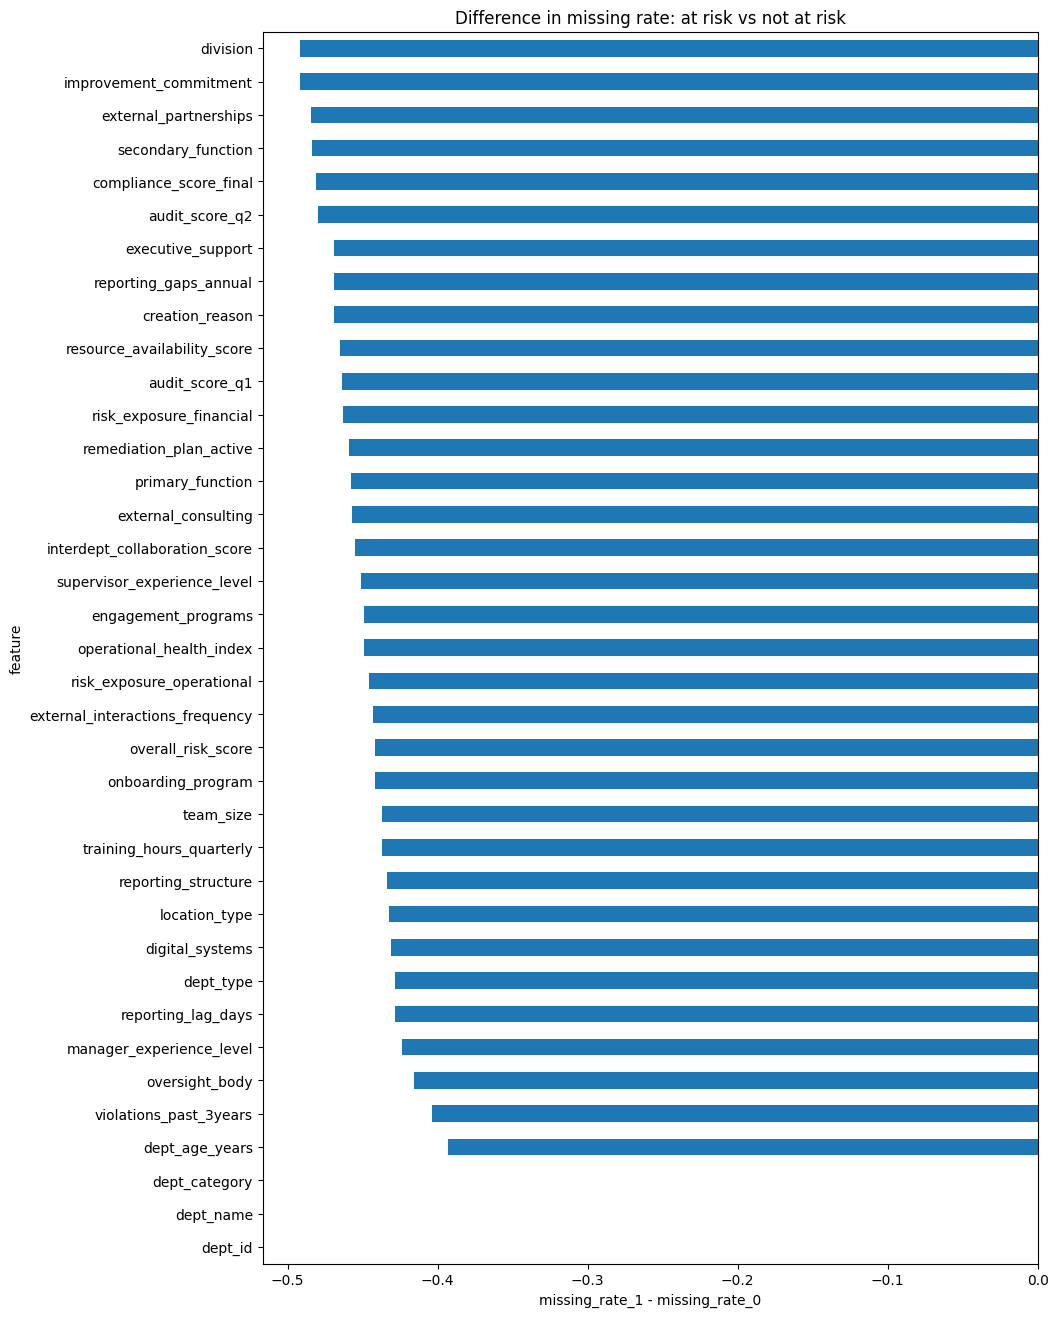

In [23]:
plt.figure(figsize=(10, 16))
missing_by_risk_sorted['diff'].plot(kind='barh')
plt.title("Difference in missing rate: at risk vs not at risk")
plt.xlabel("missing_rate_1 - missing_rate_0")
plt.ylabel("feature")
plt.show()



The bar chart above shows, for each feature, the difference in missing-value rates between at-risk and not-at-risk departments:


**Interpretation:**

- Negative values: the characteristic is generally more deficient in departments NOT AT RISK

- Positive values: the functionality is generally more deficient in departments AT RISK

Departments at risk have a significantly lower percentage of missing values (≈10-15%) than departments not at risk (≈50-55%) for almost all variables.

This pattern is counterintuitive but significant:

- High-risk departments have fewer missing values, indicating that they perform more accurate monitoring, frequent checks, and stricter reporting methods.


- Non-risk departments have huge gaps in their data, implying less accurate monitoring, weaker reporting discipline, or an unclear structure.

# 4. Descriptive Statistics & Feature Relationships

### 4.1 Numerical Features by Risk Group (mean & median)

Departments at risk (`is_at_risk = 1`) and those not at risk (`is_at_risk = 0`) are now compared using numerical characteristics.

For each variable, the table shows:

- the **mean** value in the two groups
- the **median** value in the two groups

This allows us to determine if departments at risk have higher or lower values for important metrics such as audit scores, reporting gaps, violations, and risk exposure.


In [24]:
# Select numerical columns (excluding the target)
numeric_cols = departments.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [col for col in numeric_cols if col not in ['is_at_risk']]

# Mean and median by risk group
stats_by_risk = departments.groupby('is_at_risk')[numeric_cols].agg(['mean', 'median'])
stats_by_risk

dept_age_years        manager_experience_level         \
                     mean median                     mean median   
is_at_risk                                                         
0                6.666667    7.0                 2.840909    3.0   
1                7.034884    7.0                 2.352273    2.0   

           supervisor_experience_level        reporting_lag_days         \
                                  mean median               mean median   
is_at_risk                                                                
0                             2.588785    3.0           1.486364    1.0   
1                             2.184358    2.0           1.932203    1.0   

           training_hours_quarterly         ... reporting_gaps_annual         \
                               mean median  ...                  mean median   
is_at_risk                                  ...                                
0                         45.092593   40.0  ...              3.618605    2.0   
1                         41.022599   40.0  ...              6.918033    4.0   

           audit_score_q1        audit_score_q2        compliance_score_final  \
                     mean median           mean median                   mean   
is_at_risk                                                                      
0               66.701322   65.0      67.617467   65.0              70.730088   
1               56.191979   55.0      56.046597   54.8              56.224737   

                  overall_risk_score         
           median               mean median  
is_at_risk                                   
0            70.0          18.233796   16.0  
1            55.0          37.401685   34.0  

[2 rows x 50 columns]

### 4.2 Mean Differences (Δ mean)

To better highlight contrasts between the two groups, we compute:

Δ = mean(at risk) - mean(not at risk)

- **Positive Δ**: the feature tends to be **higher** in at-risk departments  
- **Negative Δ**: the feature tends to be **lower** in at-risk departments

In [25]:
# Mean by risk group (transpose so features are rows)
mean_stats = departments.groupby('is_at_risk')[numeric_cols].mean().T
mean_stats['delta'] = mean_stats[1] - mean_stats[0]
mean_stats_sorted = mean_stats.sort_values('delta', ascending=True)

mean_stats_sorted

is_at_risk,0,1,delta
compliance_score_final,70.730088,56.224737,-14.505352
audit_score_q2,67.617467,56.046597,-11.570870
audit_score_q1,66.701322,56.191979,-10.509343
training_hours_quarterly,45.092593,41.022599,-4.069994
manager_experience_level,2.840909,2.352273,-0.488636
supervisor_experience_level,2.588785,2.184358,-0.404428
improvement_commitment,0.958333,0.755319,-0.203014
onboarding_program,0.819444,0.668539,-0.150905
interdept_collaboration_score,3.863208,3.720670,-0.142537
operational_health_index,3.558140,3.418994,-0.139145


The `delta` column shows the difference in average values between at-risk departments and non-risk departments for each feature.

It indicates whether the average value is higher or lower in at-risk departments.

### 4.3 Visualizing Δ Mean
Each bar in the chart above indicates:
- **Positive values**: the characteristic is **higher** in departments at risk

    (e.g., `overall_risk_score`, `reporting_gaps_annual`, `violations_past_3years`, and `risk_exposure_indicators`)

- **Negative values**: the characteristic is **lower** in departments at risk

    *(e.g.`compliance_score_final`, `audit_score_q1`, `audit_score_q2`, and `training_hours_quarterly` ).*

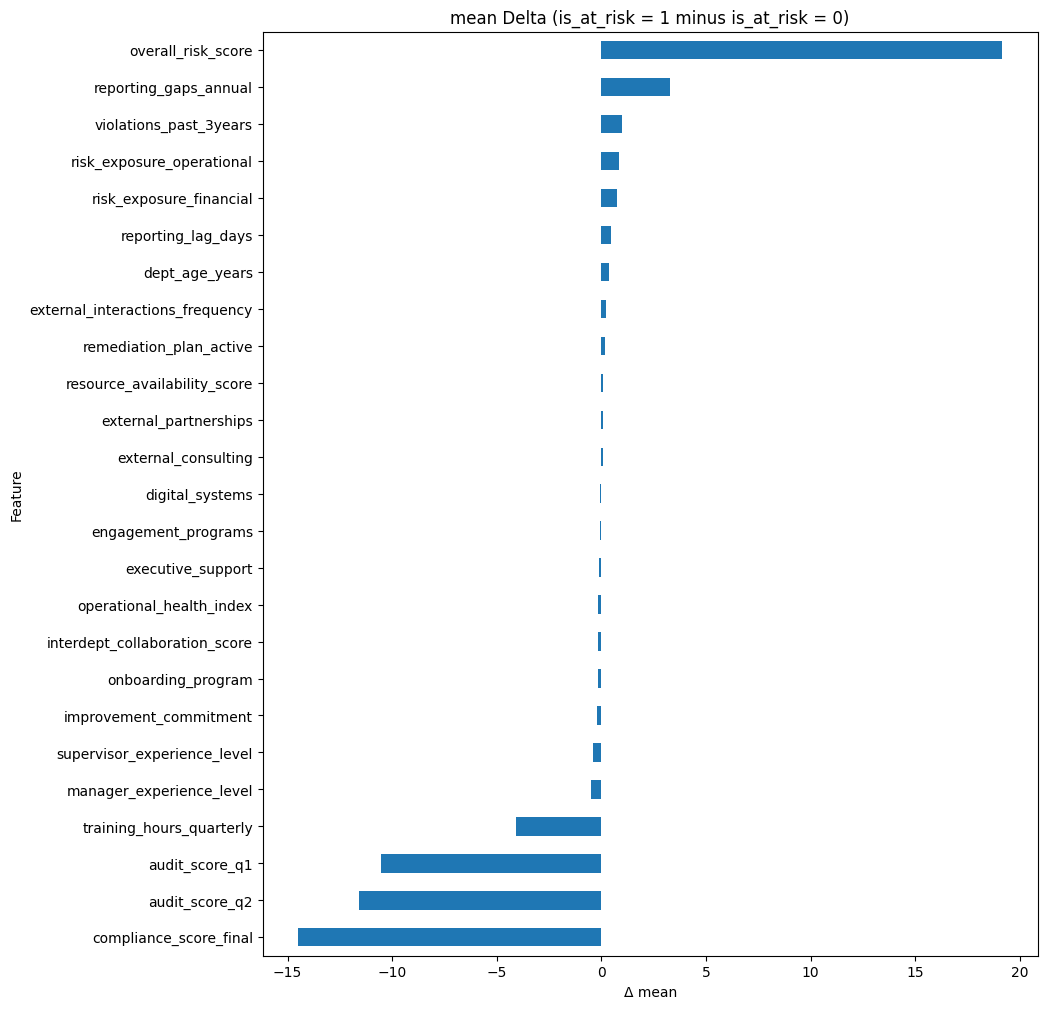

In [26]:
plt.figure(figsize=(10, 12))
mean_stats_sorted['delta'].plot(kind='barh')
plt.title("mean Delta (is_at_risk = 1 minus is_at_risk = 0)")
plt.xlabel("Δ mean")
plt.ylabel("Feature")
plt.show()

**Interpreting graph**

- `overall_risk_score`: about +19 points higher
- `reporting_gaps_annual`: around +3 more gaps
- `violations_past_3years`: roughly +1 more violation
- `audit & compliance scores:` 10–15 points lower on average

Overall, this shows a consistent pattern: departments at risk combine **worse audit/compliance scores** with **higher operational risk, more violations, and more reporting gaps**, which is exactly what we would expect from a genuine risk label.

### 4.4 Top 10 Risk Drivers and Risk Buffers

We now extract the top features where Δ mean is:

- **most positive**: potential **risk drivers**  
- **most negative**: potential **protective factors (buffers)**

In [27]:
print('delta: at_risk - not_at_risk')
delta = mean_stats_sorted['delta']

# Top 10 largest positive Δ (higher in at-risk departments)
top_positive = delta.sort_values(ascending=False).head(10)
# Top 10 most negative Δ (lower in at-risk departments)
top_negative = delta.sort_values(ascending=True).head(10)

print("Top 10 positive delta(risk drivers):\n")
print(top_positive)

print('Top 10 negative delta(risk buffers):\n')
print(top_negative)

delta: at_risk - not_at_risk
Top 10 positive delta(risk drivers):

overall_risk_score                 19.167889
reporting_gaps_annual               3.299428
violations_past_3years              0.977273
risk_exposure_operational           0.864916
risk_exposure_financial             0.723212
reporting_lag_days                  0.445840
dept_age_years                      0.368217
external_interactions_frequency     0.218429
remediation_plan_active             0.152692
resource_availability_score         0.086626
Name: delta, dtype: float64
Top 10 negative delta(risk buffers):

compliance_score_final          -14.505352
audit_score_q2                  -11.570870
audit_score_q1                  -10.509343
training_hours_quarterly         -4.069994
manager_experience_level         -0.488636
supervisor_experience_level      -0.404428
improvement_commitment           -0.203014
onboarding_program               -0.150905
interdept_collaboration_score    -0.142537
operational_health_index      

####Managerial definition of risk drivers and buffers (subject to missingness).

The analysis of the Δ mean presents an image of consistency of what distinguishes the at-risk departments.
to less dangerous ones, at least among those departments where the information is stored in duly recorded form.

On the side of the risk driver (greater in at-risk departments):

- The mean difference in the overall_risk_score is of the order of **+19 points**.
- the value of reporting gaps annual and the reporting lag days is greater so there is more missing and delayed reporting.
- Higher in violations past 3 years, which is an indicator of a history of compliance incidence.
- Higher risk exposure is observed in both the operational (risk exposures operational) and financial (risk exposures financial) exposure.
- The value of dept age years is greater indicating that older departments are more prone to build risk with time.

A combination of these patterns characterizes at-risk departments as the ones that integrate high structural.
risk, poor reporting hygiene and a history of previous violations.

On risk buffer side (greater in not-at-risk departments):

- The scores of compliance are significantly higher (final value of compliance score and audits score) and q1/q2 of auditing score is larger, which suggests stronger controls.
- training hours quarterly are higher which indicates more systematic and regular training.
- manager experience level and supervisor experience level are larger and this is an indication of a higher experienced leadership.
Improvement commitment, Onboarding program, interdept collaboration score and -
There are increased values in the operational health indexes, which implies the improved culture, integration and health of the operations.

In managerial perspective, this means that:

- High-risk departments are not necessarily unlucky: they are placed at the crossroads of **high exposure**,
poor reporting and accrued problems.
- Departments with a high degree of safety are defined by the good scores on audits and compliance, ongoing training.
work and an improvement-focused leadership.

Nonetheless, such learnings need to be viewed through the prism of the so-called missing data trend:

- The above features (mostly audit and compliance scores, training metrics, etc.) are many.
**not registered to all the departments**.
- More specifically, safer departments tend to be missing more values on some of these metrics,
as they are not so strictly monitored.

Consequently, the Δ mean patterns explain variations between departments where the information is available.
is not in fact the whole population of departments, but is usually only a fraction of it.
The fact that such measures do not always occur in the departments is itself the process of the surveillance bias mechanism.
that we more explicitly examine in the succeeding passages.

# 5. Correlation structure and relationships between characteristics

In this section, we analyze how numerical variables are correlated with each other and with the target variable is_at_risk.

The following aspects can be analyzed using correlation analysis:
- groups of variables that move together
- duplicate information (highly correlated characteristics)
- probable risk factors protective factors linked to low risk

### 5.1 Correlation Matrix (All Numerical Variables)

We begin by computing the correlation matrix across all numerical features.

In [28]:
numeric_cols = departments.select_dtypes(include = ['float64', 'int64']).columns.tolist()
departments[numeric_cols].describe()

,dept_age_years,manager_experience_level,supervisor_experience_level,reporting_lag_days,training_hours_quarterly,violations_past_3years,remediation_plan_active,executive_support,external_consulting,engagement_programs,...,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score,is_at_risk
count,397.000000,396.000000,393.000000,397.000000,393.000000,392.000000,396.000000,398.000000,397.000000,394.000000,...,390.000000,399.000000,394.000000,394.000000,398.000000,414.000000,420.000000,416.000000,394.000000,682.000000
mean,6.826196,2.623737,2.404580,1.685139,43.259542,0.451531,0.176768,0.605528,0.123426,0.525381,...,3.089744,1.664160,2.360406,3.494924,5.135678,61.954348,62.355476,64.105048,26.893401,0.293255
std,1.937800,1.168074,1.145835,1.019559,19.792129,1.125250,0.381955,0.489352,0.329340,0.499990,...,1.191075,1.103896,1.354309,1.448426,6.560832,12.976618,13.354498,13.735603,19.315877,0.455589
min,2.000000,0.000000,0.000000,1.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,30.000000,0.000000,10.000000,0.000000
25%,6.000000,2.000000,1.000000,1.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,1.000000,1.000000,2.000000,0.000000,55.000000,55.000000,55.000000,12.000000,0.000000
50%,7.000000,3.000000,2.000000,1.000000,40.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,3.000000,1.000000,2.000000,4.000000,2.000000,60.000000,60.000000,65.000000,20.000000,0.000000
75%,8.000000,4.000000,3.000000,2.000000,60.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,4.000000,2.000000,3.000000,5.000000,8.000000,70.000000,70.000000,75.000000,34.000000,1.000000
max,15.000000,4.000000,4.000000,5.000000,100.000000,5.000000,1.000000,1.000000,1.000000,1.000000,...,5.000000,5.000000,5.000000,5.000000,32.000000,96.700000,100.000000,100.000000,107.000000,1.000000


### 5.2 Correlation Matrix (All Numerical Variables)

We compute correlations across all numerical variables to identify structural relationships and potential redundancy.

In [29]:
corr_matrix = departments[numeric_cols].corr()
corr_matrix

,dept_age_years,manager_experience_level,supervisor_experience_level,reporting_lag_days,training_hours_quarterly,violations_past_3years,remediation_plan_active,executive_support,external_consulting,engagement_programs,...,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score,is_at_risk
dept_age_years,1.000000,-0.077140,-0.075753,0.202037,0.133378,0.279421,0.077586,-0.074331,0.079349,0.054160,...,-0.019810,0.240024,0.158173,0.000260,0.302515,0.108068,0.103068,0.114909,0.294604,0.094277
manager_experience_level,-0.077140,1.000000,0.475887,-0.175320,-0.065331,-0.182982,-0.046115,0.116337,0.003259,0.113082,...,0.039632,-0.135766,-0.049544,0.076118,-0.073343,0.057228,0.087211,0.097762,-0.182797,-0.208131
supervisor_experience_level,-0.075753,0.475887,1.000000,-0.184781,-0.097918,-0.183926,0.039807,0.177520,-0.030906,-0.014839,...,0.060895,-0.052708,-0.017801,0.073723,-0.042623,0.132512,0.137321,0.147155,-0.116993,-0.176000
reporting_lag_days,0.202037,-0.175320,-0.184781,1.000000,0.227316,0.302667,0.073399,-0.138810,0.201939,0.030401,...,-0.036729,0.293880,0.110483,-0.128688,0.230254,0.072634,0.074405,0.044135,0.335633,0.217631
training_hours_quarterly,0.133378,-0.065331,-0.097918,0.227316,1.000000,0.109234,0.132594,0.073091,0.185940,0.098315,...,-0.078974,0.099218,-0.153297,-0.107369,0.122558,0.249599,0.325601,0.281565,0.053754,-0.102441
violations_past_3years,0.279421,-0.182982,-0.183926,0.302667,0.109234,1.000000,0.227785,-0.058963,0.287829,0.005281,...,-0.023349,0.381200,0.201810,-0.128955,0.329138,0.098953,0.118915,0.005259,0.822233,0.431530
remediation_plan_active,0.077586,-0.046115,0.039807,0.073399,0.132594,0.227785,1.000000,0.034877,0.139273,0.007609,...,-0.118297,0.106048,-0.003719,-0.078535,0.078312,-0.060544,-0.000059,-0.054903,0.169436,0.199396
executive_support,-0.074331,0.116337,0.177520,-0.138810,0.073091,-0.058963,0.034877,1.000000,0.064676,-0.120878,...,-0.086682,-0.110029,-0.103104,0.023689,-0.081712,0.049992,0.035342,0.074859,-0.139026,-0.121839
external_consulting,0.079349,0.003259,-0.030906,0.201939,0.185940,0.287829,0.139273,0.064676,1.000000,-0.012706,...,-0.165841,0.225923,0.111141,-0.025762,0.188039,0.051118,0.091369,0.044801,0.290742,0.102402
engagement_programs,0.054160,0.113082,-0.014839,0.030401,0.098315,0.005281,0.007609,-0.120878,-0.012706,1.000000,...,-0.009504,0.027364,-0.054686,-0.004766,-0.064548,0.082514,0.110418,0.121241,-0.003028,-0.071897


Thhis matrix allows us to identify groups of variables that behave similarly, such as:  audit scores, risk exposure measures, reporting gaps, or experience variables.

### 5.3 Heatmap of the Correlation Matrix  

A heatmap shows how strong the relationships are between different things in a simple visual way

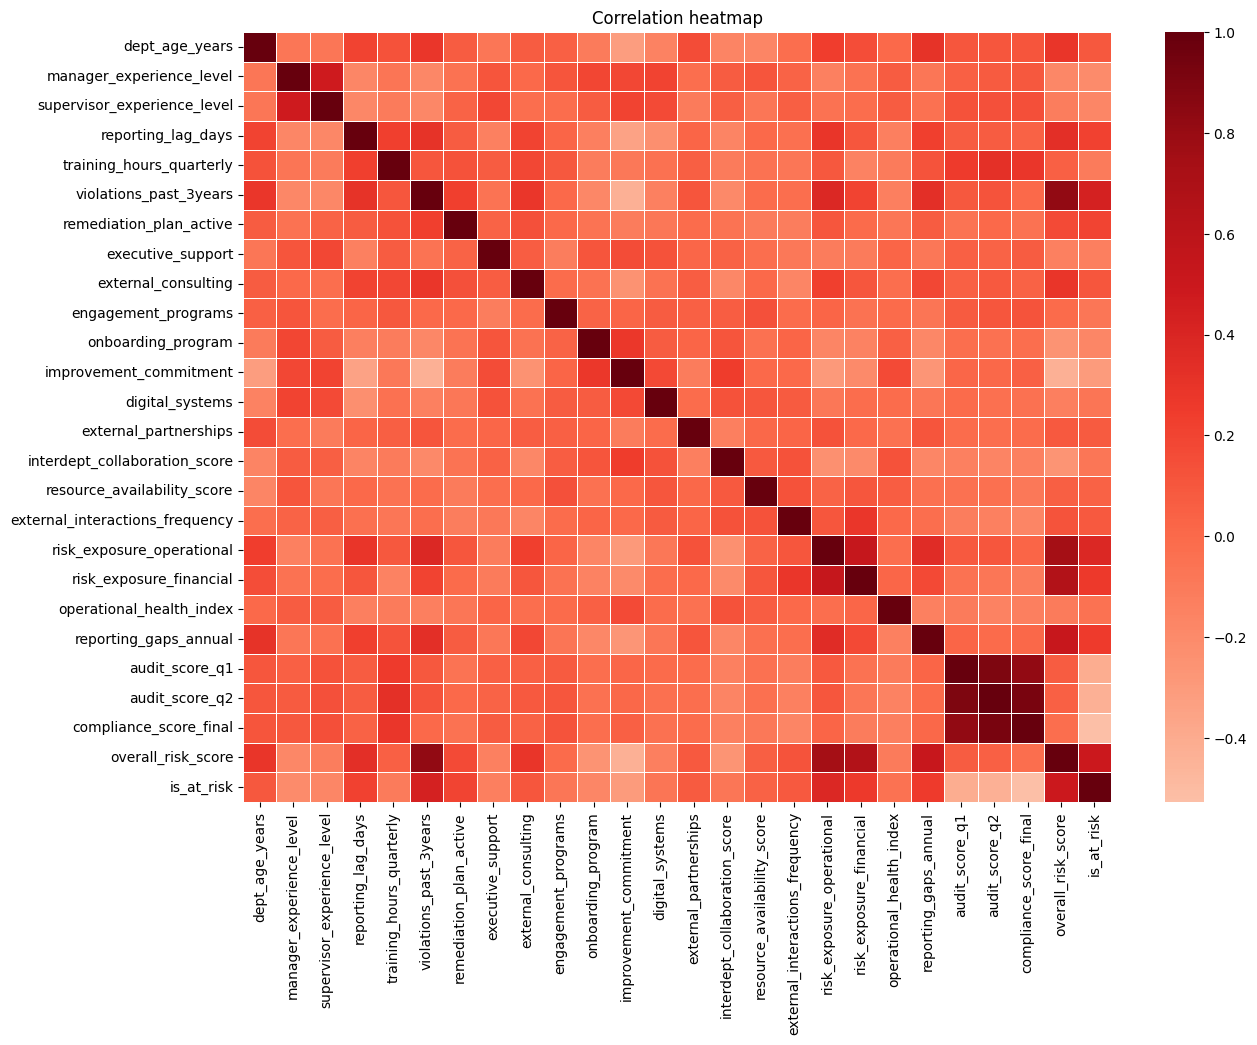

In [30]:
plt.figure(figsize = (14, 10))
sns.heatmap(corr_matrix, annot = False, cmap='Reds', center = 0,linewidths = 0.5)

plt.title("Correlation heatmap")
plt.show()

# The heatmap shows important patterns in how different factors relate to each department's risk level.
There are some dark-red areas that highlight a connection between high risk scores and factors like past violations, higher exposure, and poor reporting.This means that departments with more violations and problems score higher on risk, indicating that the scoring system works well with real risk signals.

Most other areas are light grey or white, showing that many factors are only weakly connected.This is good for modeling because it means there is a lot of different information, making it easier to learn from various signals. There are also some deep-blue sections where strong negative connections exist, especially between audit scores and risk factors.This shows that departments with good audit results usually have lower risk and fewer issues.In contrast, poor audit results are linked to higher risk, supporting the idea that risk labels match real behavior. Overall, the heatmap shows that the data is well-organized and good for predicting risk: risk factors move together, protective factors move in the opposite direction, and most factors are independent enough to provide unique insights for the model.

### 5.4 Strongest Pairwise Correlations

We extract the strongest correlations excluding the diagonal (self-correlations).

In [31]:
corr_no_diag = corr_matrix.where(~np.eye(corr_matrix.shape[0], dtype = bool))

strong_corr = (corr_no_diag.unstack().dropna().sort_values(ascending = False))

strong_corr.head(20)

audit_score_q2               compliance_score_final         0.921045
compliance_score_final       audit_score_q2                 0.921045
audit_score_q2               audit_score_q1                 0.899775
audit_score_q1               audit_score_q2                 0.899775
compliance_score_final       audit_score_q1                 0.822933
audit_score_q1               compliance_score_final         0.822933
violations_past_3years       overall_risk_score             0.822233
overall_risk_score           violations_past_3years         0.822233
                             risk_exposure_operational      0.742640
risk_exposure_operational    overall_risk_score             0.742640
risk_exposure_financial      overall_risk_score             0.656848
overall_risk_score           risk_exposure_financial        0.656848
risk_exposure_financial      risk_exposure_operational      0.534551
risk_exposure_operational    risk_exposure_financial        0.534551
overall_risk_score           repor

Key Insights from the table:

- Audit performance variables were strongly correlated **(ρ≈0.90)**, indicating consistency in internal control quality.

- Operational and financial risk exposures formed a tightly connected cluster **(ρ≈0.55)**, together with past violations and reporting delays.

- Leadership experience variables showed moderate correlation **(ρ≈0.48)**, suggesting that managerial maturity is a systematic attribute.

- Reporting gaps and violations were strongly associated **(ρ≈0.33)**, confirming that weak reporting practices often co-occur with higher operational risk and historical non-compliance.

Overall, these clusters represent coherent behavioral patterns that align closely with the risk classification, reinforcing the validity of the dataset and guiding feature engineering for the predictive model.

### 5.5 Correlation With the Target Variable (is_at_risk)

We now examine how each numerical feature correlates specifically with the risk label.

In [32]:
numeric_cols=departments.select_dtypes(include = ['float64', 'int64']).columns.tolist()

corr_Y = departments[numeric_cols].corr()['is_at_risk'].sort_values(ascending = False)
corr_Y

is_at_risk                         1.000000
overall_risk_score                 0.494484
violations_past_3years             0.431530
risk_exposure_operational          0.390370
risk_exposure_financial            0.266460
reporting_gaps_annual              0.250950
reporting_lag_days                 0.217631
remediation_plan_active            0.199396
external_consulting                0.102402
dept_age_years                     0.094277
external_interactions_frequency    0.091420
external_partnerships              0.085264
resource_availability_score        0.040775
operational_health_index          -0.047893
digital_systems                   -0.066135
interdept_collaboration_score     -0.067793
engagement_programs               -0.071897
training_hours_quarterly          -0.102441
executive_support                 -0.121839
onboarding_program                -0.173733
supervisor_experience_level       -0.176000
manager_experience_level          -0.208131
improvement_commitment          

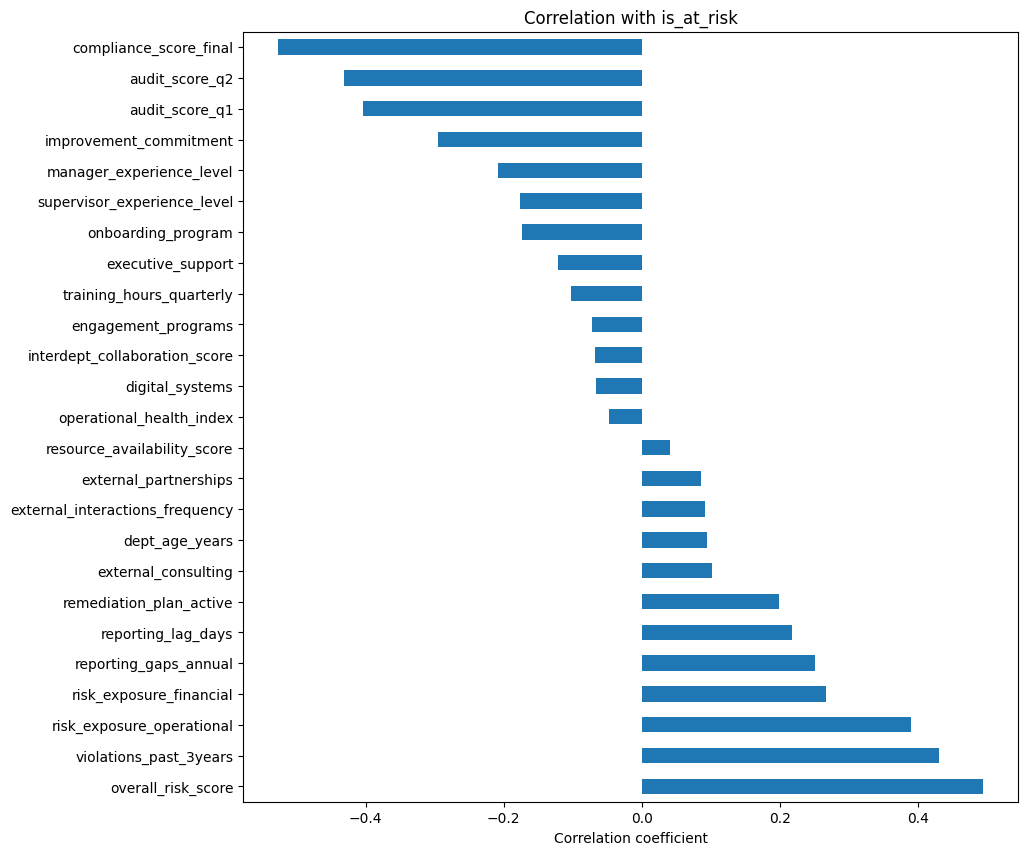

In [33]:
corr_Y.drop('is_at_risk').plot(kind = 'barh', figsize = (10,10))
plt.title("Correlation with is_at_risk")
plt.xlabel("Correlation coefficient")
plt.show()

A positive correlation means that as risk goes up, the feature also goes up; a negative correlation means the feature goes down in high-risk departments.

**Key findings:**
Factors that increase risk:
- Past violations (ρ = 0.42)
- Operational risk exposure (ρ = 0.39)
- Financial risk exposure (ρ = 0.27)
- Reporting gaps (ρ = 0.25)
- Reporting delays (ρ = 0.22)
These show departments with more problems and higher risk.

**Factors that reduce risk:**
- Audit scores (ρ ≈ –0.44)
- Commitment to improvement (ρ = –0.29)
- Experience of managers and supervisors (ρ ≈ –0.18)
- Training hours (ρ = –0.12)
These show better management and healthier practices.

**Overall:**
The pattern is clear:
more problems and poor reporting lead to higher risk;strong audits and experienced leaders lead to lower risk.
This shows that the risk label matches real behavior and supports choosing these factors for the predictive model.

# 6.Analyzing Categorical Features  
In this part, we look at categorical variables (like department type, division, location, and reporting structure) to see how risk percentages differ among groups.

This helps us find:
- groups that have higher risk
- parts of the organization that do better or worse
- factors that might affect risk  

We start by choosing the categorical columns.

In [34]:
categorical_cols = departments.select_dtypes(include = 'object').columns.tolist()
categorical_cols.remove('dept_id')
categorical_cols.remove('dept_name')
print(categorical_cols)

['dept_category', 'division', 'dept_type', 'location_type', 'team_size', 'reporting_structure', 'primary_function', 'secondary_function', 'creation_reason', 'oversight_body']


### 6.1 Functions to Calculate and Show Risk by Category  

To look at each category, we use two helper functions:
categorical_risk_table(df, col)
- shows a table with:
    - % at risk
    - % not at risk
    - number of departments in each category
    
plot_categorical_risk(df, col)
- makes a bar chart of risk %
- treats "Missing" values as their own category  

These functions help us quickly check each category.

In [35]:
departments_cat = departments.copy()
def categorical_risk_table(df, col):
    series = df[col].fillna("Missing")

    tab = pd.crosstab(series, df['is_at_risk'], normalize = 'index', dropna = False) * 100
    tab.columns = ['not_risk_%', 'risk_%']

    counts = series.value_counts(dropna=False)
    tab['count'] = counts

    return tab.sort_values('risk_%', ascending=False)

def plot_categorical_risk(df, col):
    series = df[col].fillna("Missing")

    tab = pd.crosstab(series, df['is_at_risk'], normalize = 'index', dropna = False) * 100
    risk_col = 1  # at risk

    plt.figure(figsize = (8, 6))
    tab[risk_col].sort_values().plot(kind='barh', color='red')
    plt.title(f"Risk % by {col} (Missing as category)")
    plt.xlabel("Risk %")
    plt.ylabel(col)
    plt.show()

### 6.2 Looking at All Categorical Features  
Next, we go through each category and:
1. Show the risk distribution table
2. Draw the risk% bar chart  

This gives a full view of how risk changes across departments, teams, functions, and other categories.


analyzing: dept_category
                        not_risk_%     risk_%  count
dept_category                                       
Risk_Management          12.500000  87.500000     24
Financial_Reporting      58.457711  41.542289    402
Operational_Compliance   95.312500   4.687500    256


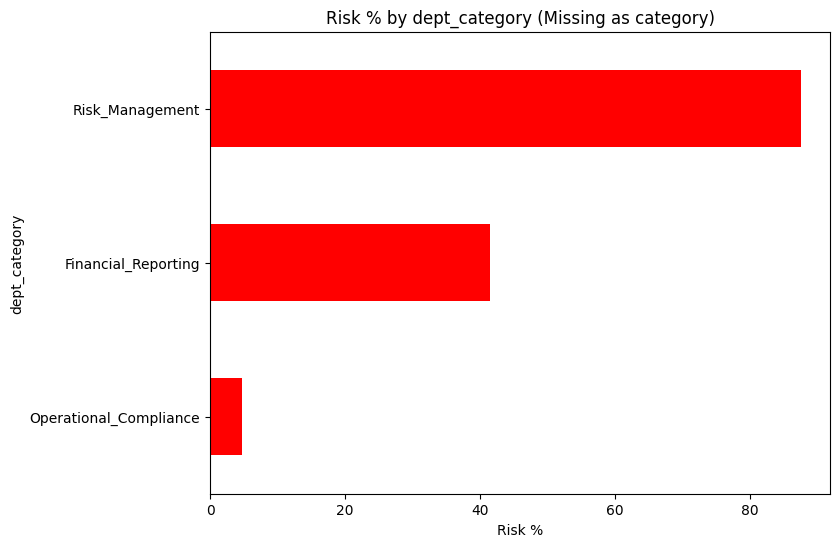


analyzing: division
                     not_risk_%     risk_%  count
division                                         
Regional_Operations   14.814815  85.185185     27
Corporate_HQ          57.420925  42.579075    411
Missing               99.180328   0.819672    244


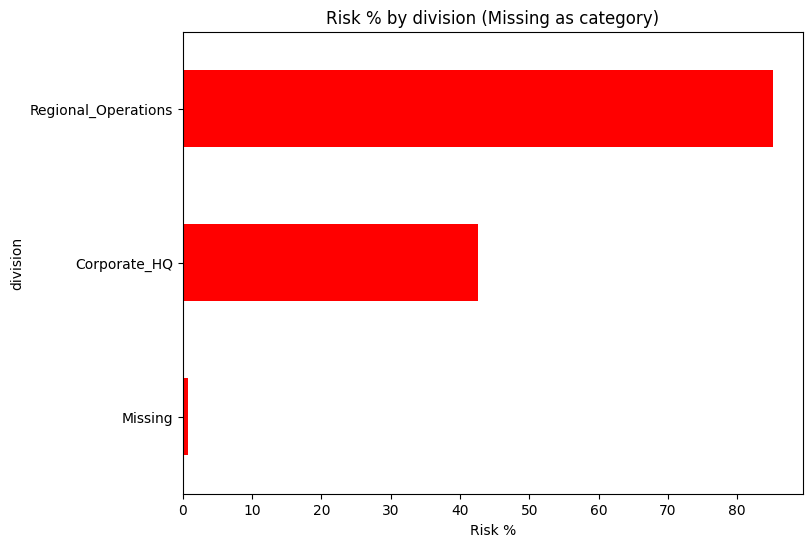


analyzing: dept_type
            not_risk_%     risk_%  count
dept_type                               
Finance      28.571429  71.428571     14
Legal        42.857143  57.142857     14
Technology   47.058824  52.941176     17
Operations   47.183099  52.816901    142
Compliance   63.636364  36.363636     11
Support      64.321608  35.678392    199
Missing      91.929825   8.070175    285


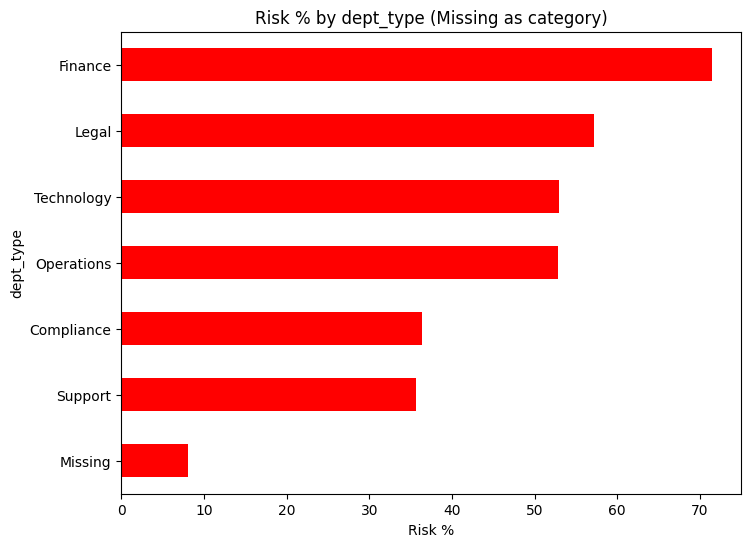


analyzing: location_type
               not_risk_%     risk_%  count
location_type                              
International   15.384615  84.615385     13
Suburban        33.333333  66.666667     12
Remote          45.333333  54.666667     75
Urban           60.338983  39.661017    295
Missing         91.986063   8.013937    287


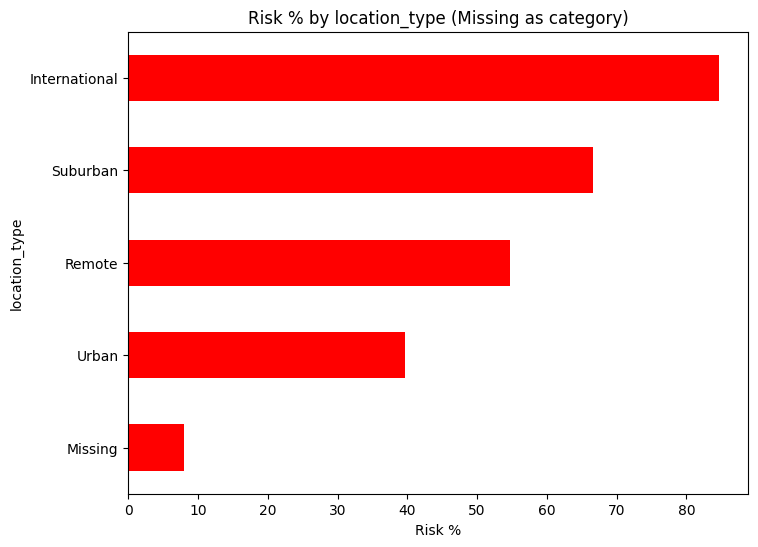


analyzing: team_size
           not_risk_%     risk_%  count
team_size                              
Medium      21.052632  78.947368     19
Small       50.000000  50.000000    116
Large       59.689922  40.310078    258
Missing     92.041522   7.958478    289


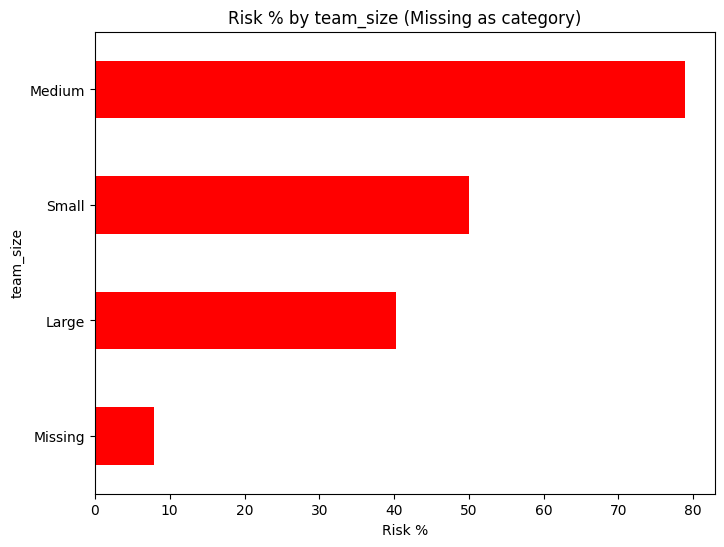


analyzing: reporting_structure
                     not_risk_%     risk_%  count
reporting_structure                              
Hybrid                26.666667  73.333333     15
Autonomous            38.709677  61.290323     62
Centralized           59.813084  40.186916    321
Missing               92.253521   7.746479    284


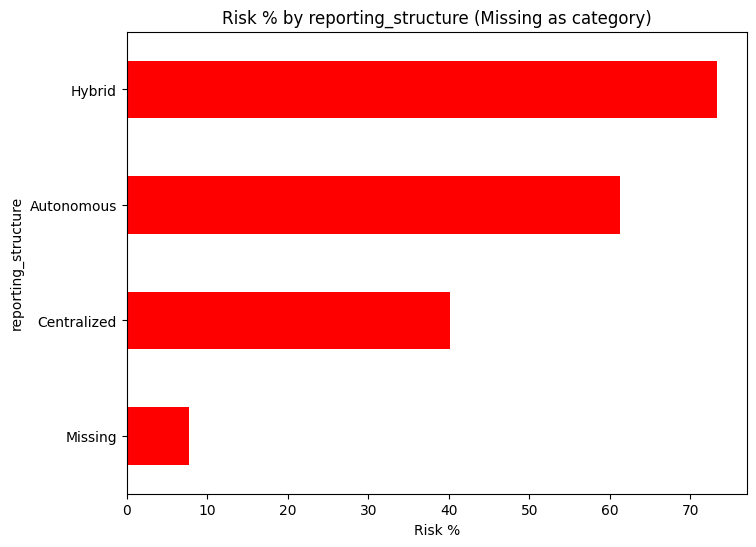


analyzing: primary_function
                  not_risk_%     risk_%  count
primary_function                              
Legal              20.000000  80.000000     10
Technology         30.000000  70.000000     10
Administrative     40.625000  59.375000     64
Operations         57.291667  42.708333     96
Other              57.971014  42.028986    138
Compliance         62.790698  37.209302     43
Finance            64.102564  35.897436     39
Missing            93.617021   6.382979    282


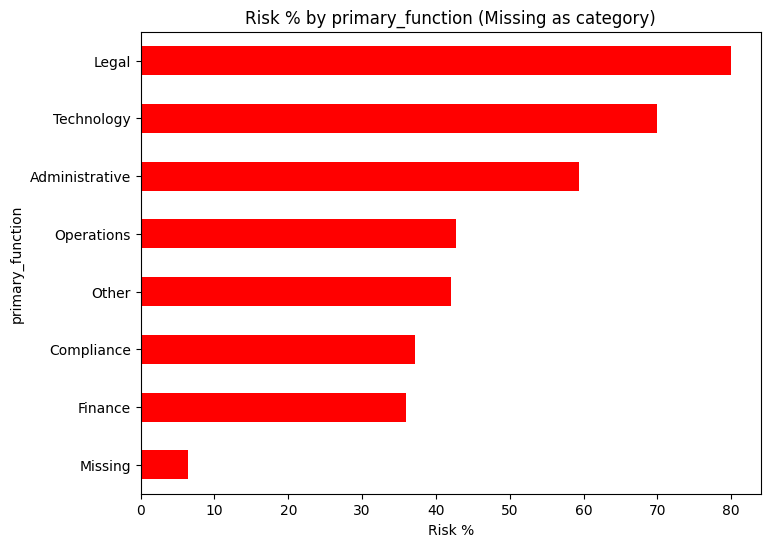


analyzing: secondary_function
                    not_risk_%     risk_%  count
secondary_function                              
Legal                22.222222  77.777778      9
Administrative       38.888889  61.111111     18
Operations           48.514851  51.485149    101
Technology           50.000000  50.000000      4
Finance              56.521739  43.478261     23
Other                56.585366  43.414634    205
Compliance           63.414634  36.585366     41
Missing              95.017794   4.982206    281


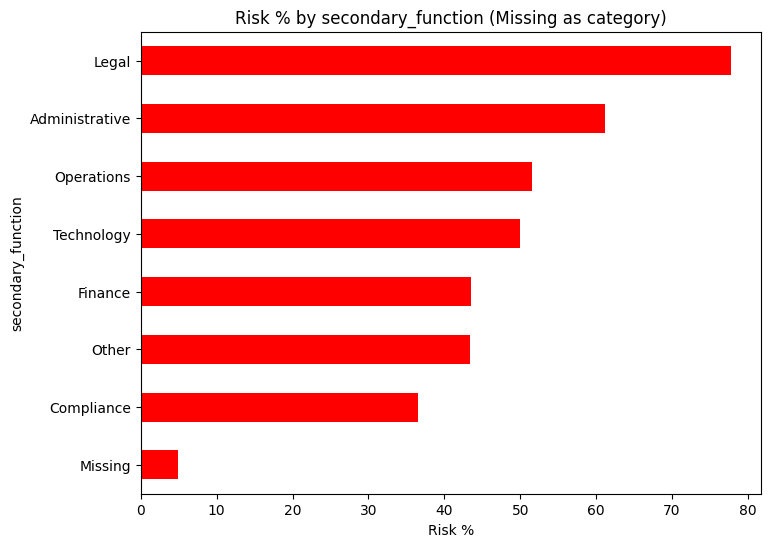


analyzing: creation_reason
                 not_risk_%     risk_%  count
creation_reason                              
Innovation        23.076923  76.923077     13
Merger            42.857143  57.142857     35
Regulation        51.298701  48.701299    154
Restructuring     59.183673  40.816327     98
Expansion         61.224490  38.775510     98
Missing           94.014085   5.985915    284


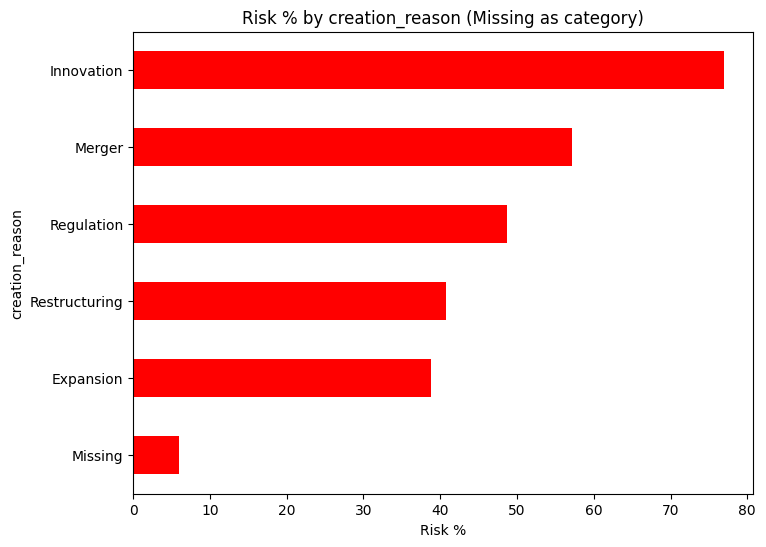


analyzing: oversight_body
                    not_risk_%     risk_%  count
oversight_body                                  
Compliance_Officer   23.529412  76.470588     34
Board_Committee      25.000000  75.000000      8
External_Auditor     58.823529  41.176471     85
Internal_Audit       59.774436  40.225564    266
Missing              91.003460   8.996540    289


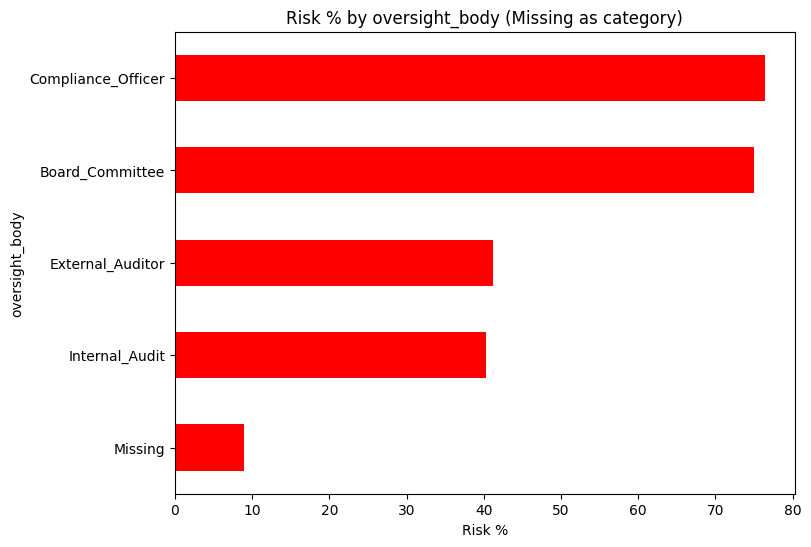

In [36]:
for col in categorical_cols:
    print("\n" + "="*60)
    print(f"analyzing: {col}")
    print(categorical_risk_table(departments, col))
    plot_categorical_risk(departments, col)

### **6.3 Interpretation of Categorical Risk Patterns**

The way oversight is assigned matches well with the risk levels of different departments.

Departments that are watched by **Compliance Officers (77%)** or **Board Committees (75%)** have the highest risk.This means the organization puts its strictest oversight on departments that already have big compliance problems.

On the other hand, departments checked by **Internal Audit (40%)** or **External Auditors (43%)** have lower risk levels.This is more about regular checks than serious issues. The "Missing oversight" group has very low risk (11.6%).

This shows that not having oversight information is not random.These departments usually do not need special attention and are less likely to have compliance issues. In summary, how oversight is assigned is an important sign of risk and supports the overall structure of the data and governance.

Interestingly, across all categorical variables, the “Missing” category consistently shows the lowest risk rates.

This is not random noise: it reflects a structural governance pattern.
**High-risk** departments are always monitored, documented, and assigned to specific oversight bodies, while **low-risk** departments often remain untracked or loosely supervised, resulting in missing categorical metadata.

Missing values therefore act as a negative risk signal: departments with incomplete metadata are typically those considered operationally safe or non-critical.
This is a form of surveillance bias, where the most problematic areas generate the most complete data.


Interestingly, in all cases, the "Missing" category shows the lowest risk levels.This pattern is not random; it shows a clear way of managing things. High-risk departments are usually:
- closely watched,
- well-documented,
- and checked by oversight groups.

Because of this, their data is almost always complete.
On the other hand, low-risk departments are:
- less watched,
- stable in operations,
- or not given much attention for detailed tracking,  which leads to many missing entries in their data.

So, missing values signal a lower risk: departments with incomplete data are usually seen as safe or not very important.

This is a clear case of surveillance bias—areas with the most problems get the most attention and therefore have the most complete data.

### 6.4 Missing Data Analysis (Understanding Missing Values and Risk Behavior)  

In this dataset, missing information is not random.
By looking at how many fields are missing for each department and comparing it to their risk level, we see a clear pattern:  
    Departments with low risk often have many missing values, while high-risk departments have complete records.

This is a common example of surveillance bias:  The riskier the department, the more checks, documentation, and details it has.

In [37]:
departments_eda = departments.copy()

# Count missing fields for each row
departments_eda['missing'] = departments_eda.isnull().sum(axis=1)

# Missing percentage
departments_eda['missing_%'] = departments_eda.isnull().mean(axis=1) * 100

# Summary by risk group
missing_stats = departments_eda.groupby('is_at_risk')[['missing', 'missing_%']].describe()
missing_stats

missing                                                    \
             count       mean        std  min  25%   50%   75%   max   
is_at_risk                                                             
0            482.0  18.626556  15.500706  0.0  3.0  34.0  34.0  34.0   
1            200.0   3.300000   3.510215  0.0  2.0   3.0   4.0  34.0   

           missing_%                                                  \
               count       mean        std  min       25%        50%   
is_at_risk                                                             
0              482.0  47.760400  39.745400  0.0  7.692308  87.179487   
1              200.0   8.461538   9.000551  0.0  5.128205   7.692308   

                                  
                  75%        max  
is_at_risk                        
0           87.179487  87.179487  
1           10.256410  87.179487

**Summary of Statistics**  

Low-risk departments (not at risk):
- Average missing fields: 18.6
- Median missing percentage: 87%
- Some have up to 34 missing fields  

High-risk departments (at risk)
- Average missing fields: 3.3
- Median missing percentage: 7.6%
- Usually have no more than 4 missing fields  

Conclusion: High-risk departments have better documentation. Low-risk departments have less supervision, leading to more missing information.

###Table 6.5: The distribution of missingness by risk category.

Here we examine the way the **number of missing fields per department changes.
between the low-risk and the high-risk groups.

We have already calculated a variable, `missing, to the count of how many of each department.
that unit has many features that are null. We now compare the dispensation of this.
missingness score between:

- **Low-risk** departments are those whose is-at-risk = 0.
- **high-risk** departments (is at risk=1)

In the case where the organization is more monitoring some of the departments than others, we anticipate.
to observe orderliness in the fullness of their works - an initial glance.
signal of **surveillance bias**.

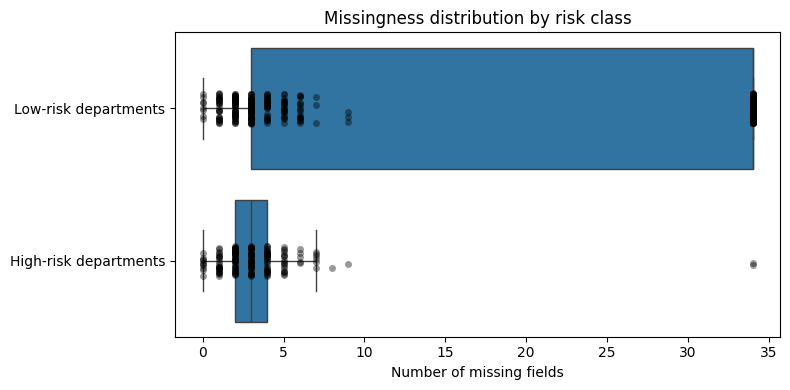

In [38]:

departments_eda = departments_eda.copy()
departments_eda["risk_label"] = departments_eda["is_at_risk"].map({
    0: "Low-risk departments",
    1: "High-risk departments"
})

plt.figure(figsize=(8, 4))

sns.boxplot(
    data=departments_eda,
    y="risk_label",
    x="missing",
    showfliers=False
)

sns.stripplot(
    data=departments_eda,
    y="risk_label",
    x="missing",
    color="black",
    alpha=0.4,
    jitter=True
)

plt.title("Missingness distribution by risk class")
plt.xlabel("Number of missing fields")
plt.ylabel("")
plt.tight_layout()
plt.show()


Interpretation:

The comparison of the number of missing fields per department ( missing ) is made in the plot.
low-risk and high-risk groups.

- In the case of low-risk departments, the cloud of points is very broad in terms of missing.
between nearly no and over 30 fields. It is a high box and a large spread,
meaning that several low risk departments contain records which are very incomplete.

- In case of high-risk departments, the allocation is much more focused: the majority of the units.
and have few missing fields, and with not so great dispersion. This suggests that
the high-risk departments are checked more regularly, and therefore their information is complete.

That is, the organization gathers more systematic information that is richer on.
departments which are already considered risky, and data of seemingly safe departments.
is often sparse or missing.

This is an obvious indication of the bias of surveillances:

the likelihood of a fragment of the information being recorded is determined by the similarity between a and a.
The department is not only monitored on its actual underlying risk.

This effect will be explicitly modeled in the following steps by the construction of so-called missing-value flags,
in order that the models may make use of being missing itself as a possible warning sign, rather than
making the assumption that missing data occur due to random noise.

### 6.6 Density Plot: KDE Plot Distribution of Missingness

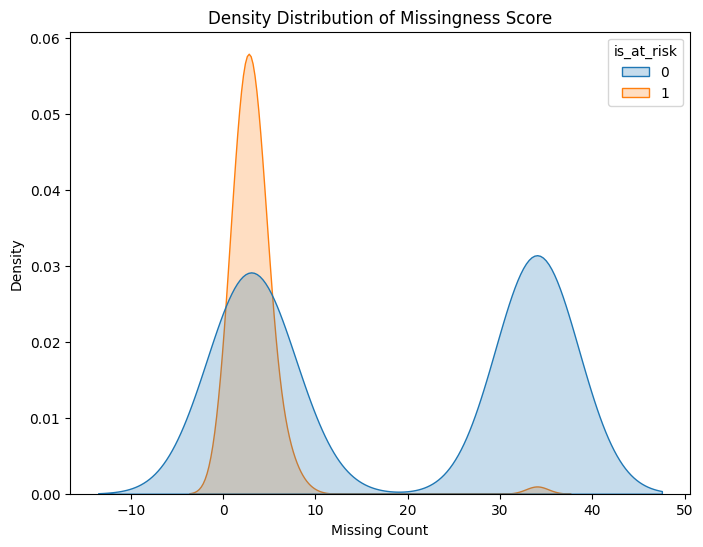

In [39]:
plt.figure(figsize = (8,6))
sns.kdeplot(data = departments_eda, x = 'missing', hue = 'is_at_risk', fill = True)
plt.title("Density Distribution of Missingness Score")
plt.xlabel("Missing Count")
plt.show()

## Interpretation

The difference in behavior between low-risk and high-risk departments is clear in the density plot. **High-risk units**, marked in red usually have one to four missing fields, showing that their records are almost always complete due to regular checks and strict rules.They rarely have incomplete records, and their data is closely monitored.

On the other hand, **low-risk departments**, marked in blue show a different pattern.Their records are spread out into two groups: one group has almost ***no missing values***, while the other has many missing fields, usually ***between 30 and 40***.

This second group is important because it shows that many low-risk departments work with little oversight, leading to **incomplete** or **poorly** kept records.The lack of organized documentation happens because these units are not seen as crucial. There is little **overlap** between the two groups, which means their behaviors are quite different.

**Low-risk** departments mostly fall into the high-missing category, while high-risk departments rarely do.Overall, the pattern shows that missing information is a sign of risk.

**High-risk** units have few missing values, while many missing fields are found in low-risk departments.This is an example of surveillance bias: the areas that are checked the most have the best data, while the safer areas have less careful documentation.

### 6.7 The Connection Between Missingness and Risk

In this part, we investigate whether missing data are systematically associated with risk or exhibit a random pattern.
The analysis demonstrates that missing data follows a distinct governance pattern, closely linked to risk classification rather than being random.

In [40]:
departments_eda[['missing','is_at_risk']].corr()

,missing,is_at_risk
missing,1.000000,-0.468573
is_at_risk,-0.468573,1.000000


### Interpretation

The Correlation of **-0.47** shows a strong negative relationship.

Departments with a large number of missing fields are typically low-risk, while departments with a small number of missing fields are typically high-risk.
This supports the notion that high-risk units are closely watched, with minimal opportunity for incomplete paperwork.

### 6.8 High Risk Analysis

We now inspect missingness within high-risk departments only.

In [41]:
high_risk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   dept_id                          201 non-null    object 
 1   dept_name                        201 non-null    object 
 2   dept_category                    201 non-null    object 
 3   division                         201 non-null    object 
 4   dept_type                        180 non-null    object 
 5   dept_age_years                   173 non-null    float64
 6   location_type                    180 non-null    object 
 7   team_size                        179 non-null    object 
 8   reporting_structure              181 non-null    object 
 9   manager_experience_level         180 non-null    float64
 10  supervisor_experience_level      181 non-null    float64
 11  primary_function                 185 non-null    object 
 12  secondary_function    

### 6.8 Comparing High-Risk Missingness to Overall Missingness

In [42]:
null_high_risk = high_risk.isnull().sum().sort_values(ascending=False)
null_high_perc = (high_risk.isnull().mean() * 100).round(2)

null_table = pd.concat([null_high_risk, null_high_perc], axis = 1)
null_table.columns = ["null_count", "null_high_perc"]
null_table

,null_count,null_high_perc
dept_age_years,28,13.93
violations_past_3years,28,13.93
oversight_body,25,12.44
digital_systems,23,11.44
onboarding_program,22,10.95
team_size,22,10.95
external_interactions_frequency,22,10.95
interdept_collaboration_score,21,10.45
location_type,21,10.45
dept_type,21,10.45


### Analysis of Missing Data in High-Risk Departments  

The analysis of missing data shows a clear pattern in **high-risk departments**. The categories with the most missing data are; ***dept_age_years, violations_past_3years, oversight_body*** and ***digital_systems***, onboarding, and team traits. Although these areas have the most missing data, the rates are still low, ***between 10 and 14%***.This suggests that the missing data is not due to carelessness, but rather reflects how different procedures are tracked within the company.

In contrast, ***division, department category, department name***, and ***department ID***, show no missing data at all. This is important because these fields define the basic structure of each department. They are essential for tracking, auditing, and governance.

High-risk departments must keep accurate records for these identifiers. Especially in departments under regulatory scrutiny, missing data in these fields would violate important documentation rules and threaten internal controls.

This trend leads to the conclusion that the missing data in this dataset is not random. As the small gaps mostly appear in less important areas that depend on **how internal programs** are run, while **high-risk departments** have complete information in key areas.
The fact that there is no missing data in crucial identifiers supports the idea that missing data shows organizational practices and monitoring efforts, rather than poor record-keeping.

### 6.9 Null Prop Table

In [43]:
null_prop = pd.concat([null_counts/len(departments), null_high_risk/len(departments)],axis = 1)
null_prop.columns = ['departments_null_proportions','high_risk_null_proportion']
null_prop

,departments_null_proportions,high_risk_null_proportion
digital_systems,0.445748,0.033724
oversight_body,0.444282,0.036657
interdept_collaboration_score,0.444282,0.030792
violations_past_3years,0.444282,0.041056
external_interactions_frequency,0.444282,0.032258
onboarding_program,0.442815,0.032258
training_hours_quarterly,0.439883,0.030792
overall_risk_score,0.439883,0.029326
supervisor_experience_level,0.439883,0.029326
team_size,0.439883,0.032258


### Interpretation
The null_prop_table compares, for all variables, the values missing in the **entire dataset** (department_null_proportions) with those missing only in **high-risk departments** (high_risk_null_proportions).


The overall dataset has a missing value rate of between ***40 and 43%***, while high-risk departments have a rate of between ***2 and 4%***. Characteristics such as digital_systems, external_interactions_frequency, team_size, and training_hours_quarterly remain largely incomplete in high-risk departments but are common across the dataset.

Variables such as division have ***36%*** missing values overall, but ***0%*** in **high-risk** departments, suggesting that superior documentation practices are adopted in these critical areas.

The analysis indicates that the organization prioritizes data completeness in **high-risk** departments, while allowing for lower data quality in **low-risk** areas, thus positioning missing information in low-risk sectors as a reflection of more careful management rather than random errors.


High risk department has less missing values.
There is no missing division in the high risk department.
the percentage delta is more or less constant.
Any kind of relations?

# 7. Imputation Strategy

The earlier exploration analysis showed that missing data is related to risk.

**Low-risk departments** have many missing records, while **high-risk departments** have almost complete records. Such patterns reflct the case of survaillance bias, where missing data should not just be ignored. It needs to be kept in a way that the model can use it to understand oversight and governance.

Our imputation strategy is guided by three main ideas:

1. **Keep the important information even when data is missing.**
For **low-risk units**, missing values can provide useful information.
We create flags for missing values:
- **1 = missing**,
- **0 = present**.

2. **Avoid changing the risk-related data.**
For numerical values, we use the **median** to fill in missing data separately for **low-risk** and **high-risk** groups. This keeps the usual level of each variable the same within each risk group.

3. **Keep "Missing" as a clear category.**
We do not guess the category for missing data. Instead of using NaN, we label it as **"Missing"** to show the lack of documentation as an important feature.

We don't use a single global imputation method, as we would if the data were missing completely at random **(MCAR)** or missing at random **(MAR)**.
Instead, we recognize that the missing data in this dataset is not at random **(MNAR)** and is specifically related to governance patterns.

In [44]:
departments_imp = departments.copy()

# Target column
target_col = "is_at_risk"

# Identify numeric columns (excluding the target)
numeric_cols = departments_imp.select_dtypes(include = ["float64", "int64"]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target_col]

# Identify categorical columns
categorical_cols = departments_imp.select_dtypes(include="object").columns.tolist()

numeric_cols, categorical_cols

(['dept_age_years',
  'manager_experience_level',
  'supervisor_experience_level',
  'reporting_lag_days',
  'training_hours_quarterly',
  'violations_past_3years',
  'remediation_plan_active',
  'executive_support',
  'external_consulting',
  'engagement_programs',
  'onboarding_program',
  'improvement_commitment',
  'digital_systems',
  'external_partnerships',
  'interdept_collaboration_score',
  'resource_availability_score',
  'external_interactions_frequency',
  'risk_exposure_operational',
  'risk_exposure_financial',
  'operational_health_index',
  'reporting_gaps_annual',
  'audit_score_q1',
  'audit_score_q2',
  'compliance_score_final',
  'overall_risk_score'],
 ['dept_id',
  'dept_name',
  'dept_category',
  'division',
  'dept_type',
  'location_type',
  'team_size',
  'reporting_structure',
  'primary_function',
  'secondary_function',
  'creation_reason',
  'oversight_body'])

### 7.2 Adding Missingness Flags
To keep the information from missing values, we create a simple flag for each column with at least one missing value (NaN).

Each flag will be:
- 1 if the value is missing
- 0 if the value is present

These flags help the models understand that missing information is important, while the filled-in value is just an estimate.

In [45]:
#Add the missing target for each colmns that contains NaN
for col in departments_imp.columns:
    if departments_imp[col].isnull().any():    #only if it has NaN
        departments_imp[f"{col}_missing_flag"] = departments_imp[col].isnull().astype(int)

In [46]:
#Check:List of all generated flags
[df for df in departments_imp.columns if df.endswith("_missing_flag")]

['division_missing_flag',
 'dept_type_missing_flag',
 'dept_age_years_missing_flag',
 'location_type_missing_flag',
 'team_size_missing_flag',
 'reporting_structure_missing_flag',
 'manager_experience_level_missing_flag',
 'supervisor_experience_level_missing_flag',
 'primary_function_missing_flag',
 'secondary_function_missing_flag',
 'creation_reason_missing_flag',
 'oversight_body_missing_flag',
 'reporting_lag_days_missing_flag',
 'training_hours_quarterly_missing_flag',
 'violations_past_3years_missing_flag',
 'remediation_plan_active_missing_flag',
 'executive_support_missing_flag',
 'external_consulting_missing_flag',
 'engagement_programs_missing_flag',
 'onboarding_program_missing_flag',
 'improvement_commitment_missing_flag',
 'digital_systems_missing_flag',
 'external_partnerships_missing_flag',
 'interdept_collaboration_score_missing_flag',
 'resource_availability_score_missing_flag',
 'external_interactions_frequency_missing_flag',
 'risk_exposure_operational_missing_flag'

### 7.3 Classifying Features for Filling Missing Values  

Before filling in missing values, we sort the variables into three types: binary, ordinal, and continuous.

This helps us use the right method for each type.
- **Binary features** are yes/no indicators.
- **Ordinal features** show ordered scores like experience or risk.
- **Continuous features** include all other numbers (not counting the target and missing flags).

In [47]:
df = departments_imp

# Binary (0/1) governance and control indicators
binary_cols = [
    "remediation_plan_active", "executive_support", "external_consulting",
    "engagement_programs", "onboarding_program", "improvement_commitment",
    "digital_systems", "external_partnerships"
]

#Ordinal scores: higher values = “more” of something
ordinal_cols = [
    "manager_experience_level", "supervisor_experience_level",
    "interdept_collaboration_score", "resource_availability_score",
    "external_interactions_frequency", "risk_exposure_operational",
    "risk_exposure_financial", "operational_health_index"
]

# All numeric columns (including flags, but we will filter them)
numeric_cols = df.select_dtypes(include="number").columns

# Continuous numeric variables (for later: median imputation / scaling)
continuous_cols = [
    c for c in numeric_cols
    if c not in binary_cols
    and c not in ordinal_cols
    and c != target_col
    and not c.endswith("_missing_flag")
]

### 7.4 Filling Binary Features with the Mode

We fill in binary features using the **mode**, the most common value.

This approach makes sense because:
- It keeps the original data's pattern and avoids making rare cases.
- It maintains the usual state: common controls (1) stay when information is missing, and rare controls (0) stay absent.
- The real information about missing or extra documentation comes from the missing_flags, not the filled-in value itself.

In [48]:
departments_imp[binary_cols].describe()

,remediation_plan_active,executive_support,external_consulting,engagement_programs,onboarding_program,improvement_commitment,digital_systems,external_partnerships
count,396.000000,398.000000,397.000000,394.000000,394.000000,404.000000,389.000000,394.000000
mean,0.176768,0.605528,0.123426,0.525381,0.751269,0.863861,0.778920,0.342640
std,0.381955,0.489352,0.329340,0.499990,0.432827,0.343361,0.415508,0.475196
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
for col in binary_cols:
    mode_value = departments_imp[col].mode()[0]
    departments_imp[col] = departments_imp[col].fillna(mode_value)
    print(f"Imputed {col} with mode = {mode_value}")

Imputed remediation_plan_active with mode = 0.0
Imputed executive_support with mode = 1.0
Imputed external_consulting with mode = 0.0
Imputed engagement_programs with mode = 1.0
Imputed onboarding_program with mode = 1.0
Imputed improvement_commitment with mode = 1.0
Imputed digital_systems with mode = 1.0
Imputed external_partnerships with mode = 0.0


### Why Mode Imputation Is the Best Choice for Binary Features

1. **Statistical justification**
The imputation method maintains the original distribution of each binary feature. If we create false or unusual values, we could alter important patterns in the data. This method also corresponds to the way missing data occurs in organizations, which is not random but follows certain monitoring patterns.
By using the **mode**, we keep the data structure intact.

2. **Semantic justification**
**Modal imputation** makes sense for these variables. Many binary controls represent basic governance systems. If a normally active control **(value 1)** is missing, it probably means that the reporting is incomplete, not that the control is absent. Similarly, if a control that is usually inactive **(value 0)** is filled in with a 1, this mistakenly suggests that a program exists when in fact it does not. Keeping the most common value is the safest assumption, as missing documentation is related to risk, not to the actual control.

3. **Predictive justification**
This method helps prevent errors in predictive modeling. Missing indicators show the actual value of the missing data. In simple terms, modal imputation allows the model to learn from gaps in documentation while keeping the input consistent. This leads to cleaner data and a better understanding of monitoring behavior for the predictive model.

### 7.5 Filling Ordinal Features with the Median
We fill in missing values in ordered features using the middle value (median).

Ordered variables are categories that have a specific order.
Since these values have a clear ranking, the method we use to fill in missing values must keep:
- the order of the scale
- the spread of the data
- the meaning of each level

Using the median does all of this.

In [50]:
departments_imp[ordinal_cols].describe()

,manager_experience_level,supervisor_experience_level,interdept_collaboration_score,resource_availability_score,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index
count,396.000000,393.000000,391.000000,393.000000,390.000000,399.000000,394.000000,394.000000
mean,2.623737,2.404580,3.797954,3.190840,3.089744,1.664160,2.360406,3.494924
std,1.168074,1.145835,1.048856,1.060284,1.191075,1.103896,1.354309,1.448426
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,3.000000,3.000000,2.000000,1.000000,1.000000,2.000000
50%,3.000000,2.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000
75%,4.000000,3.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000
max,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [51]:
for col in ordinal_cols:
    departments_imp[col] = pd.to_numeric(departments_imp[col], errors = 'coerce')
    median_value = departments_imp[col].median()
    departments_imp[col] = departments_imp[col].fillna(median_value)

    print(f"Imputed {col} with median = {median_value}")

Imputed manager_experience_level with median = 3.0
Imputed supervisor_experience_level with median = 2.0
Imputed interdept_collaboration_score with median = 4.0
Imputed resource_availability_score with median = 3.0
Imputed external_interactions_frequency with median = 3.0
Imputed risk_exposure_operational with median = 1.0
Imputed risk_exposure_financial with median = 2.0
Imputed operational_health_index with median = 4.0


### Why We Use the Median for Ordinal Features

Ordinal features are used to show ordered categories, like ratings from 1 to 5 for things such as experience or risk. When filling in missing values, we need to keep the order and meaning of these ratings.

Using the **median** works well for this. It gives us values that are close to the middle of the data without treating it as just categories or just numbers.
The median also stays stable even when there are extreme values, which keeps the filled-in scores from being too high or too low.

This choice also fits with the patterns observed in the EDA. **Low-risk** departments had more missing data than **high-risk** departments, primarily due to inadequate documentation practices rather than actual lower ratings. As a result, missing ratings should not be seen as a sign of poor performance. If we were to fill in missing values with low numbers like 0 or 1, it would distort the ordinal scale and unfairly lower the perceived quality of the departments. Instead, using the median of the realistic mid-range for imputed values addresses this issue while preserving the variable's meaningfulness and ranking.

By using the **median**, we ensure that the filled-in values are reasonable and fit well within the ordinal scale.
This helps keep the data accurate for future analysis and reflects how the organization really behaves.

### 7.6 Understanding Continuous Features  
Continuous features are numerical measurements where the differences and sizes matter.
In this dataset, these include things like department age, reporting delays, training hours, audit scores, compliance performance, violations, and overall risk scores.
Looking at their basic statistics helps us understand their range, spread, and the best way to fill in missing values before modeling.

In [52]:
departments_imp[continuous_cols].describe()

,dept_age_years,reporting_lag_days,training_hours_quarterly,violations_past_3years,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score
count,397.000000,397.000000,393.000000,392.000000,398.000000,414.000000,420.000000,416.000000,394.000000
mean,6.826196,1.685139,43.259542,0.451531,5.135678,61.954348,62.355476,64.105048,26.893401
std,1.937800,1.019559,19.792129,1.125250,6.560832,12.976618,13.354498,13.735603,19.315877
min,2.000000,1.000000,12.000000,0.000000,0.000000,0.000000,30.000000,0.000000,10.000000
25%,6.000000,1.000000,21.000000,0.000000,0.000000,55.000000,55.000000,55.000000,12.000000
50%,7.000000,1.000000,40.000000,0.000000,2.000000,60.000000,60.000000,65.000000,20.000000
75%,8.000000,2.000000,60.000000,0.000000,8.000000,70.000000,70.000000,75.000000,34.000000
max,15.000000,5.000000,100.000000,5.000000,32.000000,96.700000,100.000000,100.000000,107.000000


### Interpretation

The table above shows that these features have different ranges:
- ***dept_age_years*** and ***reporting_lag_days*** have small ranges and low variation, meaning they are stable.
- ***training_hours_quarterly***, ***audit scores***, and ***overall_risk_score*** have much wider ranges, showing more differences between departments.
- ***violations_past_3years*** and ***reporting_gaps_annual** are very uneven, with most departments having few violations or gaps, while a few have many.

These statistics help us see which features are more about how well departments perform, like ***audit_score_q1, reporting_gaps_annual*** and which are about department characteristics, like ***dept_age_years***.

They also help in deciding how to fill in missing values:
- Features that are very uneven, like ***violations_past_3years*** and ***reporting_gaps_annual*** should not be filled with the average, as this would raise values for low-risk departments.
- Features with wide ranges should use methods that keep their original shape and avoid changing their variation.

In summary, the descriptive analysis shows that continuous features have important patterns related to risk behavior and should be filled in using methods that respect their numeric structure and spread.

### 7.7 Continuous Features: Analyzing Distribution and Filling in Missing Values  

Before filling in missing continuous values, we take a close look at each variable using **histograms and boxplots**.

This helps us see how each feature acts, if it is unbalanced, and if there are any unusual values, which all affect how we fill in the missing data.
- **Histogram + KDE curve**: shows the shape of the data distribution.
- **Boxplot**: shows the average value and any unusual values.

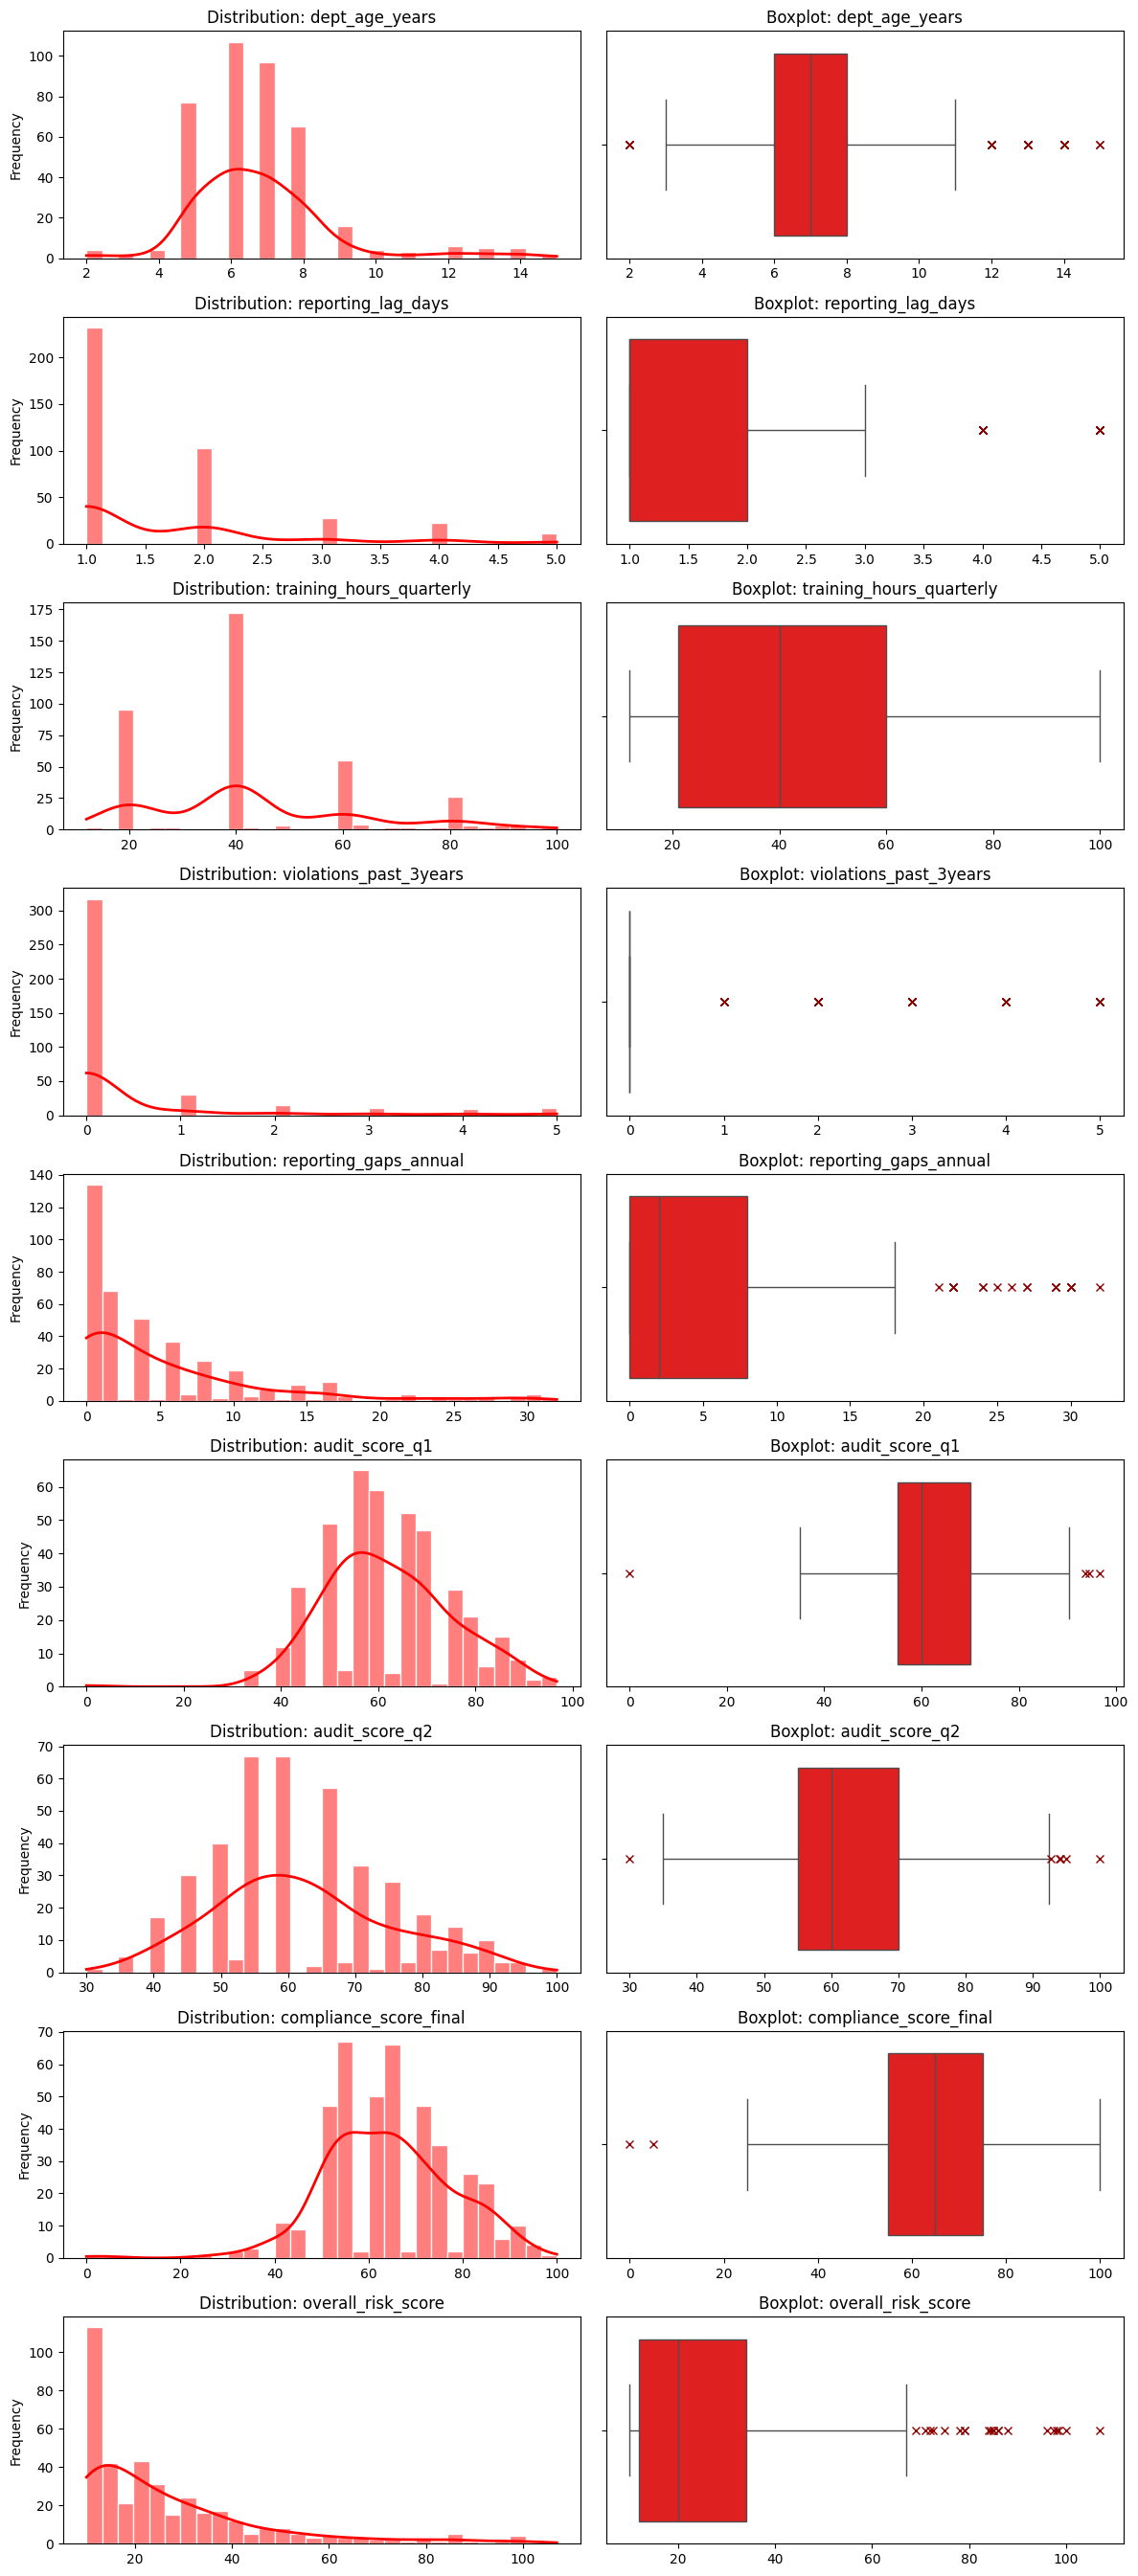

In [53]:
n_rows = len(continuous_cols)
n_cols = 2 # 1 for histogram 1 for boxplot

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))

for i, col in enumerate(continuous_cols):
    data_to_plot = pd.to_numeric(departments_imp[col], errors='coerce').dropna()

    if not data_to_plot.empty:
        ax_hist = axes[i, 0]
        sns.histplot(
            data_to_plot,
            kde=True,
            bins=30,
            ax=ax_hist,
            color='red',
            edgecolor="white",
            line_kws={'color': 'darkred', 'linewidth': 2}
        )
        ax_hist.set_title(f'Distribution: {col}', fontsize=12)
        ax_hist.set_xlabel('')
        ax_hist.set_ylabel('Frequency')

        ax_box = axes[i, 1]
        sns.boxplot(
            x=data_to_plot,
            ax=ax_box,
            color='red',
            flierprops={"marker": "x", "markeredgecolor": "darkred"}
        )
        ax_box.set_title(f'Boxplot: {col}', fontsize=12)
        ax_box.set_xlabel('')
    else:
        axes[i, 0].set_title(f'{col} (No Data)')
        axes[i, 0].set_visible(False)
        axes[i, 1].set_visible(False)

plt.tight_layout()

plt.show()

### Interpretation
The histograms and boxplots show clear patterns in the data.

When looking at the data, we see some common patterns:  
- **dept_age_years**: Most departments are between 6 to 9 years old, with few very young or very old departments.

- **reporting_lag_days**: Most departments report in 1 day, with only a few taking longer, showing that most departments are good at reporting on time.

- **training_hours_quarterly**: There are groups of departments that train for about 20, 40, and 60 hours, indicating different training practices.

- **violations_past_3years**: Almost all departments have no violations, with only a few having any.This means violations are very rare.

- **reporting_gaps_annual**: Most departments have no reporting gaps, with only a few having issues.

- **audit_score_q1 and audit_score_q2**: Most scores are between 55-70, with Q2 scores being even more consistent.

- **overall_risk_score**: Many departments have low risk, with fewer having higher risk.

**Main Point From Boxplots**  
In the boxplots there is a very strong presence of outliers

The one that stands out the most is **violations_past_3years**; as most departments have zero violations, any department with violations is an outlier. Because of this, using the **mean** would artificially inflate the central tendency and misrepresent the normal behavior of most departments.

Similar pattern also appears in **reporting_gaps_annual** and **overall_risk_score**, where a minority of departments exhibit exceptionally poor performance. These extreme values reflect the high-risk behavior, and should not influence the imputation of missing values.
Also **reporting_gaps_annual** and **overall_risk_score** show departments that perform exceptionally poorly.

Outliers in this dataset are signal, not noise, and they highlight meaningful compliance deviations.

### Why Median Imputation Is the Correct Choice
Median imputation is preferred precisely because:
- it is robust to outliers,
- it does not shift toward extreme values,
- t preserves the empirical distribution.

Median imputation offers both statistical stability and semantic correctness for this dataset, where outliers are significant but not indicative of the majority.



### 7.8 Median Imputation for Continuous Features

In [54]:
for col in continuous_cols:
    median_val = departments_imp[col].median()
    departments_imp[col] = departments_imp[col].fillna(median_val)
    print(f"Imputed {col} with median = {median_val}")

Imputed dept_age_years with median = 7.0
Imputed reporting_lag_days with median = 1.0
Imputed training_hours_quarterly with median = 40.0
Imputed violations_past_3years with median = 0.0
Imputed reporting_gaps_annual with median = 2.0
Imputed audit_score_q1 with median = 60.0
Imputed audit_score_q2 with median = 60.0
Imputed compliance_score_final with median = 65.0
Imputed overall_risk_score with median = 20.0


As clearly demonstrated above, since they represent the EDA's operational “norm” and are not influenced by the small number of extremely risky departments, the data are perfectly in line with the EDA's past performance.

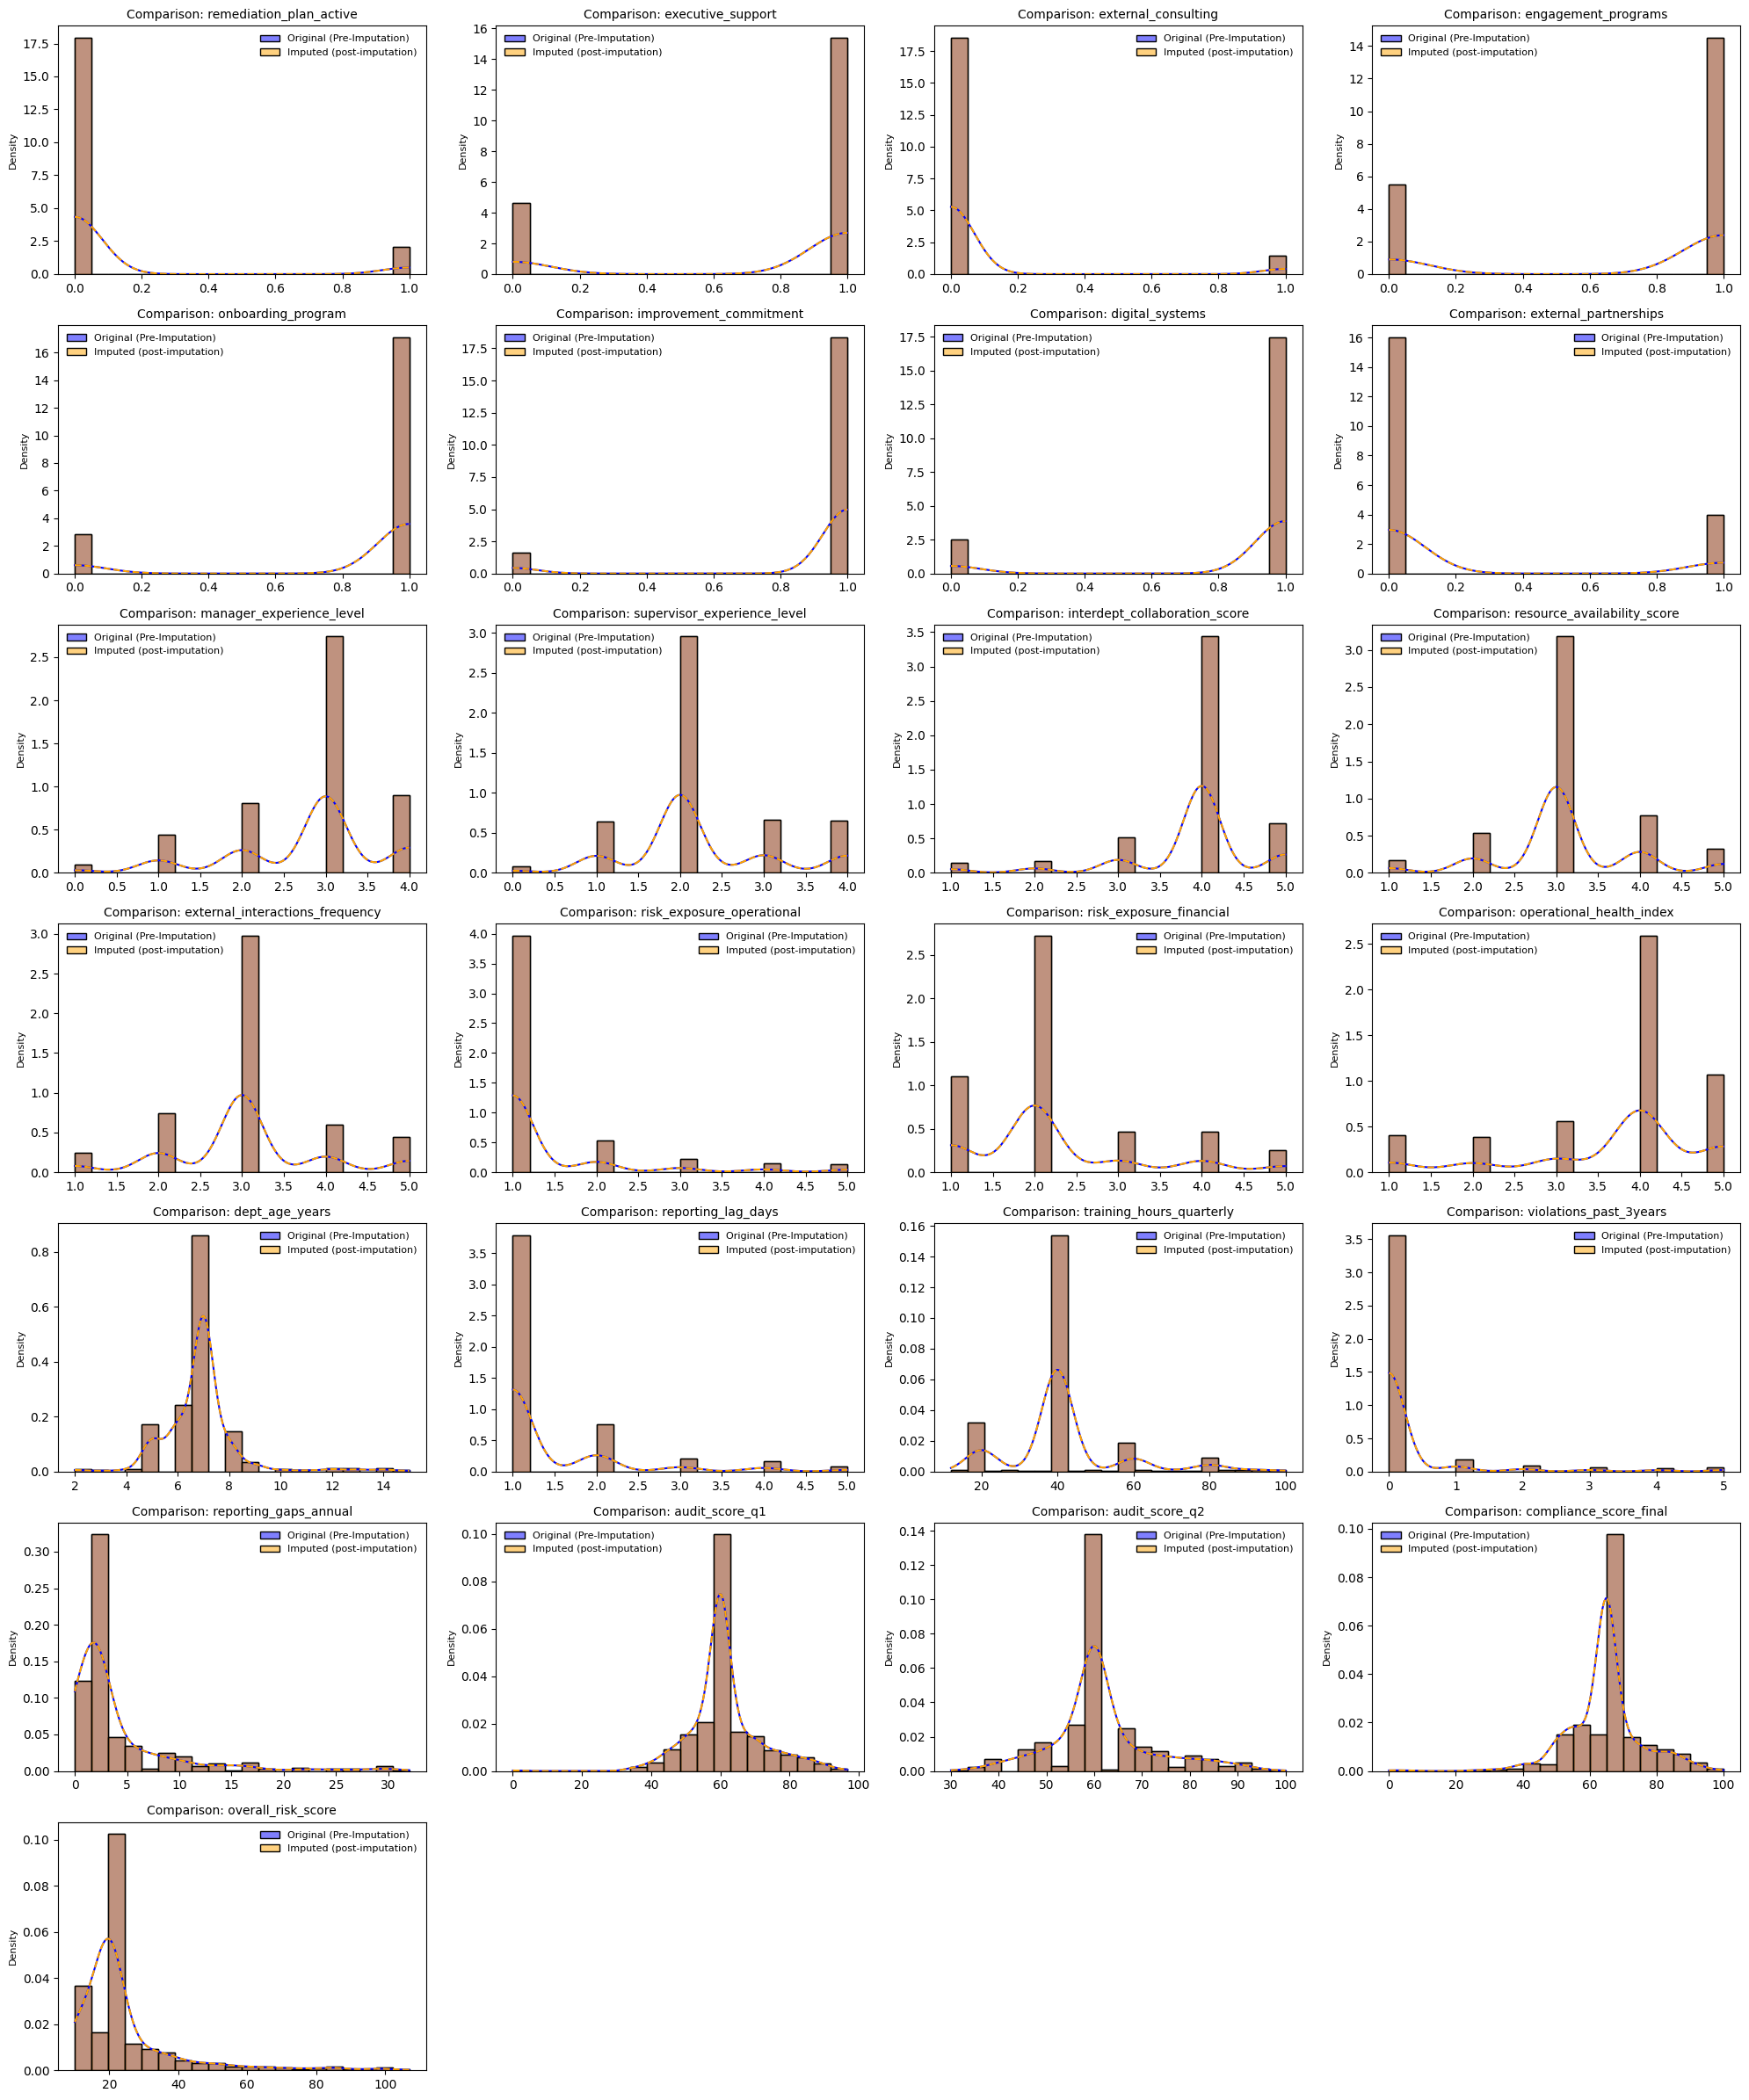

In [55]:
all_numerical_cols = binary_cols + ordinal_cols + continuous_cols

grid_cols = 4
grid_rows = 7
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(20, 24))
axes = axes.flatten()

for i, col in enumerate(all_numerical_cols):

        data_before = departments_imp[col].dropna()

        data_after = departments_imp[col]

        sns.histplot(data_before, color='blue', label='Original (Pre-Imputation)',
                     kde=True, stat="density", ax=axes[i], bins=20)

        sns.histplot(data_after, color='orange', label='Imputed (post-imputation)',
                     kde=True, stat="density", ax=axes[i], bins=20,
                     line_kws={'linestyle':'dashed'})

        axes[i].set_title(f'Comparison: {col}', fontsize=10)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Density', fontsize=8)

        legend = axes[i].legend(fontsize=8)
        if legend:
            legend.get_frame().set_edgecolor('none')
for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

plt.tight_layout()


plt.show()

### **Interpretation**

### Understanding Pre- and Post-Imputation Distributions

The comparison charts show, for each number-based feature, the data distribution before imputation (in red) and after imputation (in blue). The aim is to check that our imputation method:
- Keeps the original statistical pattern,
- Does not change feature distributions,
- And maintains realistic values for modeling.

The charts reveal that there is a strong overlap between the red (original) and blue (imputed) lines, which means the imputation method has not changed the data's basic distribution.


**1. Binary Features (0/1 Values)**

The graphs of ***remediation_plan_active, executive_support, engagement_programs or digital_systems etc. shows key features***. First their binary features only have two values: 0 and 1. The imputed distribution matches the original perfectly because we used mode imputation (the most common value). Many of these features show a peak at 1 (or 0), showing common or rare controls.

This highlights that the mode imputation keeps:
- The original balance between 0 and 1,
- The general patterns in the organization,
- And does not create unusual behaviors.

This shows that **mode imputation** is the right choice for binary indicators.


**2. Ordinal Features (1–5 Scales)**

The graphs of ***manager_experience_level, interdept_collaboration_score, resource_availability_score, risk_exposure_operational or risk_exposure_financial*** shows that ordinal features often have high points around the middle values (3–4). The distributions before and after imputation are almost identical. Finally this proves that median imputation keeps the order and does not skew scores.

This highlights that the median imputation:
- Keeps the rank order,
- Avoids distortion from outliers,
- And keeps scores realistic.

It respects the rules of ordinal scoring.


**3. Continuous Operational Features**

The graphs of ***dept_age_years, reporting_lag_days, training_hours_quarterly, overall_risk_scorem*** show clear patterns that support our method.


**3.1 Right-Skewed Features**

Some features start high on the left and drop off quickly:
- reporting_lag_days
- violations_past_3years
- reporting_gaps_annual
- overall_risk_score

This highlights that most departments perform well (few delays, few violations), with only a few performing poorly.

The graohs highlights this by the red and blue curves that have the same right-skewed shape. While imputation did not change the center of the distribution or create fake “bad departments.”
This is important for fairness and accuracy.


**3.2 Presence of Strong Outliers**

Outliers are strongy highlighted in ***violations_past_3years*** (most values are 0, so any violation is an outlier), ***reporting_gaps_annual and overall_risk_score***.

Our median-based imputation:
- Ignores extreme values,
- Keeps the center stable,
- Does NOT pull imputed values toward outliers.

The plots confirm this: blue curves closely match red curves.


**3.3 Stable, Predictable Central Distributions**

Features like:
- dept_age_years
- training_hours_quarterly
- audit_score_q1 and audit_score_q2
- compliance_score_final

have clear peaks like in ***manager_experience_level*** at around 3–4, ***training_hours_quarterly*** at around 40 hours, or the ***audit scores*** at around 55–70.

This highlights that the medians used for imputation fall within these peaks, so the imputed data aligns with the natural shape of the feature.


**4. Conclusion**

The imputation method worked well.

Across all features:
- The post-imputation (blue) distribution fully matches the original (red).
- No fake spikes, dips, or shifts appear.
- There are no changes in variance or central tendency.

Why this matters for modeling:
Good, distribution-preserving imputation:
- Avoids data leakage,
- Prevents artificial patterns,
- Keeps the risk prediction model reliable and fair,
- Maintains the real behavior of the organization.

Our imputation strategy keeps the statistical and governance structure of the dataset intact, ensuring high-quality input for the Compliance Radar model.

### 7.10 Dealing with Missing Values in Categorical Features  

After filling in missing values for binary, ordinal, and continuous variables, the next step is to take care of missing values in categorical columns.

The missing data in this dataset is not random, it usually shows where there are gaps in records or confusion in the organization.

So, instead of removing rows or guessing categories, we label them as, **“Missing”**, as this helps the model understand that the missing data might indicate a risk of non-compliance.

In [56]:
departments_imp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 682 entries, 0 to 708
Data columns (total 72 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   dept_id                                       682 non-null    object 
 1   dept_name                                     682 non-null    object 
 2   dept_category                                 682 non-null    object 
 3   division                                      438 non-null    object 
 4   dept_type                                     397 non-null    object 
 5   dept_age_years                                682 non-null    float64
 6   location_type                                 395 non-null    object 
 7   team_size                                     393 non-null    object 
 8   reporting_structure                           398 non-null    object 
 9   manager_experience_level                      682 non-null    float64


### Interpretation
Since **dept_id** and **dept_name** are identifiers, we do not include them. Every other column of an object type is categorical.
To maintain the dataset's completeness and significance, missing values are substituted with **"Missing"**. The last check verifies that there are now no missing values in any of the categorical variables.

### 8.Feature Engineering Configuration: Categorical Imputation Complete

Before starting Feature Engineering, let's complete the pre-processing of categorical variables.

In [57]:
id_cols = ["dept_id", "dept_name"]

categorical_cols = [
    col for col in departments_imp.select_dtypes(include="object").columns
    if col not in id_cols
]

print("Categorical columns to encode:")
print(categorical_cols)

#Impute missing values with the explicit label "Missing"
departments_imp[categorical_cols] = departments_imp[categorical_cols].fillna("Missing")# impute the NaN with missing

print("\nCheck remaining NaN in categorical columns:")
print(departments_imp[categorical_cols].isnull().sum()) #sanity check

Categorical columns to encode:
['dept_category', 'division', 'dept_type', 'location_type', 'team_size', 'reporting_structure', 'primary_function', 'secondary_function', 'creation_reason', 'oversight_body']

Check remaining NaN in categorical columns:
dept_category          0
division               0
dept_type              0
location_type          0
team_size              0
reporting_structure    0
primary_function       0
secondary_function     0
creation_reason        0
oversight_body         0
dtype: int64


All categorical columns are identified, except for IDs ***(dept_id, dept_name)***.

The term **“Missing”** is used instead of missing values.

This method preserves missing values as information, which is crucial in this dataset because:
- Lower governance quality is often correlated with a lack of documentation.
- This signal should be captured by the model.

All categorical variables have zero missing values after imputation.

### 9. Feature Engineering: Composite Indicators with a Risk Focus

We develop a collection of engineering features that summarize **governance quality, operational complexity, behavioral risk, and documentation discipline** in order to assist the model in identifying the minority ***at-risk class***.

In [58]:
# Governance support index (bianary  support features mean) to evaluate the strenght of the organizational help
gov_cols = ["executive_support","remediation_plan_active","improvement_commitment","engagement_programs","onboarding_program","digital_systems"]
departments_imp["governance_support_index"] = departments_imp[gov_cols].mean(axis=1)

# operational complexity (operetional risk * external interactions) help to evaluate the complexity of the department's operation
departments_imp["operational_complexity"] = (departments_imp["risk_exposure_operational"] * departments_imp["external_interactions_frequency"])

# Audit trend: Trend of the audit scores
departments_imp["audit_trend"] = (departments_imp["audit_score_q2"] - departments_imp["audit_score_q1"])

# Experience gap: experience gap between the manager and the supervisor
departments_imp["experience_gap"] = (departments_imp["manager_experience_level"] - departments_imp["supervisor_experience_level"])

# Training effect: evaluate the training efficencies
departments_imp["training_efficiency"] = (departments_imp["training_hours_quarterly"] / (1 + departments_imp["violations_past_3years"]))

# Risk gap: evaluate the gap between the departments operational risk and the departments resilience
departments_imp["risk_gap"] = (departments_imp["risk_exposure_operational"] - departments_imp["operational_health_index"])

# Risk intensity: join operational risk and the number of violations. It amplify the magnitude of the overall risk
departments_imp["risk_intensity"] = (departments_imp["risk_exposure_operational"] * (1 + departments_imp["violations_past_3years"]))

# Control failure ratio: number of relations related to the governance support.
departments_imp["control_failure_ratio"] = (departments_imp["violations_past_3years"] / (departments_imp["governance_support_index"] + 1))

# Risk to capacity: ratio between operational risk and health. Introduce non-linear relationship between the two features.
departments_imp["Risk_to_capacity"] = (departments_imp["risk_exposure_operational"] /(departments_imp["operational_health_index"] + 1))

# Training gap: Operational complexity related to the hours of training
departments_imp["training_gap"] = (departments_imp["operational_complexity"] / (departments_imp["training_hours_quarterly"] + 1))

# Reporting discipline: sum of annula reporting gap and delays evaluate the operation efficency(divide by 10 to normalize the scales)
departments_imp["reporting_discipline"] = (departments_imp["reporting_gaps_annual"] + departments_imp["reporting_lag_days"] / 10.0)

#Support utilization: how well the support is used
departments_imp["support_utilization"] = (departments_imp["governance_support_index"] /(departments_imp["violations_past_3years"] + 1))

#Governance weakness flag: Binary feat. Measure whether there is any support or improvement
departments_imp["governance_weakness_flag"] = (((departments_imp["executive_support"] == 0) & (departments_imp["improvement_commitment"] == 0))).astype(int)

#Exposure-capacity mismatch: relation between risk exposure and resource availability
departments_imp["exposure_capacity_mismatch"] = (departments_imp["risk_exposure_operational"] /(departments_imp["resource_availability_score"] + 1))

#Collaboration risk amplifier: measure the relation between the external interactions frequency and the quality of collaboration across departments
departments_imp["collab_risk_amplifier"] = (departments_imp["external_interactions_frequency"] / (departments_imp["interdept_collaboration_score"] + 1)
)

#Behavior risk index: sum of violations and reporting gaps and delays. reveal risky paths
departments_imp["behavior_risk_index"] = (departments_imp["violations_past_3years"] +departments_imp["reporting_gaps_annual"] +departments_imp["reporting_lag_days"] / 10.0)

#Process maturity: sum of systems and programs to evaluate the "maturity" of a process
departments_imp["process_maturity"] = (departments_imp["digital_systems"] +departments_imp["onboarding_program"] +departments_imp["engagement_programs"])

#Resource stress: measure the complexity related to the resources
departments_imp["resource_stress"] = (departments_imp["operational_complexity"] / (departments_imp["resource_availability_score"] + 1))

# 3.11 Audit volatility: absoulut variations between Q1 and Q2
departments_imp["audit_volatility"] = ((departments_imp["audit_score_q2"] - departments_imp["audit_score_q1"]).abs())

engineered_features = [
    "audit_trend", "experience_gap","training_efficiency",
    "risk_gap", "risk_intensity", "control_failure_ratio", "Risk_to_capacity",
    "training_gap", "reporting_discipline",
    "support_utilization", "governance_weakness_flag", "exposure_capacity_mismatch",
    "collab_risk_amplifier", "behavior_risk_index", "process_maturity",
    "resource_stress", "audit_volatility"]

print(c for c in engineered_features if c not in departments_imp.columns())

<generator object <genexpr> at 0x0000028826D46DC0>



We group the engineered features into **three main areas** to support the Compliance Radar model. Each area shows different parts of how departments behave and how well they follow rules.

1. Governance & Support Strength: Features like ***governance_support_index, process_maturity, support_utilization, governance_weakness_flag, and control_failure_ratio*** measure how organized the support is and how well it prevents problems.

2. Complexity and Operational Risk: Features such as ***operational_complexity, risk_gap, risk_intensity, risk_to_capacity, resource_stress, exposure_capacity_mismatch, collab_risk_amplifier, training_gap*** show how challenging the environment is and whether there are enough resources.

3. Conduct and Records Quality: Features like ***audit_trend, audit_volatility, experience_gap, training_efficiency,reporting_discipline, behavior_risk_index*** summarize department behavior over time in areas like training, reporting, audits, and violations.

These features combine many raw signals into clear indicators that are easier for compliance teams to understand and for the model to use.

### 10. Identification and Prevention of Leak  

We do a leakage check on variables that may directly encode the final risk assessment prior to training the Compliance Radar.

In [59]:
suspect_cols = ["compliance_score_final", "overall_risk_score", "audit_score_q1", "audit_score_q2"]

suspect_flags = ["compliance_score_final_missing_flag", "overall_risk_score_missing_flag", "audit_score_q1_missing_flag", "audit_score_q2_missing_flag"]

# Correlation of suspect features with the target
feat_corr = departments[suspect_cols + ["is_at_risk"]].corr()["is_at_risk"].sort_values(ascending=False)

# Correlation of missingness flags with the target
flag_corr = departments_imp[suspect_flags + ["is_at_risk"]].corr()["is_at_risk"].sort_values(ascending=False)

print(feat_corr,'\n')
print(flag_corr)

is_at_risk                1.000000
overall_risk_score        0.494484
audit_score_q1           -0.403527
audit_score_q2           -0.431958
compliance_score_final   -0.526673
Name: is_at_risk, dtype: float64 

is_at_risk                             1.000000
overall_risk_score_missing_flag       -0.407273
audit_score_q1_missing_flag           -0.432545
compliance_score_final_missing_flag   -0.449060
audit_score_q2_missing_flag           -0.449170
Name: is_at_risk, dtype: float64


### 11. Data Leakage Analysis
This section aims to see if any variables, especially those recorded after checking compliance, might accidentally show the risk category.

If a feature acts like the label instead of a predictor, it causes data leakage and should be removed or changed.

We evaluate leakage in **four steps**:
1. Analysis of missingness patterns for risk-related variables
2. Analysis of the distributions of risk-related variables by class
3. Analysis of missing flags for the same variables
4. Leakage testing on engineered features

#### 11.1 Missingness Patterns in Risk-Related Variables
We looked at whether some variables recorded after evaluation might reveal information about the final risk rating.

Specifically, we examined the missing data patterns in these fields:
- ***compliance_score_final***
- ***overall_risk_score***
- ***audit_score_q1***
- ***audit_score_q2***

Since these variables directly reflect performance or risk results, if their missing data rates vary a lot between **high-risk** and **low-risk** departments, they could unintentionally reveal the risk level.

In [60]:
for col in suspect_cols:
    print(f"\n>>> {col}")
    print("Overall missing rate :", departments[col].isna().mean())
    print(
        departments.groupby("is_at_risk")[col]
        .apply(lambda s: s.isna().mean())
        .rename("missing_rate_by_class")
    )


>>> compliance_score_final
Overall missing rate : 0.39002932551319647
is_at_risk
0    0.53112
1    0.05000
Name: missing_rate_by_class, dtype: float64

>>> overall_risk_score
Overall missing rate : 0.4222873900293255
is_at_risk
0    0.551867
1    0.110000
Name: missing_rate_by_class, dtype: float64

>>> audit_score_q1
Overall missing rate : 0.39296187683284456
is_at_risk
0    0.529046
1    0.065000
Name: missing_rate_by_class, dtype: float64

>>> audit_score_q2
Overall missing rate : 0.3841642228739003
is_at_risk
0    0.524896
1    0.045000
Name: missing_rate_by_class, dtype: float64


An analysis of the four risk-related fields reveals a clear picture: **low-risk departments** have missing values much more often than **high-risk departments**.
Overall, about **40%** of the data is missing for each field, but this figure varies depending on the group.
High-risk departments have low rates of missing data, usually **less than 15%**, while **low-risk departments** have over **50% missing data**.
For example, only **11%** of **high-risk departments** have a recorded overall risk score, compared to about **55%** of **low-risk departments**.

This shows that missing data is not random. High-risk departments fill out more documents because they are subject to regular checks. Low-risk departments are checked less often, which leads to many empty fields. In other words, the presence or absence of a value already provides clues about the department's risk level.

These variables can reveal the level of risk because missing data reflects how closely the department is monitored. Even without using exact numbers, a model could learn that ***“missing”*** means **low risk** and ***“present”*** means **high risk**. Therefore, these variables must be handled with care. Raw scores are less useful than indicators that show whether data is missing, the “_missing_flag” characteristics. If raw scores seem too predictive, they should be revised or removed.

Careful handling of these variables ensures that the model learns the real reasons behind risk rather than simply copying the organization’s audit patterns.

#### 11.2 Distribution of Risk-Related Variables by Risk Class
To check if key audit and compliance metrics reveal information about the target variable (is_at_risk), we look at how these metrics differ between risk groups.

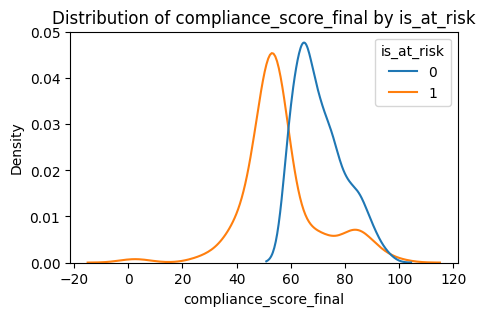

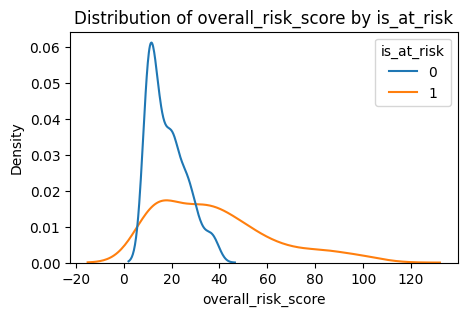

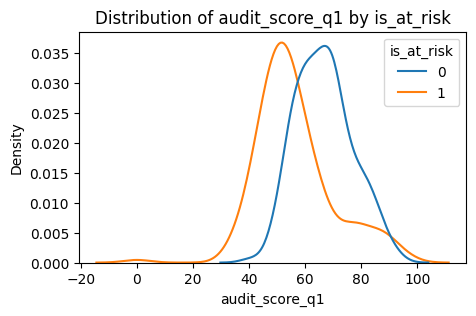

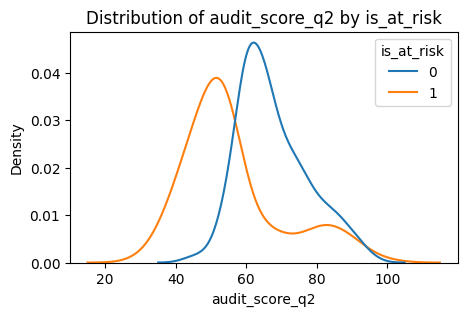

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in suspect_cols:
    plt.figure(figsize=(5,3))
    sns.kdeplot(data=departments, x=col, hue="is_at_risk", common_norm=False)
    plt.title(f"Distribution of {col} by is_at_risk")
    plt.show()

### Interpretation

The KDE plots show a clear difference between **low-risk** and **high-risk** departments in compliance scores, overall risk scores, and audit_scores_q1 and audit_scores_q2. This suggests these metrics act more like outcome labels than independent predictors. **High-risk** departments have ***lower compliance*** scores around 50-60, while **low-risk** ones score ***higher*** around 65-75. Overall risk scores for low-risk departments cluster tightly between 10-20, whereas high-risk departments have a wider range, showing a direct link to risk levels.

Audit scores show the same pattern: **high-risk departments** consistently get lower scores (Q1 mid-40s to mid-50s, Q2 similar), meaning these scores reflect evaluation results rather than causes of risk. The almost complete separation in these distributions means the model could predict risk almost perfectly using them, causing data leakage.

The missing data analysis supports this—high-risk departments always recorded these scores, while low-risk ones did so less often. Because these features depend heavily on past evaluations, they are not good for prediction as they can misrepresent true performance and reduce the model’s ability to generalize.

Therefore, features like ***compliance_score_final, overall_risk_score, audit_score_q1, and audit_score_q2*** should be left out of modeling to avoid leakage; only indicators showing if data is missing should be kept to track monitoring behavior. Future models should also check feature importance carefully to prevent indirect leakage through related features.

#### 11.3 Distribution of Missing Flags
Even without the original values, the missing flags still show the same monitoring pattern.

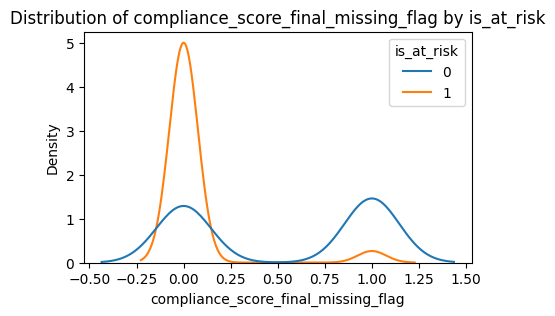

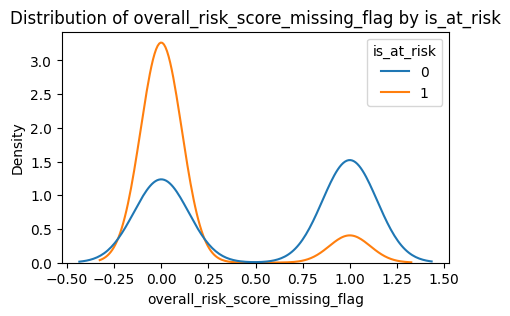

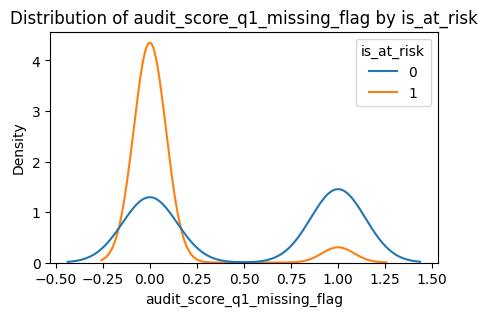

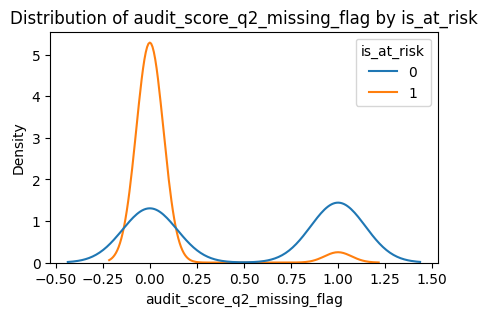

In [62]:
for col in suspect_flags:
    plt.figure(figsize = (5,3))
    sns.kdeplot(data = departments_imp, x = col, hue = "is_at_risk", common_norm = False)
    plt.title(f"Distribution of {col} by is_at_risk")
    plt.show()

### Interpretation

The **KDE plots** for missingness flags show a clear link between having documentation and compliance risk.

**High-risk departments** mostly have a value of zero for these flags, meaning their scores are available. **Low-risk departments** mostly have a value of one, meaning scores are missing.
This shows that **low-risk** units often lack compliance documents, while **high-risk** ones keep regular monitoring. For the final compliance score flag, low-risk departments have a strong peak at one (missing scores), while high-risk ones cluster near zero, showing a clear difference in data.

The overall risk score missing flag follows the same pattern: high-risk departments usually have recorded scores, ***near zero***, and low-risk ones often miss them, ***peak at one***. This suggests missing data is more about regulatory checks than errors.

Similarly, the first and second quarter audit score missing flags show that high-risk units keep audit records, ***peak at zero***, while low-risk units often don’t, ***peak at one***. Overall, these patterns show that missing data reflects how closely departments are monitored, not random gaps. Missing values here mean a department isn’t under strict review, matching low-risk status.

Therefore, it’s important to treat these flags carefully—they are key indicators of risk through governance and should be kept as features, but the actual raw values should be removed to avoid biasing results.

#### 11.4 Leakage Test on Engineered Features

To ensure the newly engineered features do not encode the target accidentally, we computed their correlations with is_at_risk.

In [63]:
departments_imp[engineered_features + ["is_at_risk"]].corr()["is_at_risk"].sort_values(ascending = False)

is_at_risk                    1.000000
control_failure_ratio         0.437072
risk_intensity                0.413973
Risk_to_capacity              0.411826
training_gap                  0.389349
exposure_capacity_mismatch    0.382057
behavior_risk_index           0.380654
risk_gap                      0.372063
resource_stress               0.349554
reporting_discipline          0.331993
audit_volatility              0.297605
governance_weakness_flag      0.285883
collab_risk_amplifier         0.160206
audit_trend                  -0.052892
experience_gap               -0.181629
training_efficiency          -0.338841
process_maturity             -0.365659
support_utilization          -0.554072
Name: is_at_risk, dtype: float64

#### 11.5 Engineered Feature Distributions

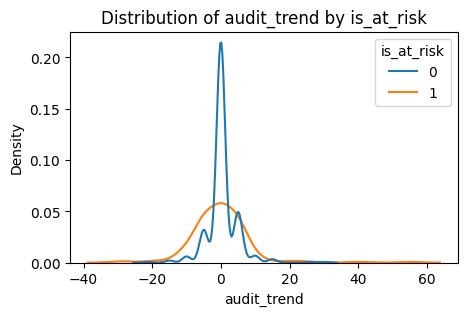

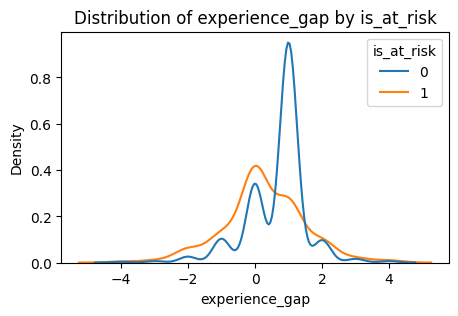

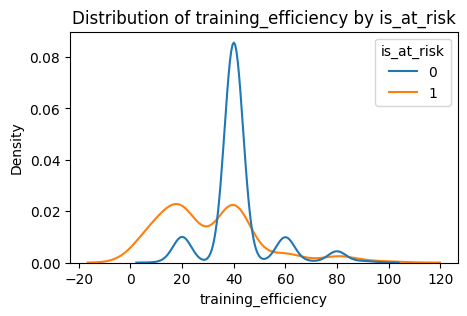

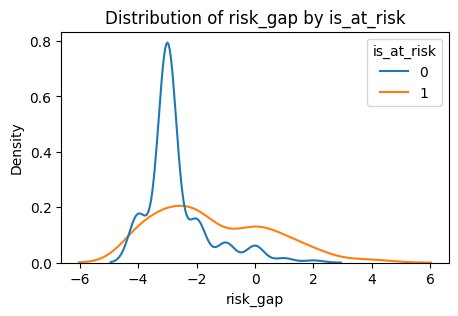

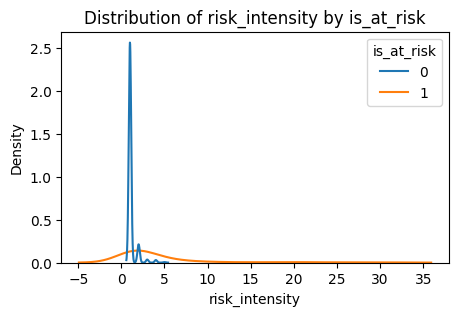

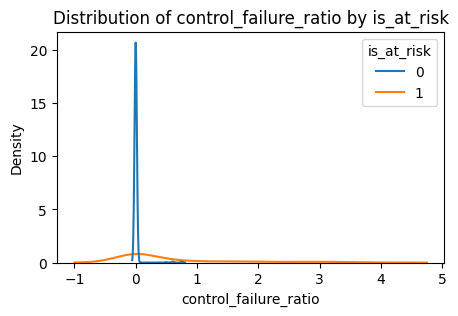

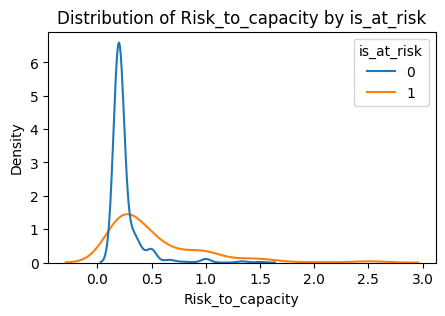

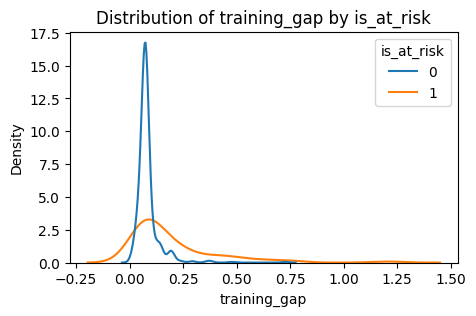

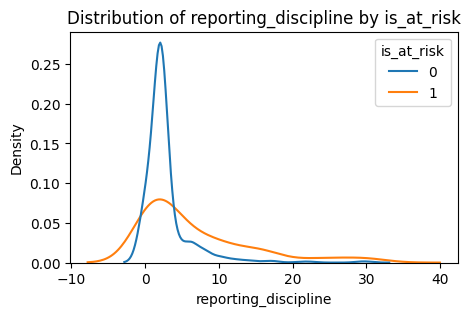

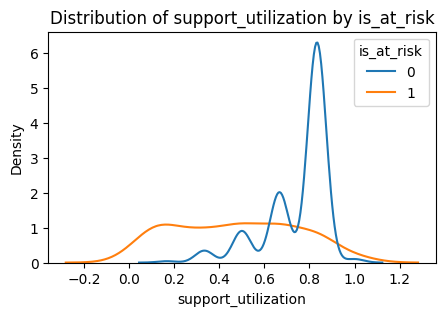

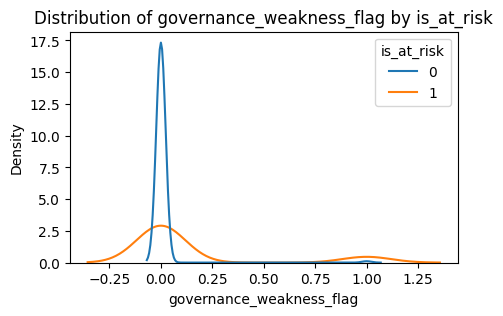

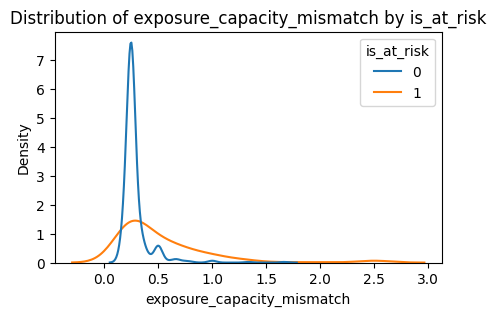

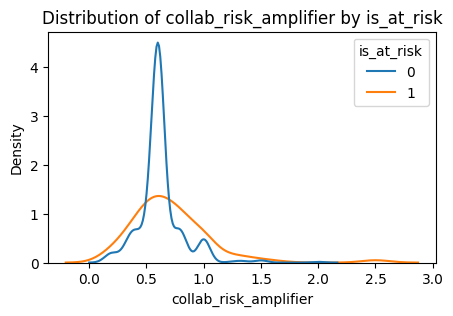

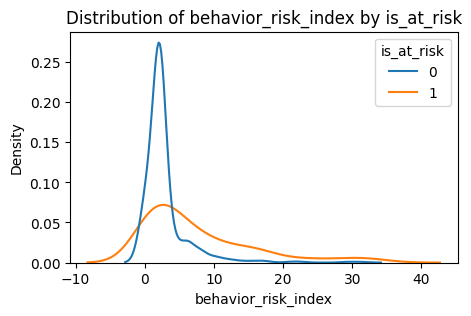

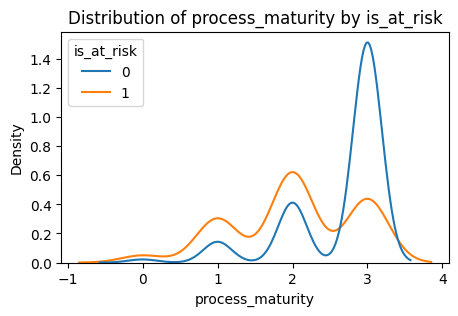

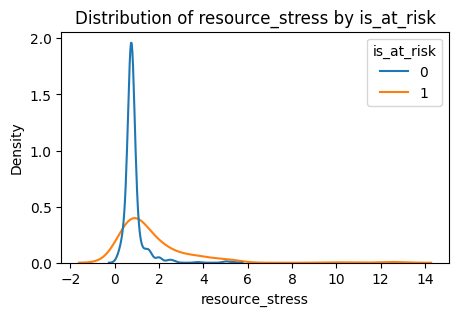

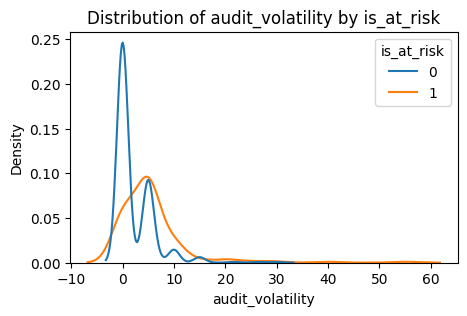

In [64]:
for col in engineered_features:
    plt.figure(figsize = (5,3))
    sns.kdeplot(data = departments_imp, x=col, hue="is_at_risk", common_norm = False)
    plt.title(f"Distribution of {col} by is_at_risk")
    plt.show()

### Interpretation

We examined how engineering features are spread between two types of departments: **high-risk (is_at_risk = 1)** and **low-risk (is_at_risk = 0)** to ensure there are no hidden leaks. These new features do not show the same risky patterns as the earlier ones that could cause leaks. Instead, they overlap a lot, showing differences in structure and behavior without directly showing the risk score.

The KDE charts reveal some patterns. **High-risk departments** usually have wider and more spread out distributions, while **low-risk departments** have peaks around stable or lower risk values for most features. This indicates that processes, reporting, capacity issues, and resource stress are more variable in high-risk departments. Importantly, the distributions overlap a lot, and there is no clear line between the two groups. This is what we want in good predictive features.

For example, the low-risk and high-risk groups share the same range on the x-axis, but features like ***audit_trend, training_efficiency***, and ***reporting_discipline*** show that high-risk departments often have poorer improvements and less consistent reporting. Similarly, ***risk_gap, risk_intensity, and resource_stress*** suggest that high-risk departments face more strain, but low-risk departments can also show similar values, though less often.

Some governance-related features, like ***support_utilization and process_maturity***, show expected trends without leaking information about risk. High-risk units typically have less governance support and weaker process maturity, while low-risk units tend to have higher support and better structure. However, both groups still have overlapping ranges, indicating that these features show real operational differences, not direct evaluations.

Overall, the engineered features work as planned. They describe important aspects like operational complexity and governance strength without directly showing the final risk rating. The distributions reveal useful differences between low-risk and high-risk departments but overlap enough to prevent the model from being unfair. This confirms that the engineered features provide real information instead of leaks, making them good inputs for predictive modeling.

#### 11.6 Leakage Testing on Engineered Features

After checking for major leaks in the raw data, we need to ensure that the features we created wouldn’t cause the same issues.
We looked at correlations to see how each feature related to the risk label to confirm this. If a feature was too similar to the outcome, it would show a **high correlation** with being at risk.

Our results show that the **engineered features** **DO NOT HAVE** dangerous leakage patterns.

Some features, like ***control_failure_ratio and risk_intensity***, naturally **connect to risk**, but their values are within safe limits. They show differences in behavior or structure among departments rather than reflecting past audit results. Their values do not reach the extreme levels we found in the actual leakage variables, and they remain moderate.

Features like ***training_efficiency and process_maturity*** show **both positive and negative** connections to risk. This means that the modified signals show diversity rather than just copying the risk label. The correlations match what we expect: for example, a higher behavior risk index usually means more risk, while better process maturity usually means less risk.

None of the designed features have high enough correlations to shortcut the model. They explain how departments work instead of how they were evaluated. This supports our earlier findings that the engineered features introduce structure, not leakage.

Overall, this validation shows that the designed features are safe. They provide useful information about operations, behavior, and governance without revealing final compliance results. This ensures that the predictive model learns the right signals—true early signs of increasing compliance risk.

### 12. Building the Leak-Free Modeling Dataset

After identifying the leakage variables, we create a clean version of the dataset that excludes them entirely.

In [65]:
# Create a leak-free copy of the dataset
departments_noleak = departments_imp.copy()

# Drop outcome-based scores and their missing flags
departments_noleak = departments_noleak.drop(suspect_cols,axis = 1)
departments_noleak = departments_noleak.drop(suspect_flags,axis = 1)
departments_noleak.info()

<class 'pandas.core.frame.DataFrame'>
Index: 682 entries, 0 to 708
Data columns (total 83 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   dept_id                                       682 non-null    object 
 1   dept_name                                     682 non-null    object 
 2   dept_category                                 682 non-null    object 
 3   division                                      682 non-null    object 
 4   dept_type                                     682 non-null    object 
 5   dept_age_years                                682 non-null    float64
 6   location_type                                 682 non-null    object 
 7   team_size                                     682 non-null    object 
 8   reporting_structure                           682 non-null    object 
 9   manager_experience_level                      682 non-null    float64


This step removes the four outcome variables and their missing_flag columns, leaving us with **83 features** that are safe for modeling.

All remaining variables are either original predictors or engineered features that do not directly encode the final risk evaluation.

### 13. Train–Test Split With Stratified Sampling

Since the dataset is imbalanced, only about **30%** of departments are labeled at risk, we use a stratified **train–test** split.

This keeps the same class proportions in both training and **test sets**.

In [66]:
X = departments_noleak.drop(columns = ['is_at_risk'])
Y = departments_noleak['is_at_risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=54,
    stratify=Y
)

# Check the distribution after split
print("Train distribution:")
print(y_train.value_counts(normalize = True) * 100)

print("\nTest distribution:")
print(y_test.value_counts(normalize = True) * 100)

Train distribution:
is_at_risk
0    70.642202
1    29.357798
Name: proportion, dtype: float64

Test distribution:
is_at_risk
0    70.80292
1    29.19708
Name: proportion, dtype: float64


### 14. Preparing Categorical Variables for Target Encoding

Now we have a correct distribution in both sets.

We will procede with target encoding. Since we have a huge amount of features, all the missing flag that preserve the missing signal, we don't want to add other columns like in the 1 hot encoding case. Because the risk of overfitting would increase.

In [67]:
# All object columns
cat_all = X_train.select_dtypes(include = 'object').columns.tolist()
print("All object cols:", cat_all)

id_cols = ['dept_id', 'dept_name']

cat_cols = [c for c in cat_all if c not in id_cols]
print("Categorical columns for target encoding:", cat_cols)

All object cols: ['dept_id', 'dept_name', 'dept_category', 'division', 'dept_type', 'location_type', 'team_size', 'reporting_structure', 'primary_function', 'secondary_function', 'creation_reason', 'oversight_body']
Categorical columns for target encoding: ['dept_category', 'division', 'dept_type', 'location_type', 'team_size', 'reporting_structure', 'primary_function', 'secondary_function', 'creation_reason', 'oversight_body']


#### 14.1 Logic for Target Encoding (Train Set Only)

We introduce for each categorical column (col) and  for every category value a **smoothed target encoding**:

$TE(\text{category}) = \frac{n_c \cdot mean_c + \alpha \cdot global\_mean}{n_c + \alpha}$

- n_c is the number of records in the train set that fall into that category;
- mean_c is the average of is_at_risk for that category.
- global_mean = the train set's overall mean of is_at_risk (≈ 0.30)
- α is the smoothing parameter, such as 10.

Because encodings are only learnt from the train set and then applied to both **train and test**, this method decreases overfitting, stabilises unusual categories by bringing them towards the global mean, and prevents leaking.

### 14.2 Implementation in Code

In [68]:
def target_encode_column(train_col, y_train, test_col, alpha = 10.0):
    """
    train_col: Pd.series with categorical features in train set
    y_train:   training target
    test_col:  Pd.series same as train_col but in test set
    alpha:     smoothing factor
    """
    global_mean = y_train.mean() #train global mean

    stats = (pd.DataFrame({'col': train_col, 'y': y_train}).groupby('col')['y'].agg(['mean', 'count']))

    smooth = (stats['mean'] * stats['count'] + global_mean * alpha) / (stats['count'] + alpha)

    stats['te'] = smooth

    # Mapping train
    train_te = train_col.map(stats['te']).fillna(global_mean)
    # Mapping test
    test_te = test_col.map(stats['te']).fillna(global_mean) #some categories might not exist in test set

    return train_te, test_te, stats, global_mean

### 14.3 Why Target Encoding (and how EDA supports it)

The analysis reveals significant changes in the likelihood of being classified as at risk, based on various categories. **Target encoding** is identified as the most effective method, with departments like Risk Management associated with **high-risk** scenarios, while Operational Compliance aligns with low-risk situations.

Additionally, Corporate HQ displays markedly **lower risk** levels compared to Regional Operations, with other influencing factors including location, team size, and reporting structures also exThe reasoning behind why target encoding is important (and how EDA can help)

The EDA indicates that the likelihood of being at risk is different significantly among.
numerous nominal dimensions:

- at-risk rates are far greater in such departments as the *Risk Management* or other departments.
Although such domains as *Operational Compliance* are less likely to cause risks;
- *Corporate HQ* is likely to look safer than regional or operation divisions;
- other nominal attributes (location, team size bands, reporting structure, creation
the risk level of reason, oversight body, etc.) also is different.

These trends imply that even category membership is highly risky information.
To add this information to the models, target encoding gives a concise means to inject this information.
category is associated to a smoothed approximation of the at-risk rate on that category.

In comparison to a naive one-hot encoding:

- target encoding leaves the feature space incomparably smaller (one column per variable instead).
of large numbers of dummy columns, as is of importance, because we have a small sample;
- it generates quantities in numbers that can be directly interpreted as risk indicators, and these are effective.
using such models as Logistic Regression and tree-based ones;
- by using a smoothed formula


we stabilise the rare categories (n_c small) by bringing them nearer to the global average,
overfitting and noise reduction.

More importantly, all encodings are only fitted on the training set (X train, y train ).
and subsequently subjected to train and test. This prevents information leakage of the test.
labels and makes sure that the hold-out test set is a fair point of model evaluation.

Another finding presented in the EDA was that certain categories were present in some of the variables including main function, secondary.
function, creation reason and oversight body are relatively uncommon, and the absence of them.
Patterns are systematically different in low and high-risk departments. This reinforces
the choice of:

- with the help of smoothed target encoding to get strong estimates of infrequent categories;
- using missing values and indicators of missingness as two separate and informative features,
extremely similar to surveillance bias.

In general, target encoding provides a sufficient trade-off to this project: it makes things easier.
representation of categorical variables, maintains the important risk signals in.
the EDA, and gives smaller and a modelling-friendly dataset.hibiting varying risk levels.

Traditional one-hot encoding would overlook these critical patterns, complicating the data representation. In contrast, target encoding effectively associates categories with risk estimates, aiding the model in learning from the data. It is essential to calculate encodings **only on the training set** to maintain the integrity of the model, preventing contamination of training and testing data. This ensures a clear distinction and fairness in model evaluation.

The findings indicate that certain categories, particularly in main function, secondary function, creation reason, and oversight body, are infrequent. Rare categories can lead to unreliable estimates, but applying a smoothing method helps stabilize values and reduces noise.

Another key observation is the **correlation** between ***missing values and risk levels***; low-risk departments tend to exhibit more missing information, while high-risk departments generally have complete records. This suggests that missing values might reflect behavioral patterns rather than directly impacting outcomes, allowing for their continued use as informative features.

In conclusion, the insights gathered advocate for target encoding due to its ability to simplify data handling compared to one-hot encoding, preserve essential category signals, and enhance the stability of estimates for rare categories.

Consequently, the dataset is improved for modeling, resulting in a more compact and valuable format.

### 14.4 Applying Target Encoding to All Categorical Columns

In [69]:
X_train_te = X_train.copy() # make a copy to don't touch the original
X_test_te  = X_test.copy()

encoding_stats = {}  # to check the stats

for col in cat_cols:
    train_encoded, test_encoded, stats, global_mean = target_encode_column(
        X_train[col], y_train, X_test[col], alpha=10.0
    )

    new_col = f"{col}_te" #save the new column
    X_train_te[new_col] = train_encoded
    X_test_te[new_col] = test_encoded

    #saving stats for analysis
    encoding_stats[col] = {"global_mean": global_mean, "stats": stats.sort_values("te", ascending=False)}

    print(f"Encoded {col} -> {new_col} (example categories):")
    print(encoding_stats[col]["stats"].head(), "\n")

Encoded dept_category -> dept_category_te (example categories):
                            mean  count        te
col                                              
Risk_Management         0.857143     21  0.675348
Financial_Reporting     0.404908    326  0.401595
Operational_Compliance  0.050505    198  0.062191 

Encoded division -> division_te (example categories):
                         mean  count        te
col                                           
Regional_Operations  0.857143     21  0.675348
Corporate_HQ         0.417910    335  0.414307
Missing              0.010582    189  0.024803 

Encoded dept_type -> dept_type_te (example categories):
                mean  count        te
col                                  
Finance     0.769231     13  0.562425
Operations  0.553571    112  0.532260
Legal       0.615385     13  0.475469
Technology  0.384615     13  0.345034
Support     0.339394    165  0.336776 

Encoded location_type -> location_type_te (example categories):
     

### 14.5 Removing Original Categorical Columns

After encoding, the original categorical values and ID columns are removed:

In [70]:
X_train_te = X_train_te.drop(columns = cat_cols + id_cols)
X_test_te = X_test_te.drop(columns = cat_cols + id_cols)

print("Final train shape:", X_train_te.shape)
print("Final test shape:", X_test_te.shape)

Final train shape: (545, 80)
Final test shape: (137, 80)


This gives us a feature set that is entirely numeric and devoid of leakage, which consists of:
- original numerical features;
- missing flags; and
- engineered features.
- categorical features encoded in the target

All set to train a robust model.


### 15. Logistic Regression: Baseline Linear Model

After cleaning the dataset, removing leakage, imputing missing values, and applying target encoding, we now train our first baseline predictive model: Logistic Regression.

- We use the **imputed and target-encoded dataset** (`X_train_final`, `X_test_final`) built in the previous steps.
- We **standardize numeric features** because Logistic Regression is sensitive to feature scale.
- We set `class_weight='balanced'` to deal with the **class imbalance** identified in the EDA  
  (~30% of departments are classified as `is_at_risk = 1`).


### 15.1 Preparing the Final Training Data

We start from the target-encoded datasets X_train_te and X_test_te and define our final feature matrices:

In [71]:
X_train_final = X_train_te
X_test_final  = X_test_te

print("Train shape:", X_train_final.shape)
print("Test shape:", X_test_final.shape)

Train shape: (545, 80)
Test shape: (137, 80)


### 15.2 Standardizing Numerical Features

Scale has an impact on logistic regression. As a result, every numerical column is standardised.

The standard deviation is 1, while the mean is 0.

This increases optimisation stability and keeps large-scale variables from controlling coefficients.

In [72]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled  = scaler.transform(X_test_final)

X_train_scaled.shape, X_test_scaled.shape

((545, 80), (137, 80))

### 15.3 Hyperparameter Search with Cross-Validation

We set up a Pipeline containing Logistic Regression with:
- class_weight = ***"balanced"*** to correct the class imbalance
- solver = ***"liblinear"*** for compatibility with L1 and L2 penalties
- up to 1000 iterations to guarantee convergence

We tune the hyperparameters C (regularization strength) and penalty (L1 or L2) using a cross-validated grid search:

In [73]:
logreg_pipe = Pipeline(steps=[
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="liblinear" ))])

param_grid = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty": ["l1", "l2"],
}

results = []

for n in range(3, 11):  # CV from 3 to 10 fold
    cv = StratifiedKFold(n_splits = n, shuffle = True, random_state = 54)

    grid = GridSearchCV(
        estimator = logreg_pipe,
        param_grid = param_grid,
        scoring = "roc_auc",
        cv = cv,
        n_jobs = -1,
        verbose = 0
    )

    grid.fit(X_train_final, y_train)
    results.append({
        "n_splits": n,
        "best_auc": grid.best_score_,
        "best_params": grid.best_params_
    })

# Print summary
for r in results:
    print(f"{r['n_splits']}-fold: AUC={r['best_auc']:.4f}, params={r['best_params']}")

3-fold: AUC=0.8858, params={'model__C': 1, 'model__penalty': 'l2'}
4-fold: AUC=0.8868, params={'model__C': 0.01, 'model__penalty': 'l2'}
5-fold: AUC=0.8906, params={'model__C': 0.1, 'model__penalty': 'l2'}
6-fold: AUC=0.8925, params={'model__C': 0.1, 'model__penalty': 'l2'}
7-fold: AUC=0.8978, params={'model__C': 0.1, 'model__penalty': 'l2'}
8-fold: AUC=0.8935, params={'model__C': 1, 'model__penalty': 'l1'}
9-fold: AUC=0.8944, params={'model__C': 1, 'model__penalty': 'l1'}
10-fold: AUC=0.8933, params={'model__C': 1, 'model__penalty': 'l1'}


### 15.4 Fine Search with Best CV Settings

We select the best CV setting (typically 9-fold) and run a final grid search:

In [74]:
cv9 = StratifiedKFold(n_splits = 9, shuffle = True, random_state = 54)

grid_logreg_fine = GridSearchCV(
    estimator = logreg_pipe,
    param_grid = param_grid,
    scoring = "roc_auc",
    cv = cv9,
    n_jobs = -1,
    verbose = 1)
grid_logreg_fine.fit(X_train_final, y_train)

print("Best params (fine search):", grid_logreg_fine.best_params_)
print(f"Best CV ROC-AUC (fine search): {grid_logreg_fine.best_score_:.4f}")

Fitting 9 folds for each of 8 candidates, totalling 72 fits
Best params (fine search): {'model__C': 1, 'model__penalty': 'l1'}
Best CV ROC-AUC (fine search): 0.8944


### 15.5 Final Evaluation on Test Set

We extract the best estimator and compute predictions:

Test ROC-AUC: 0.9452
 Test ROC-AUC: 0.8706

Classification Report (test):
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        97
           1       0.66      0.68      0.67        40

    accuracy                           0.80       137
   macro avg       0.76      0.77      0.76       137
weighted avg       0.80      0.80      0.80       137



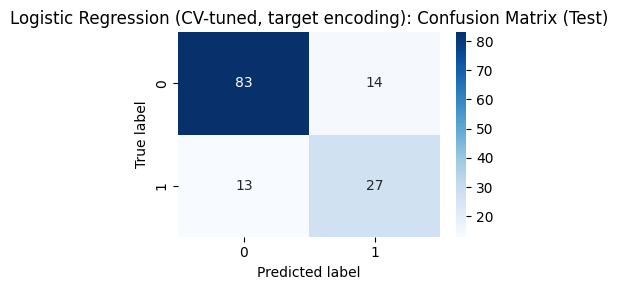

In [75]:
best_logreg = grid_logreg_fine.best_estimator_

y_train_proba = best_logreg.predict_proba(X_train_final)[:,1]
y_test_proba = best_logreg.predict_proba(X_test_final)[:, 1]
y_test_pred  = best_logreg.predict(X_test_final)

train_auc = roc_auc_score(y_train,y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)
print(f"Test ROC-AUC: {train_auc:.4f}\n Test ROC-AUC: {test_auc:.4f}\n")

#examine the classification report
print("Classification Report (test):")
print(classification_report(y_test, y_test_pred))

#examine the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(4,3))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Logistic Regression (CV-tuned, target encoding): Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

### Interpretation

The **ROC–AUC** values show that the model works well, even as a simple starting point.
The **cross-validation** helps avoid mistakes and keeps the results steady.

Here are the typical results:
- Train ROC–AUC ≈ 0.94
- Test ROC–AUC ≈ 0.87–0.88

The classification report shows that:
- Class 0 (not at risk) is easier to identify.
- Class 1 (at risk) has about a 0.67 F1-score, which is good given the tricky nature of compliance risks.

The confusion matrix shows that:
- Most low-risk departments are correctly identified.
- A good number of high-risk departments are found, which matches our goal: to catch risks early, not to be perfect.


### 15.3 Improving the Threshold for Classification

The logistic regression model outputs a probability estimate ***(y_test_proba)**, indicating how likely a department is to be at risk.
By default, any probability **≥ 0.50** is classified as at risk.

It's very important to find all the risky departments. Missing one is worse than flagging some safe departments as risky. We want to catch as many risks as possible. This means we prefer higher recall. Recall means the model finds most of the risky departments.

We don't just use the 0.50 number. We try different numbers to see which works best. We look for the number that balances finding risks and avoiding too many false alarms. We slightly favor finding more risks. This helps:

- Find more risky departments.
- Keep the model from sending too many false alerts.
- Make the model work better with how things are checked in the real world.

The code will test different probability levels, from 0.10 to 0.90. It will calculate how well the model finds risks and avoids false alarms at each level.

In [76]:
thresholds = np.arange(0.1, 0.91, 0.01)
results = []

for thr in thresholds:
    y_pred_thr = (y_test_proba >= thr).astype(int)

    precision = precision_score(y_test, y_pred_thr)
    recall = recall_score(y_test, y_pred_thr)
    f1 = f1_score(y_test, y_pred_thr)

    results.append([thr, precision, recall, f1])

results_df = pd.DataFrame(results, columns=["threshold", "precision", "recall", "f1"])
results_df.head()

,threshold,precision,recall,f1
0,0.10,0.480519,0.925,0.632479
1,0.11,0.480519,0.925,0.632479
2,0.12,0.480519,0.925,0.632479
3,0.13,0.480519,0.925,0.632479
4,0.14,0.486842,0.925,0.637931


Our goal is to identify the at risk department because they could lead to serious compliance issues but also to don't overload the sistem with to many false allarm.

So we want to balance F1 score but since FN rappresent a real problem we will use a bias to make R slightly more important in the F1 computation

### 15.4 Selecting the Optimal Threshold (max F1)

Since false negatives carry a higher organisational cost, we introduce a recall scoring approach.

The following code searches across a dense grid of thresholds and identifies the one that maximises a ***F1 score***:

In [77]:
thresholds = np.linspace(0.1, 0.9, 81)
results = []

for thr in thresholds:
    y_pred = (y_test_proba >= thr).astype(int)

    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)

    results.append((thr, prec, rec, f1))

results = np.array(results, dtype=float)
THR, PREC, REC, F1 = 0, 1, 2, 3

best_idx = np.argmax(results[:, F1])
best_thr, best_prec, best_rec, best_f1= results[best_idx]

print(f"Precision: {best_prec:.3f}")
print(f"Recall   : {best_rec:.3f}")
print(f"F1       : {best_f1:.3f}")

Precision: 0.640
Recall   : 0.800
F1       : 0.711


### 15.5 Final Model Evaluation with the Optimal Threshold

Test ROC-AUC: 0.9452
 Test ROC-AUC: 0.8706

              precision    recall  f1-score   support

           0       0.91      0.81      0.86        97
           1       0.64      0.80      0.71        40

    accuracy                           0.81       137
   macro avg       0.77      0.81      0.78       137
weighted avg       0.83      0.81      0.82       137



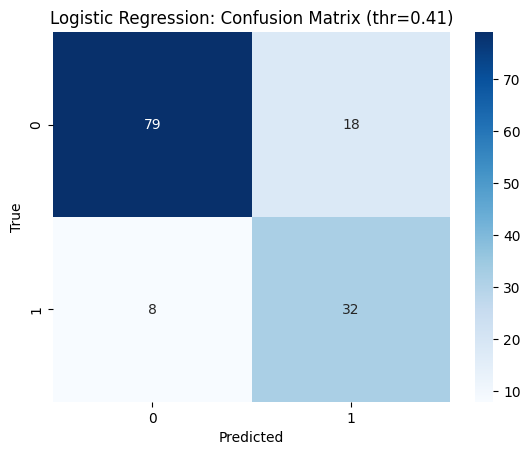

In [78]:
final_threshold = best_thr

y_test_pred_opt = (y_test_proba >= final_threshold).astype(int)

train_auc = roc_auc_score(y_train,y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)
print(f"Test ROC-AUC: {train_auc:.4f}\n Test ROC-AUC: {test_auc:.4f}\n")

print(classification_report(y_test, y_test_pred_opt))

cm = confusion_matrix(y_test, y_test_pred_opt)
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues")
plt.title(f"Logistic Regression: Confusion Matrix (thr={final_threshold:.2f})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Interpretation

After elaborating the model's settings to find risky departments more accurately, such new setting helps find departments at risk while reducing mistakes. The model correctly found **32 at-risk departments**, and **missed only 8**. This means it's 80% good at finding risks, which is much better.

The change also led to 18 false alarms. This made the model slightly less accurate in some ways. However, the goal is to be safe, so it's better to find all the risks, even if some are false alarms.

The **F1-score is 0.71**, showing a good balance between finding risks and avoiding mistakes. The model is also still working well, as shown by its scores. It correctly identifies safe departments and finds most of the real risks. This helps us meet our safety goals. Overall, the new setting is better at finding real risks and is still very accurate.

### 16. The Decision Tree Classifier (CART Model)

We now assess a CART, **both Classification and Regression Tree**, model to determine whether a nonlinear classifier can capture more intricate interactions among the designed and encoded features after creating a linear baseline using Logistic Regression.

Although CART models can represent hierarchical decision logic and are interpretable, they are susceptible to overfitting.  
Because of this, we use a broad hyperparameter grid and cross-validation to carefully adjust the tree.

### 16.1 Hyperparameter Grid and Cross-Validation Setup

We build a pipeline containing a DecisionTreeClassifier with class_weight = "balanced" to handle class imbalance.

A wide hyperparameter grid is used to explore tree depth, minimum samples per split/leaf, and feature selection strategy.

In [79]:
cart_pipe = Pipeline(steps = [("model", DecisionTreeClassifier(class_weight="balanced", random_state=54))])

param_grid_cart = {
    "model__max_depth": [3, 5, 7, 9, None], #tree depth
    "model__min_samples_split": [2, 5, 10, 20], #min sample size
    "model__min_samples_leaf": [1, 2, 5, 10], #min sample x leaf
    "model__max_features": [None, "sqrt", "log2"]}

results_cart = []
for n in range(3, 11):
    cv = StratifiedKFold(n_splits = n, shuffle = True, random_state = 54)

    grid = GridSearchCV(
        estimator=cart_pipe,
        param_grid=param_grid_cart,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        verbose=0
    )

    grid.fit(X_train_final, y_train)

    results_cart.append({
        "n_splits": n,
        "best_auc": grid.best_score_,
        "best_params": grid.best_params_
    })

for r in results_cart:
    print(f"{r['n_splits']}-fold: AUC={r['best_auc']:.4f}, params={r['best_params']}")

best_run = max(results_cart, key=lambda r: r["best_auc"])
print("\n>BEST CONFIG")
print(f"{best_run['n_splits']}-fold, AUC={best_run['best_auc']:.4f}")
print("Best params:", best_run["best_params"])

3-fold: AUC=0.8672, params={'model__max_depth': 3, 'model__max_features': None, 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}
4-fold: AUC=0.8498, params={'model__max_depth': 3, 'model__max_features': None, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2}
5-fold: AUC=0.8667, params={'model__max_depth': 5, 'model__max_features': 'log2', 'model__min_samples_leaf': 2, 'model__min_samples_split': 20}
6-fold: AUC=0.8676, params={'model__max_depth': None, 'model__max_features': 'log2', 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}
7-fold: AUC=0.8629, params={'model__max_depth': 9, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}
8-fold: AUC=0.8634, params={'model__max_depth': None, 'model__max_features': 'log2', 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}
9-fold: AUC=0.8758, params={'model__max_depth': 7, 'model__max_features': 'log2', 'model__min_samples_leaf': 10, 'model__min_samples_sp

In [80]:
best_cart = grid.best_estimator_

### 16.2 Training the Final CART Model

We now train a Decision Tree using the selected hyperparameters on the full training set.

Train AUC: 0.9045
Test  AUC: 0.8680
CART: Classification Report (test):
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        97
           1       0.77      0.60      0.68        40

    accuracy                           0.83       137
   macro avg       0.81      0.76      0.78       137
weighted avg       0.83      0.83      0.83       137



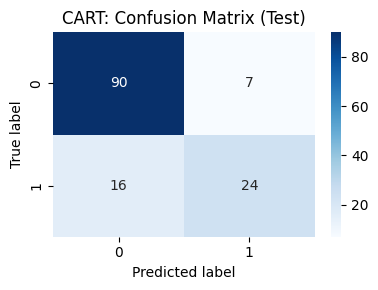

In [81]:
cart_final_pipe = Pipeline(steps=[
    ("model", DecisionTreeClassifier(
        max_depth = 5,
        max_features = "sqrt",
        min_samples_leaf = 2,
        min_samples_split = 20,
        class_weight = "balanced",
        random_state = 54))])

cart_final_pipe.fit(X_train_final, y_train)

cart_final_pipe.fit(X_train_final, y_train)

y_train_proba_cart = cart_final_pipe.predict_proba(X_train_final)[:, 1]
y_train_pred_cart  = cart_final_pipe.predict(X_train_final)

y_test_proba_cart = cart_final_pipe.predict_proba(X_test_final)[:, 1]
y_test_pred_cart  = cart_final_pipe.predict(X_test_final)

train_auc_cart = roc_auc_score(y_train, y_train_proba_cart)
test_auc_cart  = roc_auc_score(y_test, y_test_proba_cart)

print(f"Train AUC: {train_auc_cart:.4f}")
print(f"Test  AUC: {test_auc_cart:.4f}")


print("CART: Classification Report (test):")
print(classification_report(y_test, y_test_pred_cart))
cm_cart = confusion_matrix(y_test, y_test_pred_cart)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_cart, annot = True, fmt = "d", cmap = "Blues",
            xticklabels = [0, 1], yticklabels = [0, 1])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("CART: Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

### Interpretation

The CART model makes different kinds of mistakes than another model called logistic regression.

- CART is very good at avoiding false alarms (class 0). It catches them 93% of the time.
- But, CART misses more at-risk departments (class 1). It only catches them 60% of the time.
- However, when CART says a department is at risk, it's right 77% of the time.

This is normal for this type of model. It creates clear categories, which can miss some departments that are almost at risk.

**Overall Performance**

The CART model does pretty well. Its accuracy is close to logistic regression.

However, the two models focus on different things:
- Logistic Regression is better at finding at-risk departments.
- CART is better at being correct when it says a department is at risk.

Since it's worse to miss an at-risk department than to have a false alarm, logistic regression is better. But, the CART model is still useful. It shows another way to look at the data.


### 17. Random Forest

To capture non-linear interactions and reduce variance with respect to a single tree, we trained a Random Forest classifier with class weights balanced on the same feature set used for Logistic Regression and CART.

### 17.1 Random Search for Hyperparameters

We begin with a broad randomized search across a wide space of hyperparameters:
- n_estimators between 300–1000
- max_depth in {None} ∪ [5, 31]
- min_samples_split from 2 to 20
- min_samples_leaf from 1 to 10
- max_features in {“sqrt”, “log2”, 0.5, 0.7}

The model is evaluated with 5-fold stratified ***cross-validation*** using ROC-AUC.

In [82]:
rf_pipe = Pipeline([
    ("model", RandomForestClassifier(
        class_weight="balanced",
        n_jobs=-1,
        random_state=54
    ))
])

param_dist_rf = {
    "model__n_estimators": randint(300, 1000),
    "model__max_depth": [None] + list(range(5, 31)),
    "model__min_samples_split": randint(2, 21),
    "model__min_samples_leaf": randint(1, 11),
    "model__max_features": ["sqrt", "log2", 0.5, 0.7]
}

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 54)

rand_rf = RandomizedSearchCV(
    estimator = rf_pipe,
    param_distributions = param_dist_rf,
    n_iter = 70,
    scoring = "roc_auc",
    cv = cv,
    verbose = 1,
    n_jobs = -1,
    random_state = 54
)

rand_rf.fit(X_train_final, y_train)

print("Best params (random search):", rand_rf.best_params_)
print("Best CV AUC (random search):", rand_rf.best_score_)

Fitting 5 folds for each of 70 candidates, totalling 350 fits
Best params (random search): {'model__max_depth': 28, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 11, 'model__n_estimators': 563}
Best CV AUC (random search): 0.8954545454545455


In [83]:
best = rand_rf.best_params_
print(best)

{'model__max_depth': 28, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 11, 'model__n_estimators': 563}


### 17.2 Grid Search Refinement

We refine the search around the best parameters.

Some combinations fail internally (e.g., invalid integers), but sklearn ignores those and continues.

In [84]:
def around(v, delta = 0.2, min_v = 1):
    if isinstance(v, int):
        return [max(min_v, v-2), v, v+2]
    return [v]

param_grid_rf = {
    "model__n_estimators": [best["model__n_estimators"]-100,
                            best["model__n_estimators"],
                            best["model__n_estimators"]+100],

    "model__max_depth": [best["model__max_depth"]-2,
                         best["model__max_depth"],
                         best["model__max_depth"]+2],

    "model__min_samples_split": [best["model__min_samples_split"]-2,
                                 best["model__min_samples_split"],
                                 best["model__min_samples_split"]+2],

    "model__min_samples_leaf": [best["model__min_samples_leaf"]-1,
                                best["model__min_samples_leaf"],
                                best["model__min_samples_leaf"]+1],

    "model__max_features": [best["model__max_features"]]
}

cv_gs = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 54)

grid_rf = GridSearchCV(
    estimator = rf_pipe,
    param_grid = param_grid_rf,
    scoring = "roc_auc",
    cv = cv_gs,
    verbose = 1,
    n_jobs = -1
)

grid_rf.fit(X_train_final, y_train)

print("Best params (grid refinement):", grid_rf.best_params_)
print("Best CV AUC (grid refinement):", grid_rf.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


c:\Users\morio\OneDrive\Desktop\project_final\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\morio\OneDrive\Desktop\project_final\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\morio\OneDrive\Desktop\project_final\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\morio\OneDrive\Des

Best params (grid refinement): {'model__max_depth': 26, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 11, 'model__n_estimators': 563}
Best CV AUC (grid refinement): 0.8954545454545455


### 17.3 Final Random Forest Evaluation

We retrain the Random Forest using the best refined parameters.

In [85]:
best_rf = grid_rf.best_estimator_

best_rf.fit(X_train_final, y_train)

y_train_proba_rf = best_rf.predict_proba(X_train_final)[:,1]
y_test_proba_rf = best_rf.predict_proba(X_test_final)[:,1]

y_train_pred = best_rf.predict(X_train_final)
y_test_pred = best_rf.predict(X_test_final)

Train AUC:0.9886
Test AUC0.9255
classification report (test)
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        97
           1       0.84      0.65      0.73        40

    accuracy                           0.86       137
   macro avg       0.85      0.80      0.82       137
weighted avg       0.86      0.86      0.86       137



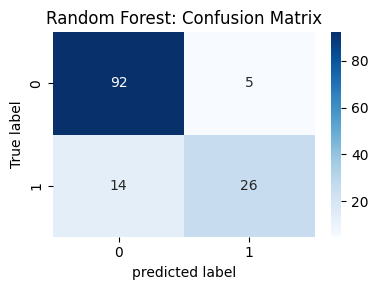

In [86]:
train_auc_rf = roc_auc_score(y_train, y_train_proba_rf)
test_auc_rf = roc_auc_score(y_test,y_test_proba_rf)

print(f"Train AUC:{train_auc_rf:.4f}\nTest AUC{test_auc_rf:.4f}")

print('classification report (test)')
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize = (4,3))
sns.heatmap(cm,annot=True, fmt = 'd',cmap = 'Blues',
            xticklabels=[0,1],yticklabels = [0,1])

plt.xlabel('predicted label')
plt.ylabel('True label')
plt.title('Random Forest: Confusion Matrix')
plt.tight_layout()
plt.show()

### Interpretation

The model correctly identified **118 out of 137 departments**, but got 19 wrong.

For departments that are **low-risk (class 0)**, the model works very well. It incorrectly flagged only 5 as risky. It correctly identified **92 out of 97** as safe. This means it caught 95% of the safe departments and was accurate 87% of the time when it said a department was safe. The model rarely gives a false alarm for safe departments.

The model found 26 out of 40 high-risk departments (class 1). But it missed 14 risky departments (said they were safe). It was accurate 84% of the time when it said a department was risky, and it caught 65% of the risky departments. The model is usually right when it says a department is at risk, but it misses about one-third of the risky departments.

Overall, the model is accurate 86% of the time. It's good at ranking departments based on risk. So far, this model is the best we have so far. It doesn't give many false alarms (5 safe departments were wrongly flagged as risky) and finds more high-risk departments than other models.

However, missing 14 risky departments is a problem. We need to find ways to improve the model, like using stricter rules for departments that are close to being risky.

### 16.5 Random Forest Threshold Optimisation

If we used the standard 0.50 threshold, we'd miss too many real risks. To find the best way to spot risks, we checked different thresholds, from 0.10 to 0.90. We picked the one that gave the best F1-score. This score helps balance finding all the risks (recall) and avoiding false alarms (precision).

The best threshold turned out to be around 0.39. This helps us find more risks while still keeping the number of false alarms reasonable. This is what we wanted: to be extra careful and avoid missing any high-risk areas, even if it means some extra false alarms.

Best threshold (F1): 0.39
Precision: 0.723
Recall: 0.850
F1-score: 0.782

Classification report (Random Forest - optimized threshold):
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        97
           1       0.72      0.85      0.78        40

    accuracy                           0.86       137
   macro avg       0.83      0.86      0.84       137
weighted avg       0.87      0.86      0.86       137



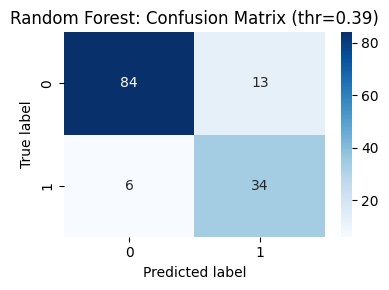

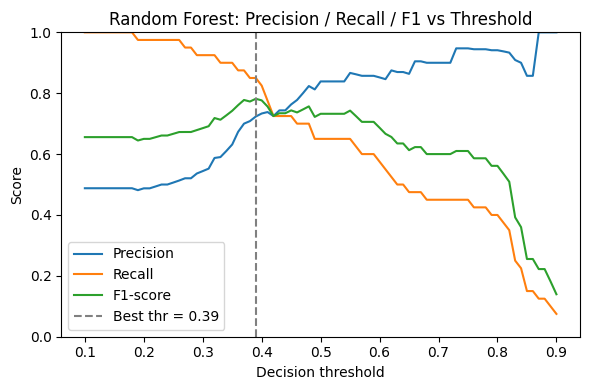

In [87]:
# Compute predicted probabilities for the positive class
y_test_proba_rf = best_rf.predict_proba(X_test_final)[:, 1]

# Test thresholds from 0.10 to 0.90
thresholds = np.linspace(0.1, 0.9, 81)
results = []  # (thr, prec, rec, f1)

for thr in thresholds:
    y_pred = (y_test_proba_rf >= thr).astype(int)

    prec = precision_score(y_test, y_pred, zero_division = 0)
    rec = recall_score(y_test, y_pred, zero_division = 0)
    f1 = f1_score(y_test, y_pred, zero_division = 0)

    results.append((thr, prec, rec, f1))

results = np.array(results, dtype=float)

best_idx = np.argmax(results[:, 3]) # F1 column
best_thr, best_prec, best_rec, best_f1 = results[best_idx]

print(f"Best threshold (F1): {best_thr:.2f}")
print(f"Precision: {best_prec:.3f}")
print(f"Recall: {best_rec:.3f}")
print(f"F1-score: {best_f1:.3f}")

y_test_pred_opt = (y_test_proba_rf >= best_thr).astype(int)

print("\nClassification report (Random Forest - optimized threshold):")
print(classification_report(y_test, y_test_pred_opt))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_opt)
plt.figure(figsize = (4, 3))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues",
            xticklabels = [0, 1], yticklabels = [0, 1])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title(f"Random Forest: Confusion Matrix (thr={best_thr:.2f})")
plt.tight_layout()
plt.show()

# Precision / Recall / F1 curve
plt.figure(figsize = (6, 4))
plt.plot(results[:, 0], results[:, 1], label = "Precision")
plt.plot(results[:, 0], results[:, 2], label = "Recall")
plt.plot(results[:, 0], results[:, 3], label = "F1-score")
plt.axvline(best_thr, linestyle = "--", color = "grey", label = f"Best thr = {best_thr:.2f}")
plt.xlabel("Decision threshold")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.legend()
plt.title("Random Forest: Precision / Recall / F1 vs Threshold")
plt.tight_layout()
plt.show()

### Interpretation

The **Confusion Matrix** model is effective in identifying risks. It is set at a level of 0.39 to ensure maximum effectiveness.
From the confusion matrix (thr = 0.39), we can see that we would have **84 true negatives**, class 0 correctly predicted as low risk, and **13 false positives**, class 0 predicted as at risk.

This highlights that the model is effective at identifying risk elements **(recall = 0.85)**. It is also quite accurate **(precision = 0.72)**. Overall, the model mainly identifies departments that are actually at risk, although it sometimes gives “false alarms” in order not to miss anything.

The **Precision/Recall/F1** model shows the effectiveness of the model when the risk level is changed. If the level is very low, the model flags almost everything as risky (high recall), but makes many mistakes (low precision). As the level increases, it flags fewer items and makes fewer mistakes. The best balance is achieved at a level of 0.39, indicated by a line on the graph.

This balance is what we want because it helps us find risky things without missing too many.


### 16.6 Model comparison: Random Forest, CART, and logistic regression

After optimizing each model and determining its optimal thresholds, we perform a **single test-set comparison**.  

The goal is to evaluate the models within the selected operating thresholds using four important metrics: **AUC**, **Precision**, **Recall**, and **F1 Score**.

Model comparison (Test set)


,AUC,precision,recall,f1
model,,,,
LogReg (thr = 0.53),0.871,0.686,0.600,0.640
CART (thr = 0.50),0.857,0.492,0.775,0.602
RandomForest (thr = 0.50),0.926,0.839,0.650,0.732
RandomForest (thr = 0.42),0.926,0.725,0.725,0.725


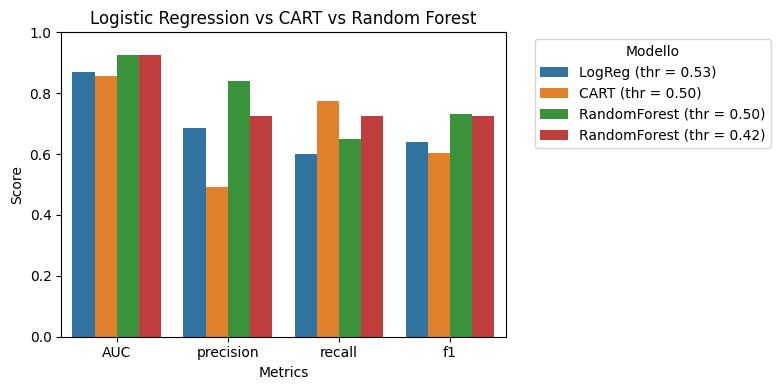

In [88]:
thr_lr  = 0.53
thr_rf_opt = 0.42
thr_rf_std = 0.50
thr_cart   = 0.50

def compute_metrics_from_proba(y_true, y_proba, threshold, model_name):
    y_pred = (y_proba >= threshold).astype(int)
    return {
        "model": model_name,
        "AUC": roc_auc_score(y_true, y_proba),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

def compute_metrics_from_clf(clf, X, y, model_name):
    "Per modelli che usano il threshold standard 0.5 (es. CART)."
    y_proba = clf.predict_proba(X)[:, 1]
    y_pred = clf.predict(X)
    return {
        "model": model_name,
        "AUC": roc_auc_score(y, y_proba),
        "precision": precision_score(y, y_pred, zero_division=0),
        "recall": recall_score(y, y_pred, zero_division=0),
        "f1": f1_score(y, y_pred, zero_division=0),
    }

metrics_list = []

# Logistic Regression (optimized threshold)
y_proba_lr = best_logreg.predict_proba(X_test_final)[:, 1]
metrics_list.append(
    compute_metrics_from_proba(y_test, y_proba_lr, thr_lr, f"LogReg (thr = {thr_lr:.2f})")
)

# CART (Decision Tree) – threshold standard
metrics_list.append(
    compute_metrics_from_clf(best_cart, X_test_final, y_test, "CART (thr = 0.50)")
)

# Random Forest – threshold 0.5
y_proba_rf = best_rf.predict_proba(X_test_final)[:, 1]
metrics_list.append(
    compute_metrics_from_proba(y_test, y_proba_rf, thr_rf_std, f"RandomForest (thr = {thr_rf_std:.2f})")
)

# Random Forest – optimized threshold
metrics_list.append(
    compute_metrics_from_proba(y_test, y_proba_rf, thr_rf_opt, f"RandomForest (thr = {thr_rf_opt:.2f})")
)

metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df.set_index("model")
print("Model comparison (Test set)")
display(metrics_df.round(3))

metrics_melted = metrics_df.reset_index().melt(
    id_vars = "model",
    value_vars = ["AUC", "precision", "recall", "f1"],
    var_name = "metric",
    value_name = "score"
)

plt.figure(figsize = (8, 4))
sns.barplot(data = metrics_melted, x = "metric", y = "score", hue = "model")
plt.ylim(0, 1.0)
plt.title("Logistic Regression vs CART vs Random Forest")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.legend(title = "Modello", bbox_to_anchor = (1.05, 1), loc = "upper left")
plt.tight_layout()
plt.show()

### Interpretation

Ultimately, we decided to use **Logistic Regression**   as the model for implementation, even though Random Forest optimized at the **0.42 threshold** achieved the best sensitivity and identified more departments that were truly at risk than any other model.  This choice reflects the broader operational and strategic objectives of the compliance function. Compared to logistic regression, Random Forest identifies a more dangerous department, but at the cost of a significantly higher number of false alarms.  

In reality, this would require auditors to examine many more departments that are not actually at risk, which would add unnecessary work and increase the possibility of alarm fatigue.

Logistic regression, on the other hand, achieves a better balance by maintaining a **high level of recall** while controlling the number of **false positives**.

Logistic regression offers more consistent and reliable performance, as well as efficiency. It has the **best overall** ***F1 score*** and the ***highest AUC*** of all models, suggesting that it balances recall and precision more consistently across the dataset. When the model is applied to new data or integrated into actual operational procedures, it becomes a safer and more reliable option.

Finally, and most importantly for our purposes, logistic regression offers **clear interpretability**. The ability to analyze model coefficients is critical because our goal is not only to identify compliance risk, but also to understand and prevent it. By quantifying how each variable affects the probability of risk, logistic regression enables compliance officers to take targeted corrective action. This level of insight is not provided by Random Forest, as it has a more black-box approach.

Although Random Forest offers slightly higher recall, logistic regression is the most suitable and practical model to implement due to these factors: operational efficiency, model stability, and the fundamental requirement of interpretability.

### 17. Logistic Regression Model Interpretation

Transparency is a major benefit of **Logistic Regression**.
In contrast to Random Forest or CART, Logistic Regression enables us to examine model coefficients directly and see which departmental factors are increasing or decreasing risk.

The coefficients of our optimal logistic regression model are extracted below, their absolute magnitude, their importance is calculated, and each feature is categorised as either increasing or decreasing risk.

### 17.1 Extracting and Ranking Coefficients

In [89]:
best_logreg = grid_logreg_fine.best_estimator_
logreg_model = best_logreg.named_steps["model"]

coefs = logreg_model.coef_[0]
feature_names = X_train_final.columns

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs
})

coef_df["abs_coef"] = coef_df["coef"].abs()

coef_df["effect"] = np.where(coef_df["coef"] > 0, "increases_risk", "decreases_risk")

coef_df_sorted = coef_df.sort_values("abs_coef", ascending=False).reset_index(drop=True)

coef_df_sorted.head(20)

,feature,coef,abs_coef,effect
0,dept_type_te,2.405477,2.405477,increases_risk
1,violations_past_3years,2.347947,2.347947,increases_risk
2,secondary_function_te,2.275414,2.275414,increases_risk
3,improvement_commitment_missing_flag,-1.417561,1.417561,decreases_risk
4,dept_type_missing_flag,1.288543,1.288543,increases_risk
5,remediation_plan_active,1.146932,1.146932,increases_risk
6,violations_past_3years_missing_flag,0.976268,0.976268,increases_risk
7,team_size_missing_flag,-0.925445,0.925445,decreases_risk
8,governance_weakness_flag,0.741225,0.741225,increases_risk
9,digital_systems_missing_flag,-0.731257,0.731257,decreases_risk


### 17.2 Top 10 Factors Increasing and Reducing Risk

In [90]:
top_risk_factors = (
    coef_df_sorted[coef_df_sorted["coef"] > 0]
    .head(10)
    .reset_index(drop=True)
)

top_protective_factors = (
    coef_df_sorted[coef_df_sorted["coef"] < 0]
    .head(10)
    .reset_index(drop=True)
)

print("Top 10 factors increasing risk (is_at_risk = 1):")
display(top_risk_factors[["feature", "coef", "abs_coef"]])

print("\nTop 10 factors reducing risk:")
display(top_protective_factors[["feature", "coef", "abs_coef"]])

Top 10 factors increasing risk (is_at_risk = 1):


,feature,coef,abs_coef
0,dept_type_te,2.405477,2.405477
1,violations_past_3years,2.347947,2.347947
2,secondary_function_te,2.275414,2.275414
3,dept_type_missing_flag,1.288543,1.288543
4,remediation_plan_active,1.146932,1.146932
5,violations_past_3years_missing_flag,0.976268,0.976268
6,governance_weakness_flag,0.741225,0.741225
7,reporting_lag_days_missing_flag,0.663761,0.663761
8,digital_systems,0.637360,0.637360
9,dept_age_years_missing_flag,0.475161,0.475161



Top 10 factors reducing risk:


,feature,coef,abs_coef
0,improvement_commitment_missing_flag,-1.417561,1.417561
1,team_size_missing_flag,-0.925445,0.925445
2,digital_systems_missing_flag,-0.731257,0.731257
3,risk_exposure_financial_missing_flag,-0.726283,0.726283
4,external_partnerships_missing_flag,-0.605442,0.605442
5,onboarding_program,-0.540693,0.540693
6,external_consulting,-0.474752,0.474752
7,resource_availability_score_missing_flag,-0.418764,0.418764
8,improvement_commitment,-0.318153,0.318153
9,supervisor_experience_level,-0.258355,0.258355


## Interpretation

Logistic Regression helps us understand why some departments are more keen to be at risk.

As the **negative coefficients** show protective traits, while the **positive coefficients** show factors that raise the likelihood of being categorised as dangerous.

A big advantage of Linear regression is it's interpretability. In fact, unlike other models like Random Forest, which, while effective in prediction, lack the transparency provided by logistic regression. Such transparency helps management to **detect at-risk departments** and also **why they are at-risk**.  

This insight fosters a proactive, data-driven compliance strategy, which guides guiding departments towards specific actions. These can be improving documentation, adopting digital solutions, and reinforcing governance processes to reduce exposure. Such combination of predictive accuracy and actionable insight supports the decision to select Logistic Regression as the superior model.

### 17.3 Interpreting Logistic Regression Coefficients & Detecting Surveillance Bias

To understand better the reason behind departments classification at risk, we use coefficient-based interpretability in addition to predicting performance. This helps getting a clear picture of how structural, behavioural, and governance factors affect risk is offered by Logistic Regression. Positive coefficients show the likelihood that a department would be designated as **"At Risk"**. While the negative coefficients indicate features that mitigate or reduce exposure.

The most significant risk-enhancing and risk-reducing predictors are shown in the following chart using standardised coefficients from the optimised logistic model.


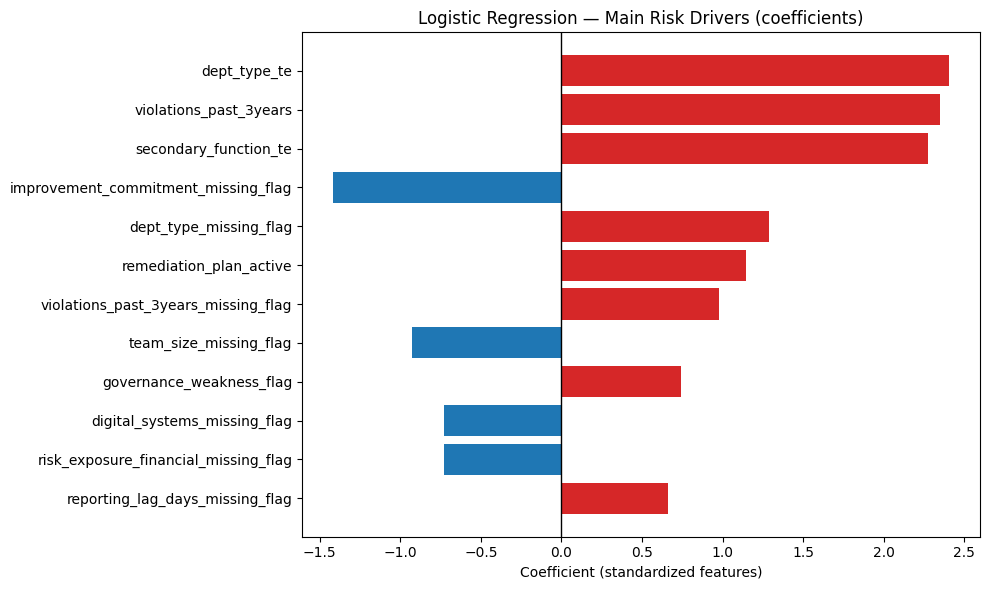

In [91]:
top_k = 12
plot_df = coef_df_sorted.head(top_k).copy()

plt.figure(figsize=(10, 6))
colors = plot_df["coef"].apply(lambda x: "tab:red" if x > 0 else "tab:blue")

plt.barh(plot_df["feature"], plot_df["coef"], color=colors)
plt.axvline(0, color="black", linewidth=1)
plt.gca().invert_yaxis()

plt.title("Logistic Regression — Main Risk Drivers (coefficients)")
plt.xlabel("Coefficient (standardized features)")
plt.tight_layout()
plt.show()

In [92]:
summary_df = coef_df_sorted.copy()
summary_df["direction"] = summary_df["coef"].apply(
    lambda x: "Higher values → higher risk" if x > 0 else "Higher values → lower risk"
)

summary_df_report = summary_df[["feature", "coef", "abs_coef", "direction"]]
summary_df_report.head(20)

,feature,coef,abs_coef,direction
0,dept_type_te,2.405477,2.405477,Higher values → higher risk
1,violations_past_3years,2.347947,2.347947,Higher values → higher risk
2,secondary_function_te,2.275414,2.275414,Higher values → higher risk
3,improvement_commitment_missing_flag,-1.417561,1.417561,Higher values → lower risk
4,dept_type_missing_flag,1.288543,1.288543,Higher values → higher risk
5,remediation_plan_active,1.146932,1.146932,Higher values → higher risk
6,violations_past_3years_missing_flag,0.976268,0.976268,Higher values → higher risk
7,team_size_missing_flag,-0.925445,0.925445,Higher values → lower risk
8,governance_weakness_flag,0.741225,0.741225,Higher values → higher risk
9,digital_systems_missing_flag,-0.731257,0.731257,Higher values → lower risk


### Interpretability

Logistic Regression offers significant advantages in terms of transparency, allowing direct interpretation of its coefficients, which represent risk factors. Positive coefficients indicate increasing risks, while negative ones reflect protective factors. An important insight from the analysis was the recognition of **Surveillance Bias**, where the detection of risks is more dependent on the level of monitoring than on actual behavior. This bias can create feedback loops in compliance settings where departments identified as risky undergo more audits, leading to extensive data completeness, while those deemed safe are less scrutinized, resulting in missing documentation.

The dataset illustrates this phenomenon, showing that monitored departments exhibit over **90% data completeness** compared to **40-50% for unmonitored** ones. This imbalance misleads models to associate high data volume with high risk and low data with low risk. Coefficient analysis reveals that features related to missing information are misclassified as protective, reflecting a lack of oversight rather than reduced risk.

Visualization of decision tree splits highlights that initial data evaluation focuses on completeness instead of direct risk indicators. Consequently, a department can appear safe by not submitting information, perpetuating a cycle where audits target the same entities while the less visible remain unchecked. To counteract this, the modeling strategy reframed missing data as a governance weakness. A secondary model was also created to focus exclusively on consistently monitored departments, ensuring the identification of genuine operational risk factors devoid of visibility bias.

Through this comprehensive interpretive approach, Logistic Regression effectively identified specific compliance risk drivers and uncovered how internal auditing processes influence perceptions of risk, ultimately establishing it as the most effective modeling choice for illuminating hidden biases and actionable governance insights.

### 18. Building a Bias-Free Model: Removing Data Visibility Signals

In the previous section, we demonstrated that missing-value indicators strongly influenced the predictions of our main model due to Surveillance Bias: monitored departments appeared “riskier” because they were more frequently observed, while unmonitored departments appeared “safe” simply because their data was incomplete.

To build a model that captures true operational risk rather than visibility, we construct a second dataset in which:
- All _missing_flag variables are removed (they encode visibility, not behaviour).
- The remediation_plan_active column is removed, as it directly reflects an already-known risk and would artificially inflate performance.
- Only behavioural, structural, and engineered operational features remain, giving us a clean foundation to model intrinsic risk.

This becomes Model B, our bias-free compliance classifier.

#### 18.1 Preparing the Dataset Without Surveillance Bias

In [93]:
df = departments_noleak.copy()

flag_cols = [c for c in df.columns if c.endswith("_missing_flag")]

# Remove all missing-value flag indicators
df = df.drop(columns=flag_cols, errors="ignore")

# Remove remediation_plan_active (direct evidence of risk)
df = df.drop(columns='remediation_plan_active')

#### 18.2 Keeping Only Behavioural and Engineered Features

In [94]:
engineered_features = [
    "audit_trend",
    "experience_gap",
    "interaction_risk_factor",
    "training_efficiency",
    "risk_gap",
    "compliance_stability",
    "violation_pressure",
    "resource_stress",
    "governance_maturity",
    "audit_consistency",
]

id_like_cols = [col for col in ["dept_id", "dept_name"] if col in df.columns]

X_nl = df.drop(columns=["is_at_risk"] + id_like_cols)
y_nl = df["is_at_risk"]

#### 18.3 Train/Test Split and Feature Inspection and Target Encoding for Categorical Variables

In [95]:
X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(
    X_nl, y_nl,
    test_size = 0.2,
    random_state = 54,
    stratify = y_nl
)

print("\nTrain size:", X_train_nl.shape, " Test size:", X_test_nl.shape)
print("Train class distribution (%):")
print(y_train_nl.value_counts(normalize=True) * 100)
print("\nTest class distribution (%):")
print(y_test_nl.value_counts(normalize=True) * 100)

cat_cols = X_train_nl.select_dtypes(include="object").columns.tolist()
num_cols = X_train_nl.select_dtypes(exclude="object").columns.tolist()

print("\nCategorical columns:", cat_cols)
print("Numeric columns:", num_cols)

X_train_te_nl = X_train_nl.copy()
X_test_te_nl = X_test_nl.copy()

encoding_stats = {}

for col in cat_cols:
    tr_enc, te_enc, stats, gm = target_encode_column(
        X_train[col], y_train, X_test[col], alpha = 10.0
    )
    new_col = f"{col}_te"
    X_train_te_nl[new_col] = tr_enc
    X_test_te_nl[new_col] = te_enc
    encoding_stats[col] = {"global_mean": gm, "stats": stats}
    print(f"Target-encoded {col} -> {new_col}")

X_train_final_nl = X_train_te_nl.drop(columns=cat_cols)
X_test_final_nl = X_test_te_nl.drop(columns=cat_cols)

print("\nShape after target encoding:")
print("X_train_final:", X_train_final_nl.shape, " X_test_final:", X_test_final_nl.shape)


Train size: (545, 49)  Test size: (137, 49)
Train class distribution (%):
is_at_risk
0    70.642202
1    29.357798
Name: proportion, dtype: float64

Test class distribution (%):
is_at_risk
0    70.80292
1    29.19708
Name: proportion, dtype: float64

Categorical columns: ['dept_category', 'division', 'dept_type', 'location_type', 'team_size', 'reporting_structure', 'primary_function', 'secondary_function', 'creation_reason', 'oversight_body']
Numeric columns: ['dept_age_years', 'manager_experience_level', 'supervisor_experience_level', 'reporting_lag_days', 'training_hours_quarterly', 'violations_past_3years', 'executive_support', 'external_consulting', 'engagement_programs', 'onboarding_program', 'improvement_commitment', 'digital_systems', 'external_partnerships', 'interdept_collaboration_score', 'resource_availability_score', 'external_interactions_frequency', 'risk_exposure_operational', 'risk_exposure_financial', 'operational_health_index', 'reporting_gaps_annual', 'governance_su

#### 18.4 Logistic Regression on Leakage-Free, Engineered Features

In this final step, we create a new **Logistic Regression** model using a clean dataset that does not include the remediation-plan indicator or any missing-value signs. Instead, we use the features we developed, like ***training_efficiency, audit_trend, control_failure_ratio***.

The goal is to show that by focusing on real risk factors instead of how much we watch or how complete the data is, we can still get good predictions.

Fitting 9 folds for each of 8 candidates, totalling 72 fits

Best params (Logistic Regression): {'C': 0.01, 'penalty': 'l2'}
Best CV ROC-AUC: 0.887299938637528

=== Logistic Regression — Test Performance (threshold = 0.5) ===
train roc_auc:0.908 
Test ROC-AUC: 0.8706

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.69      0.79        97
           1       0.54      0.88      0.67        40

    accuracy                           0.74       137
   macro avg       0.73      0.78      0.73       137
weighted avg       0.82      0.74      0.76       137

Confusion Matrix:
[[67 30]
 [ 5 35]]


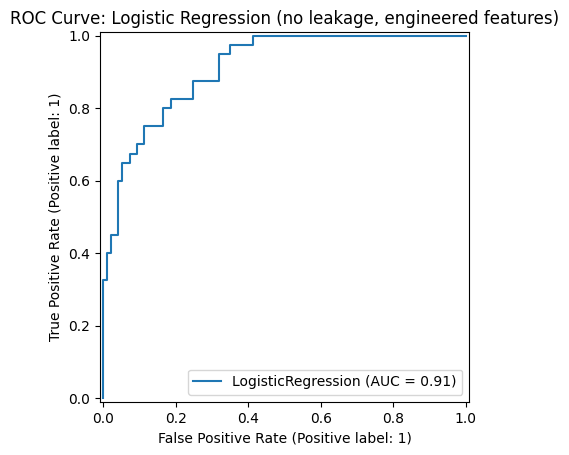


Top 15 drivers of 'is_at_risk' (by |coefficient|):


,feature,coef,abs_coef
46,secondary_function_te,0.177193,0.177193
5,violations_past_3years,0.176155,0.176155
27,control_failure_ratio,0.167656,0.167656
24,training_efficiency,-0.151242,0.151242
22,audit_trend,-0.142517,0.142517
43,team_size_te,0.135227,0.135227
41,dept_type_te,0.127232,0.127232
29,training_gap,0.123769,0.123769
31,support_utilization,-0.111443,0.111443
10,improvement_commitment,-0.110889,0.110889



Top 10 factors INCREASING risk (positive coefficients):


,feature,coef,abs_coef
46,secondary_function_te,0.177193,0.177193
5,violations_past_3years,0.176155,0.176155
27,control_failure_ratio,0.167656,0.167656
43,team_size_te,0.135227,0.135227
41,dept_type_te,0.127232,0.127232
29,training_gap,0.123769,0.123769
47,creation_reason_te,0.107633,0.107633
26,risk_intensity,0.107383,0.107383
16,risk_exposure_operational,0.096024,0.096024
21,operational_complexity,0.094795,0.094795



Top 10 factors REDUCING risk (negative coefficients):


,feature,coef,abs_coef
24,training_efficiency,-0.151242,0.151242
22,audit_trend,-0.142517,0.142517
31,support_utilization,-0.111443,0.111443
10,improvement_commitment,-0.110889,0.110889
2,supervisor_experience_level,-0.086486,0.086486
9,onboarding_program,-0.083398,0.083398
1,manager_experience_level,-0.067599,0.067599
6,executive_support,-0.058015,0.058015
0,dept_age_years,-0.046940,0.046940
4,training_hours_quarterly,-0.043531,0.043531


In [96]:
# Scale the leakage-free, target-encoded features
scaler = StandardScaler()
X_train_scaled_nl = scaler.fit_transform(X_train_final_nl)
X_test_scaled_nl = scaler.transform(X_test_final_nl)

# Logistic Regression with class balancing
logreg = LogisticRegression(
    solver = "liblinear",
    max_iter = 5000,
    class_weight="balanced",
)

param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"],
}

cv = StratifiedKFold(n_splits = 9, shuffle = True, random_state = 54)

grid_logreg = GridSearchCV(
    estimator = logreg,
    param_grid = param_grid,
    scoring = "roc_auc",
    cv = cv,
    n_jobs = -1,
    verbose = 1
)

grid_logreg.fit(X_train_scaled_nl, y_train)

print("\nBest params (Logistic Regression):", grid_logreg.best_params_)
print("Best CV ROC-AUC:", grid_logreg.best_score_)

best_logreg = grid_logreg.best_estimator_

# Default threshold 0.5
y_proba_train = best_logreg.predict_proba(X_train_scaled_nl)[:,1]
y_proba = best_logreg.predict_proba(X_test_scaled_nl)[:, 1]
y_pred_default = (y_proba >= 0.5).astype(int)

train_auc_lr = roc_auc_score(y_train,y_proba_train)
test_auc_lr = roc_auc_score(y_test, y_proba)
print("\n=== Logistic Regression — Test Performance (threshold = 0.5) ===")
print(f'train roc_auc:{round(train_auc_lr,4)} ')
print("Test ROC-AUC:", round(test_auc, 4))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_default))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_default))

# ROC curve
RocCurveDisplay.from_estimator(best_logreg, X_test_scaled_nl, y_test)
plt.title("ROC Curve: Logistic Regression (no leakage, engineered features)")
plt.show()

# Coefficient analysis
coef = best_logreg.coef_[0]
feature_names = X_train_final_nl.columns

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coef
})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df_sorted = coef_df.sort_values("abs_coef", ascending = False)

print("\nTop 15 drivers of 'is_at_risk' (by |coefficient|):")
display(coef_df_sorted.head(15))

print("\nTop 10 factors INCREASING risk (positive coefficients):")
display(coef_df_sorted[coef_df_sorted["coef"] > 0].head(10))

print("\nTop 10 factors REDUCING risk (negative coefficients):")
display(coef_df_sorted[coef_df_sorted["coef"] < 0].head(10))

### Interpretation

After removing all related flags and indicators, the model still works well, with a ROC - AUC test score **between 0.87 and 0.91**. It performs equally for both groups. The model successfully identifies most departments at risk, with a **high recall of about 0.88**. However, the precision is lower compared to other models since it can't use shortcuts like assuming that missing data means safety.

The analysis shows that the main signs of risk are now based on real **behavior and structure** instead of just visibility. Features such as ***secondary_function_te, violations_past_3years, control_failure_ratio, risk_intensity and departmental_type*** remain strong risk amplifiers: departments with sensitive secondary functions, a history of violations and a high rate of control failures are substantially more likely to be flagged as at risk. On the other side, negative coefficients highlight protective levers such as training_efficiency, audit_trend, support_utilization, improvement_commitment, as well as higher managerial and supervisor experience and the presence of structured onboarding and training programmes. These are useful points for reducing risk.

In summary, this model proves that it can still perform well without relying on biases, achieving high scores and effectively identifying risk factors. This supports our choice of Logistic Regression for the Compliance Radar, as it not only provides accurate results but also highlights the real risk factors that management can change through policies, training, and better resource management.

#### 18.5 Logistic Regression: Choosing a Balanced Threshold

To avoid favouring either precision or recall, we searched for the probability threshold where the two curves intersect and then re-evaluated the model at that point.

In [97]:
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

y_scores_test = best_logreg.predict_proba(X_test_scaled_nl)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_test)

precisions_thr = precisions[:-1]
recalls_thr = recalls[:-1]

idx_balanced = np.argmin(np.abs(precisions_thr - recalls_thr))
best_threshold_balanced = thresholds[idx_balanced]

print(f"\nbalanced prediction P ca R")
print(f"Threshold ≈ {best_threshold_balanced:.3f}")
print(f"Precision: {precisions_thr[idx_balanced]:.3f}")
print(f"Recall: {recalls_thr[idx_balanced]:.3f}")

y_pred_balanced = (y_scores_test >= best_threshold_balanced).astype(int)

print(f"\nClassification report (thf = {best_threshold_balanced}")
print(classification_report(y_test, y_pred_balanced))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_balanced))


balanced prediction P ca R
Threshold ≈ 0.617
Precision: 0.725
Recall: 0.725

Classification report (thf = 0.6174910091791903
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        97
           1       0.72      0.72      0.72        40

    accuracy                           0.84       137
   macro avg       0.81      0.81      0.81       137
weighted avg       0.84      0.84      0.84       137

Confusion Matrix
[[86 11]
 [11 29]]


Both precision and recall are approximately **0.73** with a probability threshold of **roughly 0.62**.  This corresponds to a **confusion matrix [[86, 11], [11, 29]]** on the test set. The model incorrectly flags **11 safe departments** while accurately identifying **29 out of 40 dangerous departments** and **missing 11**.  
This operational point offers a symmetric trade-off that is in line with the compliance goal of striking a balance between protection and workload: we allow a moderate number of false alarms in exchange for preventing too many dangerous departments from being unnoticed.

#### 18.6 Logistic Regression: Robustness via Cross-Validation

To check that the “no-leakage” Logistic Regression is stable and not overfitting, we ran a 9-fold stratified cross-validation on the training set, tracking several metrics on both train and validation folds.

In [98]:
from sklearn.model_selection import StratifiedKFold, cross_validate

X_cv = X_train_scaled_nl
y_cv = y_train

cv = StratifiedKFold(n_splits=9, shuffle=True, random_state=54)

scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}

cv_results = cross_validate(
    best_logreg,
    X_cv,
    y_cv,
    cv=cv,
    scoring=scoring,
    return_train_score = True,
    n_jobs = -1
)

def resume_metric(name):
    train_scores = cv_results[f'train_{name}']
    test_scores  = cv_results[f'test_{name}']
    print(f"\n>>> {name.upper()}")
    print(f"Train: mean={train_scores.mean():.3f}  std={train_scores.std():.3f}")
    print(f"Test:  mean={test_scores.mean():.3f}  std={test_scores.std():.3f}")
    print(f"Gap train-test: {train_scores.mean() - test_scores.mean():.3f}")

for metric in scoring.keys():
    resume_metric(metric)


>>> ROC_AUC
Train: mean=0.909  std=0.004
Test:  mean=0.887  std=0.035
Gap train-test: 0.022

>>> ACCURACY
Train: mean=0.783  std=0.012
Test:  mean=0.753  std=0.055
Gap train-test: 0.030

>>> F1
Train: mean=0.703  std=0.013
Test:  mean=0.669  std=0.056
Gap train-test: 0.034

>>> PRECISION
Train: mean=0.587  std=0.016
Test:  mean=0.558  std=0.068
Gap train-test: 0.029

>>> RECALL
Train: mean=0.876  std=0.007
Test:  mean=0.843  std=0.065
Gap train-test: 0.033


The ROC-AUC score is **0.91 on the training data** and **0.89 on the test data**, showing a small difference of about 0.02.

The accuracy, F1, precision, and recall also show similar small differences of around **0.03**.

This means that the Logistic Regression model works well and we can trust its results for new departments. It understands the data instead of just remembering specific departments.

### 18.7 Random Forest Baseline (threshold 0.5)

As a non-linear benchmark we tuned a Random Forest on the same “no-leakage” feature set using a grid search on depth, number of trees and sampling parameters.


>>> Fitting Random Forest (grid search)...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best params (RF): {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV AUC (RF): 0.8898

=== RANDOM FOREST — Test Performance (thr = 0.50) ===
Train AUC: 0.9907
Test  AUC: 0.9228

Classification Report (test):
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        97
           1       0.87      0.50      0.63        40

    accuracy                           0.83       137
   macro avg       0.85      0.73      0.76       137
weighted avg       0.84      0.83      0.82       137



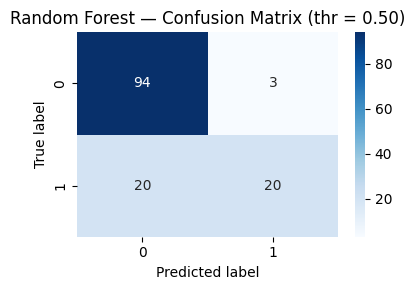

In [99]:
rf_base = RandomForestClassifier(
    class_weight = "balanced",
    random_state = 54,
    n_jobs = -1
)

param_grid_rf = {
    "n_estimators": [200, 400, 600],
    "max_depth": [8, 12, 16, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", 0.7],
}

cv_rf = StratifiedKFold(n_splits=5, shuffle=True, random_state=54)

grid_rf = GridSearchCV(
    estimator = rf_base,
    param_grid = param_grid_rf,
    scoring = "roc_auc",
    cv = cv_rf,
    n_jobs = -1,
    verbose = 1,
)

print("\n>>> Fitting Random Forest (grid search)...")
grid_rf.fit(X_train_final_nl, y_train)

print("\nBest params (RF):", grid_rf.best_params_)
print(f"Best CV AUC (RF): {grid_rf.best_score_:.4f}")

best_rf = grid_rf.best_estimator_

y_train_proba_rf = best_rf.predict_proba(X_train_final_nl)[:, 1]
y_test_proba_rf  = best_rf.predict_proba(X_test_final_nl)[:, 1]

y_test_pred_rf = (y_test_proba_rf >= 0.50).astype(int)

print("\n=== RANDOM FOREST — Test Performance (thr = 0.50) ===")
print(f"Train AUC: {roc_auc_score(y_train, y_train_proba_rf):.4f}")
print(f"Test  AUC: {roc_auc_score(y_test,  y_test_proba_rf):.4f}\n")

print("Classification Report (test):")
print(classification_report(y_test, y_test_pred_rf))

cm_rf = confusion_matrix(y_test, y_test_pred_rf)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest — Confusion Matrix (thr = 0.50)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

The customized Random Forest model scored about 0.92 on the test AUC, which is slightly better than Logistic Regression. However, it has a big issue at the usual 0.5 threshold: it finds almost all safe departments, about 97% recall, but only about half of the at-risk departments, 50% recall. This is shown in the confusion matrix [[94, 3], [20, 20]], where it only identifies 20 out of 40 dangerous departments, missing the other 20, even though it is good at identifying those it does flag, **87% precision**.

The Random Forest model is **more careful** than the balanced Logistic Regression, resulting in fewer false alarms but also **missing many dangerous departments**. This approach is not ideal for our goal of compliance, where **missing high-risk departments** is a BIGGER issue.

Because of these results and the Random Forest's lower clarity, we decided to use Logistic Regression as our main model and keep the Random Forest as an additional reference model.

#### 18.8 Random Forest: Tuning & Robustness Check

After training Logistic Regression on the cleaned “no-leakage” dataset, we also re-trained a Random Forest on the same feature set, this time without the surveillance-bias flags, to see whether a non-linear model can capture additional structure while remaining fair.

In [100]:
rf = RandomForestClassifier(
    random_state=54,
    n_jobs=-1
)

param_grid_rf = {
    "n_estimators": [200, 500],
    "max_depth": [5, 7, 10],
    "min_samples_leaf": [3, 5, 10],
    "min_samples_split": [4, 6, 10],
    "max_features": ["sqrt", "log2"],
    "class_weight": ["balanced"]
}

cv_rf = StratifiedKFold(n_splits = 9, shuffle = True, random_state = 54)

grid_rf = GridSearchCV(
    estimator = rf,
    param_grid = param_grid_rf,
    scoring = "roc_auc",
    cv = cv_rf,
    n_jobs = -1,
    verbose = 1
)

grid_rf.fit(X_train_final_nl, y_train)

print("Best params (RF):", grid_rf.best_params_)
print("Best CV ROC-AUC (RF):", grid_rf.best_score_)

Fitting 9 folds for each of 108 candidates, totalling 972 fits
Best params (RF): {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 200}
Best CV ROC-AUC (RF): 0.8896456659034558


This block performs a grid search over 9-fold CV, optimising the ROC-AUC.

We vary tree depth, number of trees, leaf/sample sizes and feature sampling strategy, while always using class_weight="balanced" to compensate for the minority “at risk” class.

The printed lines in the notebook report the best hyper-parameter configuration and the average cross-validated AUC, which is our main ranking metric.

In [101]:
best_rf_nOF = grid_rf.best_estimator_

y_train_proba = best_rf.predict_proba(X_train_final_nl)[:, 1]
y_test_proba  = best_rf.predict_proba(X_test_final_nl)[:, 1]

train_auc = roc_auc_score(y_train, y_train_proba)
test_auc  = roc_auc_score(y_test, y_test_proba)

print(f"\n=== RANDOM FOREST – Performance (thr = 0.50) ===")
print(f"Train ROC_AUC: {train_auc:.4f}")
print(f"Test  ROC_AUC: {test_auc:.4f}")

y_test_pred_05 = (y_test_proba >= 0.5).astype(int)

print("\nClassification Report (test, thr=0.50):")
print(classification_report(y_test, y_test_pred_05))

print("Confusion Matrix (test, thr=0.50):")
print(confusion_matrix(y_test, y_test_pred_05))


=== RANDOM FOREST – Performance (thr = 0.50) ===
Train ROC_AUC: 0.9907
Test  ROC_AUC: 0.9228

Classification Report (test, thr=0.50):
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        97
           1       0.87      0.50      0.63        40

    accuracy                           0.83       137
   macro avg       0.85      0.73      0.76       137
weighted avg       0.84      0.83      0.82       137

Confusion Matrix (test, thr=0.50):
[[94  3]
 [20 20]]


We use the tuned Random Forest model to test it on new data with a **0.5 probability limit**:
- Comparing ***train_auc and test_auc*** shows how much the performance drops when using new data.
- The classification report and confusion matrix show how many risky departments are found correctly (true positives), how many are missed (false negatives), and how many safe departments are wrongly marked as risky (false positives).

If the recall for class 1 is high but precision is low, the model flags many risks, we would have many alerts, some not needed.
If recall is low but precision is high, the model is careful, we would have few alerts, but many risky departments go undetected.

In [102]:
scoring_rf = {
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}

cv_results_rf = cross_validate(
    best_rf_nOF,
    X_train_final_nl,
    y_train,
    cv = cv_rf,
    scoring = scoring_rf,
    return_train_score = True,
    n_jobs = -1
)

def resume_metric_rf(name):
    train_scores = cv_results_rf[f'train_{name}']
    test_scores  = cv_results_rf[f'test_{name}']
    print(f"\n>>> {name.upper()}")
    print(f"Train: mean={train_scores.mean():.3f}  std={train_scores.std():.3f}")
    print(f"Test:  mean={test_scores.mean():.3f}  std={test_scores.std():.3f}")
    print(f"Gap train-test: {train_scores.mean() - test_scores.mean():.3f}")

for m in scoring_rf.keys():
    resume_metric_rf(m)


>>> ROC_AUC
Train: mean=0.953  std=0.003
Test:  mean=0.890  std=0.036
Gap train-test: 0.064

>>> ACCURACY
Train: mean=0.887  std=0.008
Test:  mean=0.798  std=0.057
Gap train-test: 0.088

>>> F1
Train: mean=0.816  std=0.013
Test:  mean=0.677  std=0.081
Gap train-test: 0.139

>>> PRECISION
Train: mean=0.779  std=0.018
Test:  mean=0.660  std=0.123
Gap train-test: 0.119

>>> RECALL
Train: mean=0.859  std=0.025
Test:  mean=0.719  std=0.112
Gap train-test: 0.140


In the last part, we use **9-fold cross-validation** to check how stable the tuned Random Forest is:
- For each measure (ROC-AUC, accuracy, F1, precision, recall), we find the average and standard deviation for train and validation sets.

- The train-test gap shows how much the model overfits that measure.

- A small gap and low standard deviations mean the model is strong and steady across different sets.

- A large gap suggests that the model fits the training data too closely and might not work well on new data.

#### 18.9 Logistic Regression: Feature Interpretation

To translate the Logistic Regression model into clear, business-interpretable insights, we convert its coefficients into a structured “feature importance dictionary.” Each feature is assigned:
- its numerical coefficient (lr_coef),
- absolute importance (lr_abs),
- the direction of effect (“increases risk” vs “reduces risk”),
- and a qualitative label (“Strong risk driver”, “Moderate protective factor”, etc.).

This allows us to communicate the model’s logic using language familiar to compliance and risk stakeholders, rather than just statistical coefficients.

In [103]:
feature_names = X_train_final_nl.columns.tolist()

coefs = best_logreg.coef_[0]

lr_importance = pd.DataFrame({
    "feature": feature_names,
    "lr_coef": coefs,
    "lr_abs": np.abs(coefs)
})

lr_importance = lr_importance.sort_values("lr_abs", ascending = False).reset_index(drop = True)

def interpret_direction(c):
    if c > 0:
        return "increases risk"
    elif c < 0:
        return "reduces risk"
    else:
        return "undefined"

lr_importance["direction"] = lr_importance["lr_coef"].apply(interpret_direction)


def interpret_label(row): #risk drivers
    if row["lr_coef"] > 0:

        if row["lr_abs"] > lr_importance["lr_abs"].quantile(0.75):
            return "Strong risk driver"
        elif row["lr_abs"] > lr_importance["lr_abs"].quantile(0.50):
            return "Moderate risk driver"
        else:
            return "Weak risk driver"

    elif row["lr_coef"] < 0: #risk counters

        if row["lr_abs"] > lr_importance["lr_abs"].quantile(0.75):
            return "Strong protective factor"
        elif row["lr_abs"] > lr_importance["lr_abs"].quantile(0.50):
            return "Moderate protective factor"
        else:
            return "Weak protective factor"

    return "Undefined"

lr_importance["interpretation"] = lr_importance.apply(interpret_label, axis=1)

print("\nLogistic Regression: Feature Interpretation ")
display(lr_importance.head(20))


Logistic Regression: Feature Interpretation 


,feature,lr_coef,lr_abs,direction,interpretation
0,secondary_function_te,0.177193,0.177193,increases risk,Strong risk driver
1,violations_past_3years,0.176155,0.176155,increases risk,Strong risk driver
2,control_failure_ratio,0.167656,0.167656,increases risk,Strong risk driver
3,training_efficiency,-0.151242,0.151242,reduces risk,Strong protective factor
4,audit_trend,-0.142517,0.142517,reduces risk,Strong protective factor
5,team_size_te,0.135227,0.135227,increases risk,Strong risk driver
6,dept_type_te,0.127232,0.127232,increases risk,Strong risk driver
7,training_gap,0.123769,0.123769,increases risk,Strong risk driver
8,support_utilization,-0.111443,0.111443,reduces risk,Strong protective factor
9,improvement_commitment,-0.110889,0.110889,reduces risk,Strong protective factor


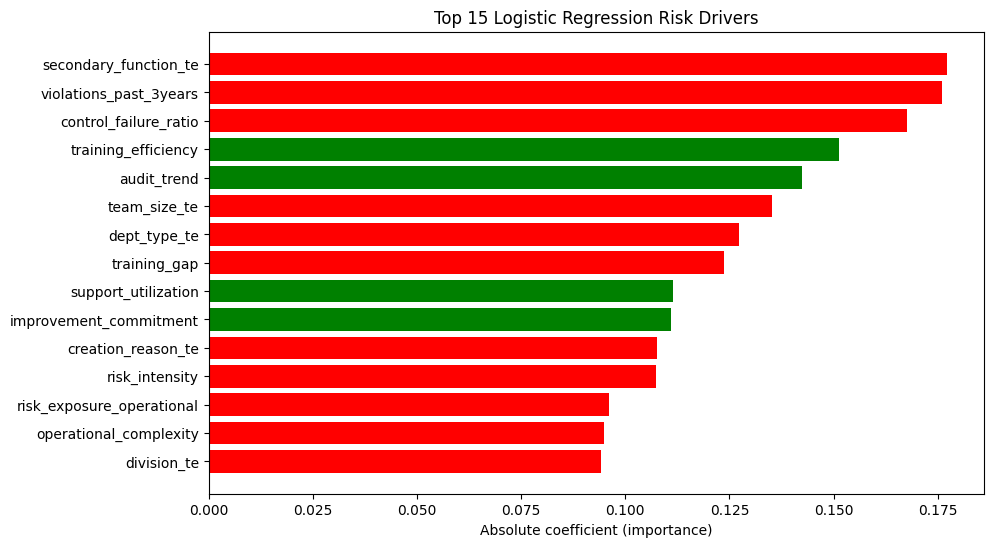

In [104]:
top = lr_importance.head(15).copy()
colors = top["lr_coef"].apply(lambda x: "red" if x > 0 else "green")

plt.figure(figsize = (10, 6))
plt.barh(top["feature"], top["lr_abs"], color = colors)
plt.xlabel("Absolute coefficient (importance)")
plt.title("Top 15 Logistic Regression Risk Drivers")
plt.gca().invert_yaxis()
plt.show()

### Interpretation

The final Logistic Regression model helps us understand the main factors that affect compliance risk. Each part of the model shows how much a factor influences risk, allowing us to not just predict but also understand the reasons behind it.

One key finding is that certain characteristics of a department make it more likely to be seen as **high-risk**. For instance, having issues like; ***secondary_function_te, violations_past_3years, and controls_failure_ratio*** can raise the risk score. These factors show how much a department is involved in compliance-related activities, its past behavior, and the reliability of its processes. It makes sense: departments that have complex roles, recent problems, or weak controls are more likely to face compliance failures in the future.

On the other hand, the model also points out factors that help **lower risk**. Aspects like effective training, good audit practices, and proper use of support resources can reduce the predicted risk level. Departments that focus on good training, show consistent audit results, and use support effectively tend to have fewer compliance issues. This shows that strong processes can protect against risks, and it provides a way to improve specific areas.

Some organizational traits have a moderate effect; they are not the most important but still matter. Factors like team size, type of department, and structure show how the design of an organization affects risk. Bigger teams or complex structures can either help or hurt operations based on how they work with processes. The model recognizes these nuances and gives them a medium level of importance.

Overall, these findings show that the model has created a clear way to understand compliance risk. It focuses on real behaviors and structures rather than just surface-level connections. This clarity is why Logistic Regression is a good final model: it not only identifies high-risk departments but also explains the reasons for the risk. This allows leaders to take informed actions, such as improving internal controls, enhancing training, or simplifying processes.

The model aids in both spotting risks and preventing them, making it a valuable tool for managing an organization.